In [1]:

import numpy as np
import pandas as pd
import json
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


2025-05-06 11:48:12.240580: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 11:48:14.620753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 11:48:14.788329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 11:48:14.880163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 11:48:17.552384: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

json file names and their threshold list:

results 1:[25, 50, 75, 90, 95, 99]

results 2: [10, 25, 40, 50, 60, 75, 90, 95]

results 3: [5, 15, 25, 35, 50, 70, 80, 90, 95]

cos = cosine simmilarity distance

l2 = L2/Euclidean distance

k_values: [5, 10, 15, 20, np.sqrt(N), (np.sqrt(N))/2, log2(N)]

In [3]:
SAVE = False
OUTPUT_FILE = "/home/users/orrbavly/GNN_project/percentiles/outputs/cos_3_all_results.csv"

In [ ]:
# Load data
INPUT_JSON = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_every5_new_mixcr.json"
data_type = 'colon'

# Prepare Data

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.preprocessing

def prepare_data(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array([np.array(v) for v in percentiles_dict.values()])
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        # Determine max_length based on selected vector indices
        if vector_indices is None:
            # No filtering, consider all values
            max_length = max(
                sum(len(v) for v in percentiles_dict.values()) 
                for percentiles_dict in percentiles_data.values()
            )
        else:
            # Compute max_length only for selected indices
            max_length = max(
                sum(len(v) for i, v in enumerate(percentiles_dict.values()) if i in vector_indices)
                for percentiles_dict in percentiles_data.values()
            )
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())

            if vector_indices is not None:
                # Select only the requested vectors
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
            else:
                selected_vectors = vectors

            # Flatten the selected vectors
            flattened_percentiles = np.concatenate([np.array(v) for v in selected_vectors])
            # Pad only up to max_length for selected indices
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)
    
    # np.save("/dsi/sbm/OrrBavly/kidney_data/19k_3_cos_bulk_data", data)
    # np.save("/dsi/sbm/OrrBavly/kidney_data/19k_3_cos_bulk_labels", labels)

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


def prepare_data_nosplit(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array([np.array(v) for v in percentiles_dict.values()])
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        if vector_indices is None:
            # No filtering, consider all values
            max_length = max(
                sum(len(v) for v in percentiles_dict.values()) 
                for percentiles_dict in percentiles_data.values()
            )
        else:
            # Compute max_length only for selected indices
            max_length = max(
                sum(len(v) for i, v in enumerate(percentiles_dict.values()) if i in vector_indices)
                for percentiles_dict in percentiles_data.values()
            )

        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())

            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
            else:
                selected_vectors = vectors
            flattened_percentiles = np.concatenate([np.array(v) for v in selected_vectors])
            # Pad only up to max_length for selected indices
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')

            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)
    return data, labels


In [37]:
def filter_samples(data, criteria):
    filtered_data = {key: value for key, value in data.items() if criteria not in key.lower()}
    return filtered_data

In [38]:
# Run this cell if you want to exclude sample groups from df.
# Case is case-sensitive
# all_results = filter_samples(all_results, criteria="nh")


In [7]:
def load_results(file_path, data_type='ovarian'):
    # load json file
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    # create labels dictionary
    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            if sample_name.endswith("_H"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_OC"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'colon':
            if sample_name.endswith("_low"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_high"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'kidney':
            if "STA" in sample_name:
                labels_dict[sample_name] = 0
            elif "AR" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'corona':
            if "TCRB_M" in sample_name:
                labels_dict[sample_name] = 0
            elif "TCRB_F" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
    return all_results, labels_dict

# ML algorithms

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_knn(X_train, X_test, y_train, y_test, neighbors=10):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("KNN Results")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
        pr_auc = average_precision_score(y_test, knn.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None  # Cannot compute AUC when only one class is present
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")


    return knn, {'model': 'KNN', 'accuracy': accuracy, 'conf_matrix':conf_matrix, 'classification_report': class_report}


## Logistic Regression:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    y_pred = logistic_regression.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Logistic Regression Results")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1])
        pr_auc = average_precision_score(y_test, logistic_regression.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None  # Cannot compute AUC when only one class is present
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")

    return logistic_regression, {'model': 'Logistic Regression', 'accuracy': accuracy, 'conf_matrix':conf_matrix,'classification_report': class_report}


## SVM

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("SVM Results")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Use `predict_proba` if available, otherwise `decision_function`
    try:
        y_score = svm.predict_proba(X_test)[:, 1]  # This works only if probability=True
    except AttributeError:
        y_score = svm.decision_function(X_test)  # Use decision function as a fallback

    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_score)
        pr_auc = average_precision_score(y_test, y_score)
    else:
        roc_auc = None  # Cannot compute AUC when only one class is present
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")

    return svm, {'model': 'SVM', 'accuracy': accuracy, 'conf_matrix':conf_matrix,'classification_report': class_report}


## Decition Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Decision Tree Results")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1])
        pr_auc = average_precision_score(y_test, decision_tree.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None  # Cannot compute AUC when only one class is present
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")

    return decision_tree, {'model': 'Decision Tree', 'accuracy': accuracy, 'conf_matrix':conf_matrix, 'classification_report': class_report}


## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_random_forest(X_train, X_test, y_train, y_test):
    random_forest = RandomForestClassifier(class_weight='balanced')
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Random Forest Results")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
        pr_auc = average_precision_score(y_test, random_forest.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None  # Cannot compute AUC when only one class is present
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")

    return random_forest, {'model': 'Random Forest', 'accuracy': accuracy, 'conf_matrix':conf_matrix, 'classification_report': class_report}


## MLP

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_mlp(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("MLP Results")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])
        pr_auc = average_precision_score(y_test, mlp.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None  # Cannot compute AUC when only one class is present
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")

    return mlp, {'model': 'MLP', 'accuracy': accuracy, 'conf_matrix':conf_matrix, 'classification_report': class_report}


## XGBoost

In [14]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("XGBoost Results:")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        pr_auc = average_precision_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None  # Cannot compute AUC when only one class is present
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")

    return model, {'model': 'XGBoost', 'accuracy': accuracy, 'conf_matrix':conf_matrix, 'classification_report': class_report}


## Neural Network (Keras)

In [15]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score

def train_and_evaluate_nn(X_train, X_test, y_train, y_test):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Get probability predictions for ROC-AUC
    y_pred_proba = model.predict(X_test)  

    print("Neural Network Results:")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Check if both classes exist in y_test before computing ROC-AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
    else:
        roc_auc = None
        pr_auc = None

    print("ROC-AUC:", roc_auc if roc_auc is not None else "Not Defined")
    print("Precision-Recall AUC:", pr_auc if pr_auc is not None else "Not Defined")
    print("")

    return model, {'model': 'Neural Network', 'accuracy': accuracy, 'conf_matrix':conf_matrix, 'classification_report': class_report}


## Grid search

### SVM

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

def train_grid_svm(X_train, X_test, y_train, y_test):
    # Create a pipeline with scaling and SVM
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('svm', SVC())  # SVM classifier
    ])

    # Define the parameter grid
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svm__gamma': [0.001, 0.01, 0.1, 1]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


### Random Forest

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score, average_precision_score


def train_grid_rf(X_train, X_test, y_train, y_test):
    # Create a pipeline with scaling and Random Forest
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('rf', RandomForestClassifier(class_weight='balanced'))  # Random Forest classifier
    ])

    # Define the parameter grid
    param_grid = {
        'rf__n_estimators': [20, 50, 100, 200, 300],
        'rf__max_depth': [5, 10, 15, 20, 30],
        'rf__min_samples_split': [2, 5, 10, 15],
        'rf__min_samples_leaf': [1, 2, 4, 8],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='balanced_accuracy', n_jobs=-1, verbose=0)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Scoring function score from Grid Search:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nRandom Forest Results with Best Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    print("Precision-Recall AUC: ", average_precision_score(y_test, y_pred_proba))


### MLP

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

def train_grid_mlp(X_train, X_test, y_train, y_test):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    # Create a pipeline with scaling and MLP
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('mlp', MLPClassifier(max_iter=2500))  # MLP classifier
    ])

    # Define the parameter grid
    param_grid = {
        'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), [200,], [64, 32]],
        'mlp__activation': ['tanh', 'relu'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__learning_rate': ['constant', 'adaptive']
    }

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nRandom Forest Results with Best Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    print("Precision-Recall AUC: ", average_precision_score(y_test, y_pred_proba))

### Neural Network (keras)

In [19]:
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow import keras
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Function to build a neural network model with specified parameters
# def build_model(num_layers=2, units=32, optimizer='adam'):
#     model = keras.Sequential()
#     model.add(keras.layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
    
#     # Add additional hidden layers based on num_layers
#     for _ in range(num_layers - 1):
#         model.add(keras.layers.Dense(units, activation='relu'))
    
#     # Output layer
#     model.add(keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile model
#     model.compile(optimizer=optimizer,
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Wrapper for the model
# model = KerasClassifier(build_fn=build_model, verbose=0)

# # Define the parameter grid
# param_grid = {
#     'num_layers': [1, 2, 3],  # Number of hidden layers
#     'units': [16, 32, 64],    # Number of units in each layer
#     'batch_size': [16, 32],   # Batch size
#     'epochs': [20, 50],       # Number of epochs
#     'optimizer': ['adam', 'rmsprop']  # Optimizer type
# }

# # Initialize GridSearchCV with the Keras model and parameter grid
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)

# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# # Print the evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred)

# print("Neural Network Results on Test Set:")
# print(f"Accuracy: {accuracy}")
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(class_report)

### XGBoost

In [20]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
import xgboost as xgb

def train_grid_xgboost(X_train, X_test, y_train, y_test):
    # Define the parameter grid, including scale_pos_weight
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'scale_pos_weight': [1.5, 1.7, 1.8, 2.0]  # Adjusted based on class imbalance for colon (90/49)
    }

    # Initialize the XGBClassifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Initialize GridSearchCV, focusing on recall for label 1
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1, verbose=0)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Recall Score from Grid Search:", grid_search.best_score_)

    # Use the best model to make predictions on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the best model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nXGBoost Results with Best Parameters for Label 1 Recall:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    print("Precision-Recall AUC: ", average_precision_score(y_test, y_pred_proba))


# Various K values

In [54]:
all_results, labels_dict = load_results(INPUT_JSON, data_type=data_type)

In [22]:
results = []  # Holds all the different k values (and their models) results.
models = []


In [21]:
def run_evaluation(X_train, X_test, y_train, y_test, k_value, results, models, save_results=True):
    model_functions = [
        ('KNN', train_and_evaluate_knn),
        ('Logistic Regression', train_and_evaluate_logistic_regression),
        ('SVM', train_and_evaluate_svm),
        ('Decision Tree', train_and_evaluate_decision_tree),
        ('Random Forest', train_and_evaluate_random_forest),
        ('MLP', train_and_evaluate_mlp),
        ('XGBoost', train_and_evaluate_xgboost), 
        ('Neural Network', train_and_evaluate_nn)
    ]

    for model_name, train_func in model_functions:
        model, result = train_func(X_train, X_test, y_train, y_test)
        if save_results:
            results.append({'k_value': k_value, **result})
            models.append({'k_value': k_value, 'model_name': model_name, 'model': model})


## all k

In [57]:
X_train, X_test, y_train, y_test = prepare_data(all_results, labels_dict)

In [58]:
print(y_train, len(y_train))
print(y_test, len(y_test))

[1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0
 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1
 0 0 0 1 0 0] 117
[0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1] 30


In [59]:
from collections import Counter

# Count occurrences of 0 and 1
value_counts = Counter(labels_dict.values())

# Print the number of 0s and 1s
print(f"Number of 0s: {value_counts[0]}")
print(f"Number of 1s: {value_counts[1]}")

Number of 0s: 96
Number of 1s: 51


In [60]:
run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=results, models=models)

KNN Results
Accuracy: 0.6
Balanced Accuracy: 0.45
Confusion Matrix:
[[18  2]
 [10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        20
           1       0.00      0.00      0.00        10

    accuracy                           0.60        30
   macro avg       0.32      0.45      0.38        30
weighted avg       0.43      0.60      0.50        30

ROC-AUC: 0.5125
Precision-Recall AUC: 0.3422360248447205

Logistic Regression Results
Accuracy: 0.6333333333333333
Balanced Accuracy: 0.475
Confusion Matrix:
[[19  1]
 [10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.95      0.78        20
           1       0.00      0.00      0.00        10

    accuracy                           0.63        30
   macro avg       0.33      0.47      0.39        30
weighted avg       0.44      0.63      0.52        30

ROC-AUC: 0.42000000000000004
Precisi

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Balanced Accuracy: 0.5
Confusion Matrix:
[[20  0]
 [10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        20
           1       0.00      0.00      0.00        10

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30

ROC-AUC: 0.355
Precision-Recall AUC: 0.2794246815985946

Decision Tree Results
Accuracy: 0.6333333333333333
Balanced Accuracy: 0.6
Confusion Matrix:
[[14  6]
 [ 5  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        20
           1       0.45      0.50      0.48        10

    accuracy                           0.63        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.64      0.63      0.64        30

ROC-AUC: 0.5999999999999999
Precision-Recall AUC: 0.3939393939393939

Ra

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-08 12:12:35.889005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78415 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:65:00.0, compute capability: 8.0
2025-04-08 12:12:35.904640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78415 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
I0000 00:00:1744103565.464074 1030083 service.cc:146] XLA service 0x7f73f0016e00 initialized for platform CUDA (this does

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Neural Network Results:
Accuracy: 0.5666666666666667
Balanced Accuracy: 0.425
Confusion Matrix:
[[17  3]
 [10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.00      0.00      0.00        10

    accuracy                           0.57        30
   macro avg       0.31      0.42      0.36        30
weighted avg       0.42      0.57      0.48        30

ROC-AUC: 0.4
Precision-Recall AUC: 0.3011246000376435



In [163]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a pipeline with scaling and SVM
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC())  # SVM classifier
])

# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best Score: 0.7644268774703556
Test Accuracy: 0.7857142857142857
[[14  3]
 [ 3  8]]


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Create a pipeline with scaling and MLP
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('mlp', MLPClassifier(max_iter=1000))  # MLP classifier
])

# Define the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}
Best Score: 0.8027667984189725
Test Accuracy: 0.6785714285714286
[[14  3]
 [ 6  5]]


In [56]:
train_grid_rf(X_train, X_test, y_train, y_test)

Best Parameters: {'rf__bootstrap': False, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best Scoring function score from Grid Search: 0.8104398017441495

Random Forest Results with Best Parameters:
Accuracy: 0.6071428571428571
Confusion Matrix:
[[11  6]
 [ 5  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        17
           1       0.50      0.55      0.52        11

    accuracy                           0.61        28
   macro avg       0.59      0.60      0.59        28
weighted avg       0.61      0.61      0.61        28

Balanced Accuracy: 0.5963
ROC-AUC: 0.6256684491978609
Precision-Recall AUC:  0.5343526170798898


In [57]:
# train_grid_xgboost(X_train, X_test, y_train, y_test)

## Average K

In [ ]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = prepare_data(all_results, labels_dict, average_vectors=True)

In [ ]:
run_evaluation(X_train_avg, X_test_avg, y_train_avg, y_test_avg, k_value="avg_k", results=results, models=models)


## Subgroup K values

In [40]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = prepare_data(all_results, labels_dict, vector_indices=[1, 3, 5, 7, 10, 14, 16, 18, 19])

In [41]:
run_evaluation(X_train_sub, X_test_sub, y_train_sub, y_test_sub, k_value="sub_k", results=[], models=[])

KNN Results
Accuracy: 0.6428571428571429
Balanced Accuracy: 0.625668449197861
Confusion Matrix:
[[12  5]
 [ 5  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.55      0.55      0.55        11

    accuracy                           0.64        28
   macro avg       0.63      0.63      0.63        28
weighted avg       0.64      0.64      0.64        28

ROC-AUC: 0.6336898395721926
Precision-Recall AUC: 0.47931367675386816

Logistic Regression Results
Accuracy: 0.6071428571428571
Balanced Accuracy: 0.5962566844919786
Confusion Matrix:
[[11  6]
 [ 5  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        17
           1       0.50      0.55      0.52        11

    accuracy                           0.61        28
   macro avg       0.59      0.60      0.59        28
weighted avg       0.61      0.61    

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Neural Network Results:
Accuracy: 0.6071428571428571
Balanced Accuracy: 0.5962566844919786
Confusion Matrix:
[[11  6]
 [ 5  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        17
           1       0.50      0.55      0.52        11

    accuracy                           0.61        28
   macro avg       0.59      0.60      0.59        28
weighted avg       0.61      0.61      0.61        28

ROC-AUC: 0.6149732620320856
Precision-Recall AUC: 0.4551098556562402



## Leave One Out

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def train_and_evaluate_knn(X_train, X_test, y_train, y_test, neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred

from sklearn.linear_model import LogisticRegression

def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

from sklearn.svm import SVC

def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

from sklearn.tree import DecisionTreeClassifier

def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

from sklearn.ensemble import RandomForestClassifier

def train_and_evaluate_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, class_weight="balanced")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

from sklearn.neural_network import MLPClassifier

def train_and_evaluate_mlp(X_train, X_test, y_train, y_test):
    model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

from xgboost import XGBClassifier

def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

from tensorflow import keras

def train_and_evaluate_nn(X_train, X_test, y_train, y_test):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    return y_pred



In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix

def compute_final_metrics(true_labels, predicted_labels, model_name):
    """
    Computes and displays final evaluation metrics for the model.

    Parameters:
        true_labels (list): List of actual labels from LOOCV.
        predicted_labels (list): List of predicted labels from LOOCV.
        model_name (str): The name of the model.

    Returns:
        None
    """
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="binary", zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average="binary", zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average="binary", zero_division=0)
    balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

    print(f"\nFinal Metrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}")
    print(f"  Confusion Matrix:\n{conf_matrix}")



def process_and_evaluate_loocv(percentiles_data, labels_dict, results, models, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant') 
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])
    
    # Convert to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    # Initialize Leave-One-Out cross-validator
    loo = LeaveOneOut()

    # Define models and corresponding training functions
    model_functions = {
        "KNN": train_and_evaluate_knn,
        "Logistic Regression": train_and_evaluate_logistic_regression,
        "SVM": train_and_evaluate_svm,
        "Decision Tree": train_and_evaluate_decision_tree,
        "Random Forest": train_and_evaluate_random_forest,
        "MLP": train_and_evaluate_mlp,
        "XGBoost": train_and_evaluate_xgboost,
        "Neural Network": train_and_evaluate_nn
    }

    # Initialize results storage
    results = {model_name: {"true_labels": [], "predicted_labels": []} for model_name in model_functions}

    # Iterate over LOOCV splits
    for train_idx, test_idx in loo.split(data):
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Run all models and collect predictions
        for model_name, model_function in model_functions.items():
            y_pred = model_function(X_train, X_test, y_train, y_test)
            results[model_name]["true_labels"].append(y_test[0])
            results[model_name]["predicted_labels"].append(y_pred[0])

    # Compute final evaluation metrics for all models
    for model_name in model_functions:
        compute_final_metrics(results[model_name]["true_labels"], results[model_name]["predicted_labels"], model_name)

In [ ]:
# Initialize containers for results and models
results = []
models = []

# Perform LOOCV
process_and_evaluate_loocv(all_results, labels_dict, results=results, models=models)

# Print aggregated results
print("Total Results:", len(results))

## General EDA

In [59]:
all_results_try, labels_dict_try = load_results("/home/dsi/orrbavly/GNN_project/embeddings/kidney_percentiles/perc_results_cos_3_19k.json", data_type="kidney")

In [60]:
X_train_try, X_test_try, y_train_try, y_test_try = prepare_data(all_results_try, labels_dict_try, vector_indices=[0,6])

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
run_evaluation(X_train_try, X_test_try, y_train_try, y_test_try, k_value="sub_k", results=[], models=[])

## K-fold Validation

In [9]:
def prepare_data_kfold(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array([np.array(v) for v in percentiles_dict.values()])
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        if vector_indices is None:
            # No filtering, consider all values
            max_length = max(
                sum(len(v) for v in percentiles_dict.values()) 
                for percentiles_dict in percentiles_data.values()
            )
        else:
            # Compute max_length only for selected indices
            max_length = max(
                sum(len(v) for i, v in enumerate(percentiles_dict.values()) if i in vector_indices)
                for percentiles_dict in percentiles_data.values()
            )

        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())

            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
            else:
                selected_vectors = vectors
            flattened_percentiles = np.concatenate([np.array(v) for v in selected_vectors])
            # Pad only up to max_length for selected indices
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')

            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)
    return data, labels


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score
import numpy as np

def evaluate_model_with_kfold(model, data, labels, k=5):
    """
    Perform K-Fold Cross-Validation on a given model and compute evaluation metrics.

    Parameters:
    - model: Scikit-learn classifier (e.g., RandomForestClassifier, LogisticRegression)
    - data: NumPy array or Pandas DataFrame of feature vectors
    - labels: NumPy array or Pandas Series of target labels
    - k: Number of folds for Stratified K-Fold (default=5)

    Returns:
    - results_dict: Dictionary with mean and std of all computed metrics
    """

    skf = StratifiedKFold(n_splits=k, shuffle=True)
    # skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Lists to store metric scores
    accuracy_scores = []
    balanced_accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    roc_auc_scores = []
    log_loss_scores = []
    mcc_scores = []

    for train_idx, test_idx in skf.split(data, labels):
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Standardize features using only the training set
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)  # Apply same transformation to test set

        model.fit(X_train, y_train)  # Train model
        y_pred = model.predict(X_test)  # Predict class labels

        # Handle probability outputs (SVC does not have predict_proba by default)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]  # Get positive class probabilities
        elif hasattr(model, "decision_function"):  # Use decision function for SVM
            y_proba = model.decision_function(X_test)
        else:
            y_proba = None

        # Compute Metrics
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))  
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        if y_proba is not None:
            roc_auc_scores.append(roc_auc_score(y_test, y_proba))
            log_loss_scores.append(log_loss(y_test, y_proba))
        else:
            roc_auc_scores.append(None)
            log_loss_scores.append(None)
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))

    # Aggregate results
    results_dict = {
        "Accuracy": (np.mean(accuracy_scores), np.std(accuracy_scores)),
        "Balanced Accuracy": (np.mean(balanced_accuracy_scores), np.std(balanced_accuracy_scores)),
        "F1-Score": (np.mean(f1_scores), np.std(f1_scores)),
        "F1-Score": (np.mean(f1_scores), np.std(f1_scores)),
        "Precision": (np.mean(precision_scores), np.std(precision_scores)),
        "Recall": (np.mean(recall_scores), np.std(recall_scores)),
        "ROC AUC": (np.mean([s for s in roc_auc_scores if s is not None]), np.std([s for s in roc_auc_scores if s is not None])) if any(roc_auc_scores) else None,
        "Log Loss": (np.mean([s for s in log_loss_scores if s is not None]), np.std([s for s in log_loss_scores if s is not None])) if any(log_loss_scores) else None,
        "MCC": (np.mean(mcc_scores), np.std(mcc_scores))
    }

    # Print results
    print("\nK-Fold Cross-Validation Results:")
    for metric, value in results_dict.items():
        if value is not None:
            mean, std = value
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    return results_dict


In [57]:
all_results, labels_dict = load_results("/home/dsi/orrbavly/GNN_project/embeddings/kidney_percentiles/perc_results_cos_3_19k.json", data_type="kidney")
data, labels = prepare_data_kfold(all_results, labels_dict)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [60]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=180,         # Number of trees
    criterion="entropy",      # Use entropy as the split criterion
    max_depth=5,              # Maximum depth of trees
    min_samples_split=6,      # Minimum samples required to split a node
    min_samples_leaf=7,       # Minimum samples required at a leaf node
    max_features="log2",      # Number of features to consider for best split
    bootstrap=False,          # Disable bootstrapping (use the whole dataset)
    ccp_alpha=0.015          # Complexity parameter for pruning
)
from sklearn.svm import SVC
svm = svm_model = SVC(C=100, gamma=0.001, kernel='rbf', probability=True)
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(activation='relu', alpha=0.01, hidden_layer_sizes=(100,), learning_rate='constant', solver='sgd', max_iter=300 )
import xgboost as xgb
xgbmodel = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [69]:
evaluate_model_with_kfold(rf, data, labels, k=5)


K-Fold Cross-Validation Results:
Accuracy: 0.6536 ± 0.0392
Balanced Accuracy: 0.6282 ± 0.0402
F1-Score: 0.6408 ± 0.0376
Precision: 0.6536 ± 0.0471
Recall: 0.6536 ± 0.0392
ROC AUC: 0.6446 ± 0.0624
Log Loss: 0.6676 ± 0.0589
MCC: 0.2788 ± 0.0911


{'Accuracy': (0.6536290322580645, 0.03918558262340753),
 'Balanced Accuracy': (0.6282015370250664, 0.04023404253440174),
 'F1-Score': (0.6408076944339586, 0.03763100846904207),
 'Precision': (0.6536287704231253, 0.047073077752536295),
 'Recall': (0.6536290322580645, 0.03918558262340753),
 'ROC AUC': (0.6446419593478417, 0.06235683902424783),
 'Log Loss': (0.6675545934387078, 0.05893761327555493),
 'MCC': (0.27881567106327776, 0.09111143769908842)}

## Atom

In [61]:
import numpy as np
from atom import ATOMClassifier  # Use ATOMRegressor for regression
import pandas as pd

In [62]:
all_results, labels_dict = load_results("/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_every5_new_mixcr.json", data_type="colon")
data, labels = prepare_data_nosplit(all_results, labels_dict)

In [63]:
data_df = pd.DataFrame(data)
data_df["target"] = labels

In [ ]:
# Correct Atom initialization (pass `df` and `target` together)
atom = ATOMClassifier(data_df, y="target", test_size=0.2, verbose=2)
# Apply Standard Scaling (equivalent to StandardScaler)
atom.scale(strategy="standard")
atom.run(models=["lSVM", "SVM", "LR", "Tree", "AdaB", "RF", "XGB", "MLP"], metric="balanced_accuracy", n_trials=20, n_bootstrap=10)


<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (156, 64)
Train set size: 125
Test set size: 31
-------------------------------------
Memory: 80.00 kB
Scaled: False
Outlier values: 97 (1.2%)

Fitting Scaler...
Scaling features...

Training ========================= >>
Models: lSVM, SVM, LR, Tree, AdaB, RF, XGB, MLP
Metric: balanced_accuracy


Running hyperparameter tuning for LinearSVM...
| trial | penalty |      loss |       C |    dual | balanced_accuracy | best_balanced_accuracy | time_trial | time_ht |    state |
| ----- | ------- | --------- | ------- | ------- | ----------------- | ---------------------- | ---------- | ------- | -------- |
| 0     |      l2 |     hinge |  0.0507 |    True |            0.5844 |                 0.5844 |     0.020s |  0.020s | COMPLETE |
| 1     |      l2 | squared.. |  0.0049 |    True |            0.6753 |                 0.6753 |     0.019s |  0.039s | COMPLETE 

In [69]:
# Correct Atom initialization (pass `df` and `target` together)
atom = ATOMClassifier(data_df, y="target", test_size=0.2, verbose=2)
# Apply Standard Scaling (equivalent to StandardScaler)
atom.scale(strategy="standard")
solvers = []
models = ["GBM", "LR", "LDA", "QDA", "RNN", "AdaB", "RF", "XGB", "MLP"]
atom.feature_selection(strategy="SFM", solver="RF", n_features=8)
atom.scale(strategy="standard")
atom.run(models=models, n_trials=50, metric="balanced_accuracy", n_bootstrap=3)


<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (147, 148)
Train set size: 118
Test set size: 29
-------------------------------------
Memory: 174.18 kB
Scaled: False
Outlier values: 354 (2.0%)

Fitting Scaler...
Scaling features...
Fitting FeatureSelector...
Performing feature selection ...
 --> sfm selected 8 features from the dataset.
   --> Dropping feature 1.
   --> Dropping feature 2.
   --> Dropping feature 3.
   --> Dropping feature 4.
   --> Dropping feature 5.
   --> Dropping feature 6.
   --> Dropping feature 7.
   --> Dropping feature 8.
   --> Dropping feature 9.
   --> Dropping feature 10.
   --> Dropping feature 11.
   --> Dropping feature 12.
   --> Dropping feature 13.
   --> Dropping feature 14.
   --> Dropping feature 15.
   --> Dropping feature 16.
   --> Dropping feature 17.
   --> Dropping feature 18.
   --> Dropping feature 19.
   --> Dropping feature 20.
   --> Dropping feature

Trial 10 failed with parameters: {'radius': 1.0699,
 'weights': 'uniform',
 'algorithm': 'auto',
 'leaf_size': 27,
 'p': 1} because of the following error: ValueError('No neighbors found for test samples array([ 3,  4, 11, 13, 15, 17, 19, 21]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.').
Traceback (most recent call last):
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 927, in objective
    estimator, score = fit_model(estimator, *next(fold))
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 878, in fit_model
    scores = [
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 879, in <listcomp>
    self._score_from_es


Exception encountered while running the RNN model.
ValueError: No neighbors found for test samples array([ 3,  4, 11, 13, 15, 17, 19, 21]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.


Running hyperparameter tuning for AdaBoost...
| trial | n_estimators | learning_rate | algorithm | balanced_accuracy | best_balanced_accuracy | time_trial | time_ht |    state |
| ----- | ------------ | ------------- | --------- | ----------------- | ---------------------- | ---------- | ------- | -------- |
| 0     |          260 |         0.056 |     SAMME |            0.4688 |                 0.4688 |     0.632s |  0.632s | COMPLETE |
| 1     |          310 |        0.0117 |   SAMME.R |            0.4688 |                 0.4688 |     0.690s |  1.322s | COMPLETE |
| 2     |          290 |        0.0193 |     SAMME |            0.4375 |                 0.4688 |     0.670s |  1.992s | COMPLETE |
| 3     |           80 |        1.6139 | 

In [12]:
# Correct Atom initialization (pass `df` and `target` together)
atom = ATOMClassifier(data_df, y="target", test_size=0.2, verbose=2)
# Apply Standard Scaling (equivalent to StandardScaler)
atom.scale(strategy="standard")
solvers = ["LR", "XGB"]
models = ["GBM", "LR", "LDA", "QDA", "RNN", "AdaB", "RF", "XGB", "MLP"]
for solver in solvers:
    atom.branch = "sfm" + solver + "_from_master"
    atom.feature_selection(strategy="SFM", solver=solver, n_features=5, random_state=0)
    atom.scale(strategy="standard")
    models_named = [model + "_" + solver for model in models]
    atom.run(models=models_named, n_trials=50, metric="balanced_accuracy", n_bootstrap=3)


<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (156, 64)
Train set size: 125
Test set size: 31
-------------------------------------
Memory: 80.00 kB
Scaled: False
Outlier values: 116 (1.4%)

Fitting Scaler...
Scaling features...
New branch sfmLR successfully created.
Fitting FeatureSelector...
Performing feature selection ...
 --> sfm selected 5 features from the dataset.
   --> Dropping feature 0.
   --> Dropping feature 1.
   --> Dropping feature 2.
   --> Dropping feature 3.
   --> Dropping feature 4.
   --> Dropping feature 5.
   --> Dropping feature 6.
   --> Dropping feature 7.
   --> Dropping feature 8.
   --> Dropping feature 10.
   --> Dropping feature 11.
   --> Dropping feature 12.
   --> Dropping feature 13.
   --> Dropping feature 14.
   --> Dropping feature 15.
   --> Dropping feature 16.
   --> Dropping feature 17.
   --> Dropping feature 18.
   --> Dropping feature 19.
   --> Droppin

Trial 12 failed with parameters: {'radius': 0.7755,
 'weights': 'distance',
 'algorithm': 'ball_tree',
 'leaf_size': 21,
 'p': 2} because of the following error: ValueError('No neighbors found for test samples array([11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.').
Traceback (most recent call last):
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 927, in objective
    estimator, score = fit_model(estimator, *next(fold))
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 878, in fit_model
    scores = [
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 879, in <listcomp>
    self._score_from_est(metric, estimator, X

| 10    |  2.4401 | dista.. | ball_tree |        20 |       2 |            0.6104 |                 0.6818 |     0.108s |  1.103s | COMPLETE |
| 11    |  7.1514 | dista.. | ball_tree |        20 |       2 |            0.5097 |                 0.6818 |     0.074s |  1.177s | COMPLETE |

Exception encountered while running the RNN_LR model.
ValueError: No neighbors found for test samples array([11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.


Running hyperparameter tuning for AdaBoost...
| trial | n_estimators | learning_rate | algorithm | balanced_accuracy | best_balanced_accuracy | time_trial | time_ht |    state |
| ----- | ------------ | ------------- | --------- | ----------------- | ---------------------- | ---------- | ------- | -------- |
| 0     |          250 |        5.7697 |   SAMME.R |            0.6396 |                 0.6396 |     0.341s |  0.341s | COMPLETE |
| 1     |           80 |        0.1233 |   S

Trial 25 failed with parameters: {'radius': 0.0843,
 'weights': 'distance',
 'algorithm': 'kd_tree',
 'leaf_size': 38,
 'p': 2} because of the following error: ValueError('No neighbors found for test samples array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,\n       18, 20, 21, 22, 23, 24]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.').
Traceback (most recent call last):
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 927, in objective
    estimator, score = fit_model(estimator, *next(fold))
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/atom/basemodel.py", line 878, in fit_model
    scores = [
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-pack


Exception encountered while running the RNN_XGB model.
ValueError: No neighbors found for test samples array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 20, 21, 22, 23, 24]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.


Running hyperparameter tuning for AdaBoost...
| trial | n_estimators | learning_rate | algorithm | balanced_accuracy | best_balanced_accuracy | time_trial | time_ht |    state |
| ----- | ------------ | ------------- | --------- | ----------------- | ---------------------- | ---------- | ------- | -------- |
| 0     |          140 |        6.1156 |     SAMME |            0.5195 |                 0.5195 |     0.419s |  0.419s | COMPLETE |
| 1     |          450 |        0.1106 |     SAMME |            0.5844 |                 0.5844 |     0.749s |  1.167s | COMPLETE |
| 2     |          420 |        6.7992 |     SAMME |            0.6104 |                 0.6104 |     

# Centrality 

## pagerank

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
feature_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/centrality/pagerank_top10.csv")

In [ ]:
def run_feature_selection(feature_df):
    # Step 1: Create Labels (1 for 'H', 0 for 'OC')
    feature_df['label'] = feature_df['graph_name'].apply(lambda x: 1 if 'OC' in x else 0)

    # Step 2: Split data into features (X) and labels (y)
    X = feature_df.drop(columns=['graph_name', 'label'])  # Features are all columns except 'graph_name' and 'label'
    y = feature_df['label']  # Labels are 1 (H) or 0 (OC)

    # Step 3: Split the dataset into training and testing sets (e.g., 80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    run_evaluation(X_train, X_test, y_train, y_test, k_value="page_rank", results=[], models=[], save_results=False)


In [ ]:
run_feature_selection(feature_df)

# General EDA

## Analyzing Json files

In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
# Load the JSON files
ovarian_path = "/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json"
colon_path = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_3_all.json"
kidney_path = "/home/dsi/orrbavly/GNN_project/embeddings/kidney_percentiles/perc_results_cos_3_21k_clonotype.json"
corona_path = "/home/dsi/orrbavly/GNN_project/embeddings/corona_percentiles/checkpoints/perc_faiss_cos_every5_1-816.json"
# Load and extract features for each group
ovarian_path_outlines = '/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json'
colon_path_outlines = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_3_all.json"
kidney_path_outlines = "/home/dsi/orrbavly/GNN_project/embeddings/kidney_percentiles/perc_results_cos_3_19k.json"


In [28]:
low_group_tags = ["low", "H", "STA", "TCRB_M"]
high_group_tags = ["high", "OC", "AR", "TCRB_F"]

In [29]:
def load_percentiles(json_path):
    """Load JSON and structure each sample as a list of lists for plotting."""
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    samples = []
    for sample_name, percentiles_dict in data.items():
        # Convert each dictionary to a sorted list of lists
        sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
        samples.append(sample_data)
    
    return samples

def plot_percentiles(samples, dataset_name, k_labels):
    """Plot the mean and standard deviation of percentiles for each k value."""
    plt.figure(figsize=(10, 6))
    
    # Assign a unique color for each k value
    colors = plt.cm.viridis(np.linspace(0, 1, len(k_labels)))
    
    for k_index, k_label in enumerate(k_labels):
        k_percentiles = []
        
        # Collect the k-th percentile data across all samples
        for sample in samples:
            if k_index < len(sample):  # Ensure we don't index out of bounds
                percentiles = sample[k_index][1:]  # Skip the first element (k value)
                k_percentiles.append(percentiles)
        
        k_percentiles = np.array(k_percentiles)
        
        # Calculate mean and standard deviation
        mean_percentiles = np.mean(k_percentiles, axis=0)
        std_percentiles = np.std(k_percentiles, axis=0)
        
        # Plot with error bars
        plt.plot(mean_percentiles, color=colors[k_index], label=f'k={k_label}')
        plt.fill_between(range(len(mean_percentiles)), 
                         mean_percentiles - std_percentiles, 
                         mean_percentiles + std_percentiles, 
                         color=colors[k_index], alpha=0.2)
    
    plt.title(f"Percentile Values for {dataset_name} Dataset")
    plt.xlabel("Percentile Index")
    plt.ylabel("Percentile Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [30]:
import seaborn as sns

def plot_grouped_histograms(samples_group_0, samples_group_1, k_labels):
    """Plot grouped histograms for each k value with normalized frequency and arranged in a grid."""
    n_k = len(k_labels)
    n_cols = 3  # Number of plots per row
    n_rows = (n_k + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=True)
    axs = axs.flatten()  # Flatten to easily iterate over each axis
    
    for k_index, k_label in enumerate(k_labels):
        # Collect percentiles for the current k value from each group
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group for the current k value
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
        # Calculate x-axis limits dynamically based on the data range
        min_val = min(group_0_data.min(), group_1_data.min())
        max_val = max(group_0_data.max(), group_1_data.max())
        x_margin = 0.05 * (max_val - min_val)  # Add a margin to the limits
        
        # Plot histogram for each group with normalization
        axs[k_index].hist(group_0_data, bins=30, alpha=0.5, label='Group 0', color='blue', density=True)
        axs[k_index].hist(group_1_data, bins=30, alpha=0.5, label='Group 1', color='orange', density=True)
        axs[k_index].set_title(f'k={k_label}')
        axs[k_index].set_ylabel("Density")
        axs[k_index].set_yscale('log')
        axs[k_index].set_xlim(min_val - x_margin, max_val + x_margin)  # Set dynamic x-axis limits
        axs[k_index].legend()
    
    # Hide any unused subplots
    for i in range(k_index + 1, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_box_plots(samples_group_0, samples_group_1, k_labels):
    """Plot box plots for each k value, separated by group."""
    fig, axs = plt.subplots(1, len(k_labels), figsize=(4 * len(k_labels), 6), sharey=True)
    
    for k_index, k_label in enumerate(k_labels):
        # Prepare data for the box plot
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
       # Create a DataFrame for easier plotting with seaborn
        data = {
            'Percentile Value': np.concatenate([group_0_data, group_1_data]),
            'Group': ['Group 0'] * len(group_0_data) + ['Group 1'] * len(group_1_data)
        }
        sns.boxplot(data=data, x='Group', y='Percentile Value', hue='Group', ax=axs[k_index], palette=['blue', 'orange'], legend=False)
        axs[k_index].set_title(f'k={k_label}')
    
    plt.tight_layout()
    plt.show()


def plot_violin_plots(samples_group_0, samples_group_1, k_labels):
    """Plot violin plots for each k value, separated by group."""
    fig, axs = plt.subplots(1, len(k_labels), figsize=(4 * len(k_labels), 6), sharey=True)
    
    for k_index, k_label in enumerate(k_labels):
        # Prepare data for the violin plot
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
        # Create a DataFrame for easier plotting with seaborn
        data = {
            'Percentile Value': np.concatenate([group_0_data, group_1_data]),
            'Group': ['Group 0'] * len(group_0_data) + ['Group 1'] * len(group_1_data)
        }
        sns.violinplot(data=data, x='Group', y='Percentile Value', hue='Group', ax=axs[k_index], palette=['blue', 'orange'])
        axs[k_index].set_title(f'k={k_label}')
    
    plt.tight_layout()
    plt.show()


def run_plots(samples_group_0, samples_group_1, k_labels):
    plot_grouped_histograms(samples_group_0, samples_group_1, k_labels)
    plot_box_plots(samples_group_0, samples_group_1, k_labels)
    plot_violin_plots(samples_group_0, samples_group_1, k_labels)


def load_json_groups(json_path, perc_type='k_neighboors'):
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    group_0 = []
    group_1 = []
    for sample_name, percentiles_dict in data.items():
        if any(tag in sample_name for tag in low_group_tags):
            # Convert each dictionary to a sorted list of lists
            if perc_type=='k_neighboors':
                sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
                group_0.append(sample_data)
            elif perc_type=='radius':
                sample_data = [[float(k)] + v for k, v in percentiles_dict.items()]
                group_0.append(sample_data)
        elif any(tag in sample_name for tag in high_group_tags):
            # Convert each dictionary to a sorted list of lists
            if perc_type=='k_neighboors':
                sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
                group_1.append(sample_data)
            if perc_type=='radius':
                sample_data = [[float(k)] + v for k, v in percentiles_dict.items()]
                group_1.append(sample_data)
    return group_0, group_1

In [39]:
ovarian_data = load_percentiles(ovarian_path)
colon_data = load_percentiles(colon_path)

# Define k values (assuming they are the same for both datasets)
k_values = [5, 10, 15, 20, 'sqrt', 'sqrt/2', 'log']  # Custom labels as specified
r_values = [0.45, 0.5, 0.53, 0.6, 0.65, 0.68, 0.72]


In [ ]:
# Plot percentiles for ovarian dataset
plot_percentiles(ovarian_data, "Ovarian", k_values)

In [ ]:
# Plot percentiles for colon dataset
plot_percentiles(colon_data, "Colon", k_values)

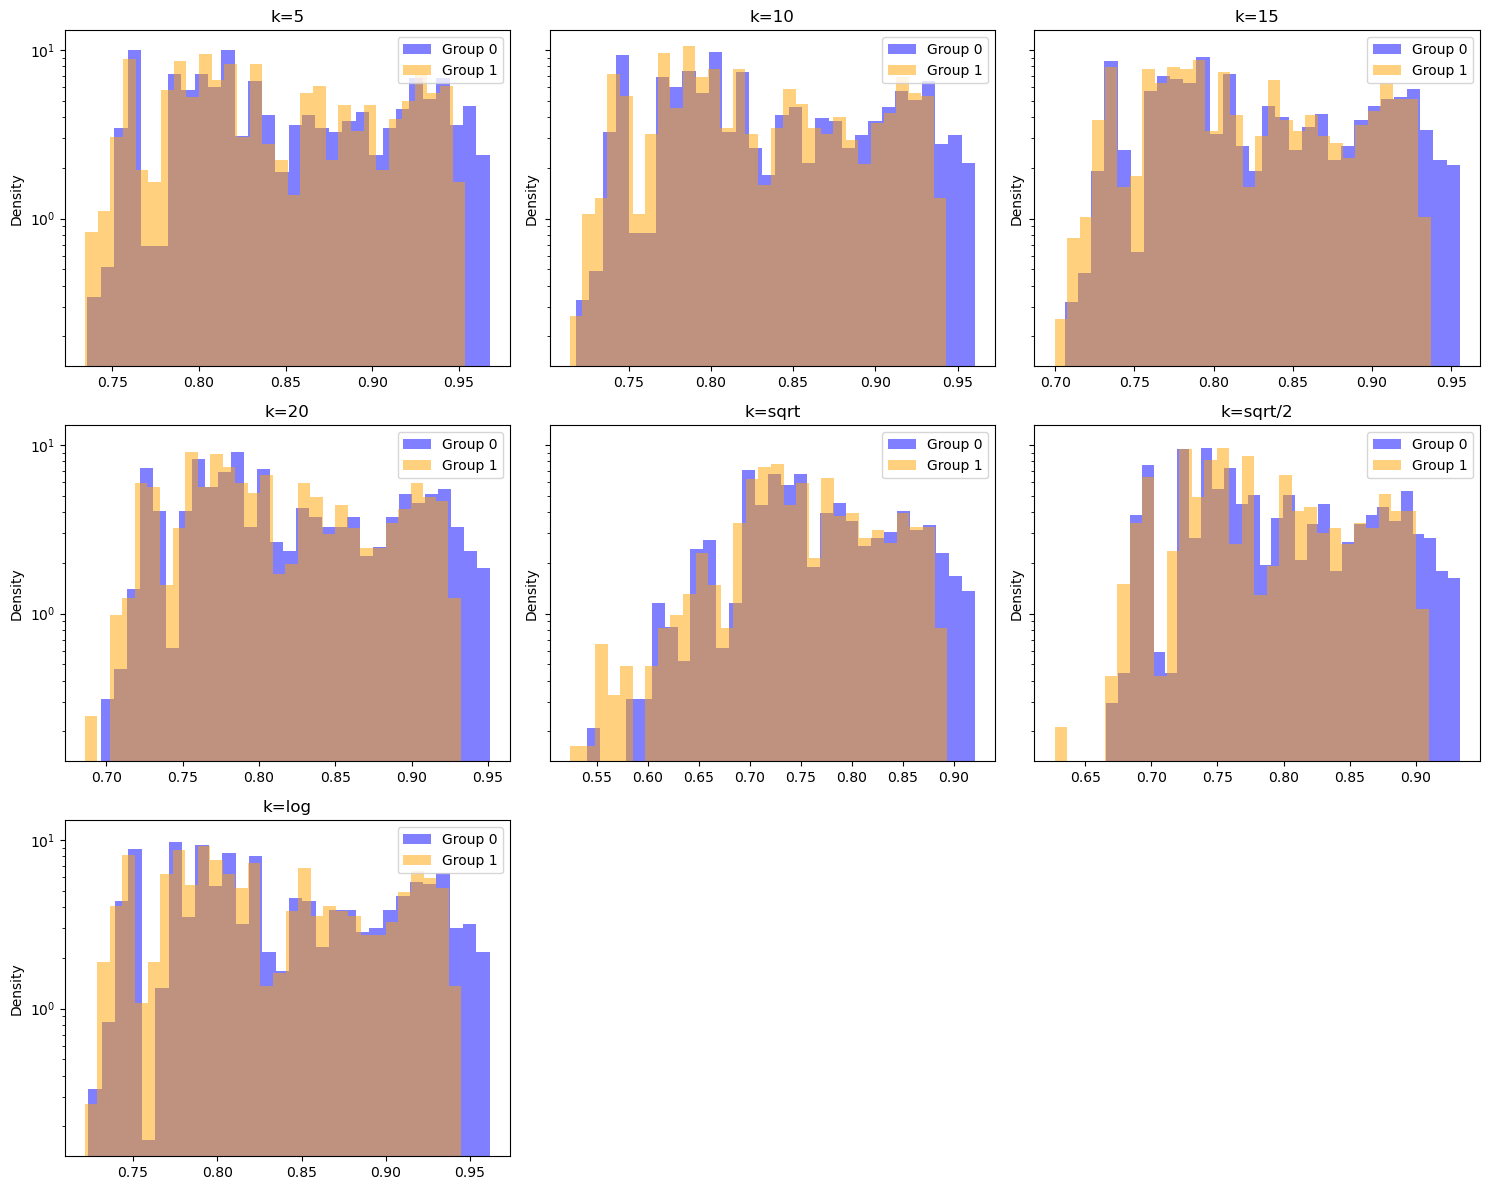

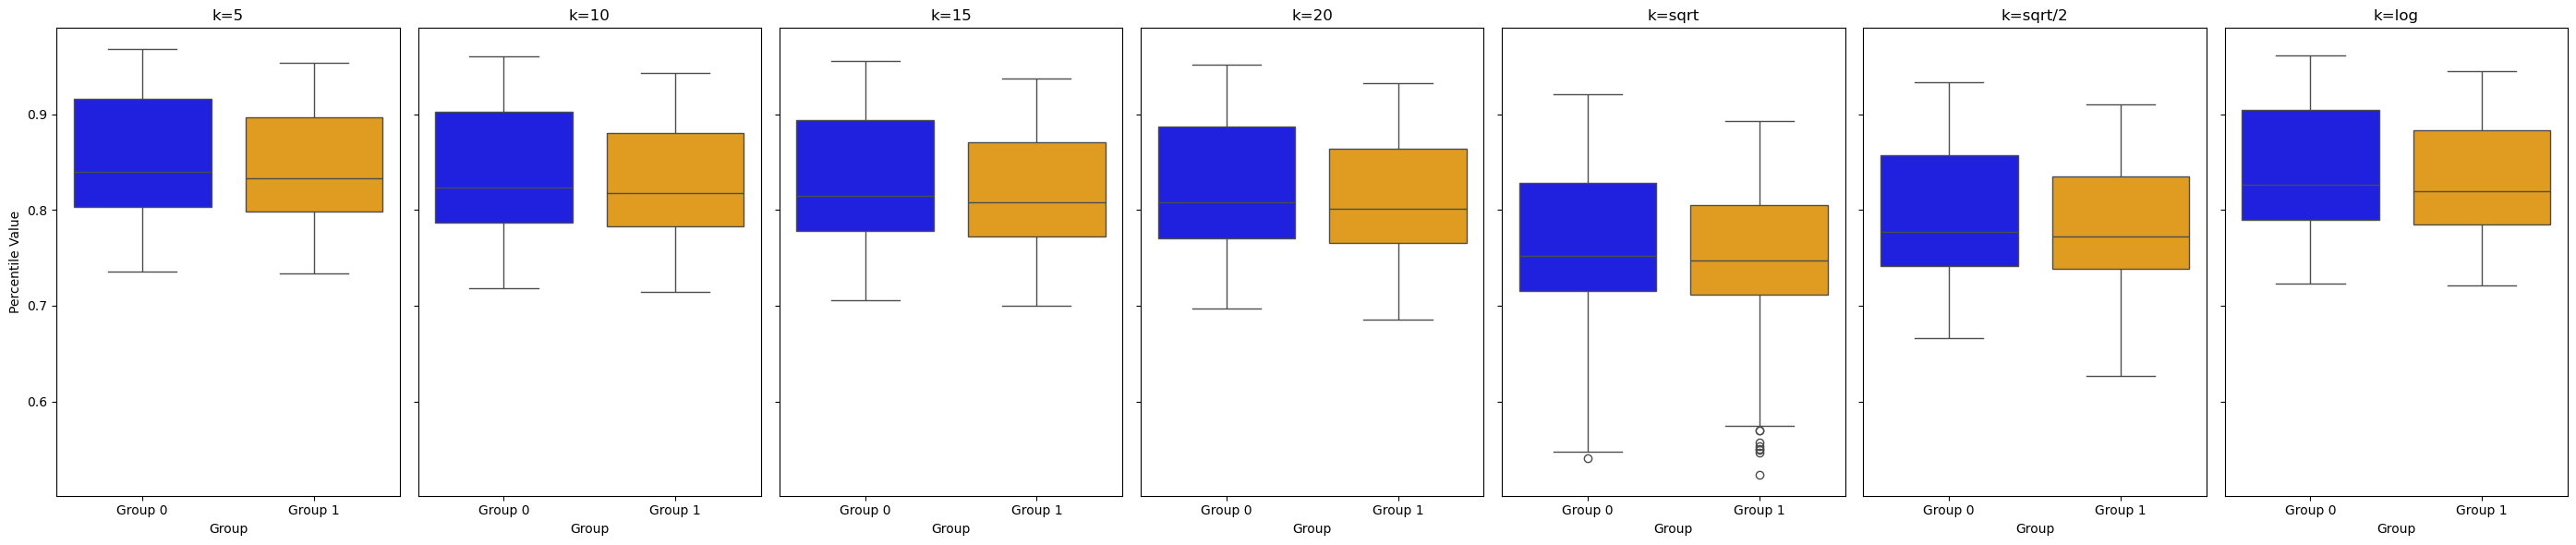

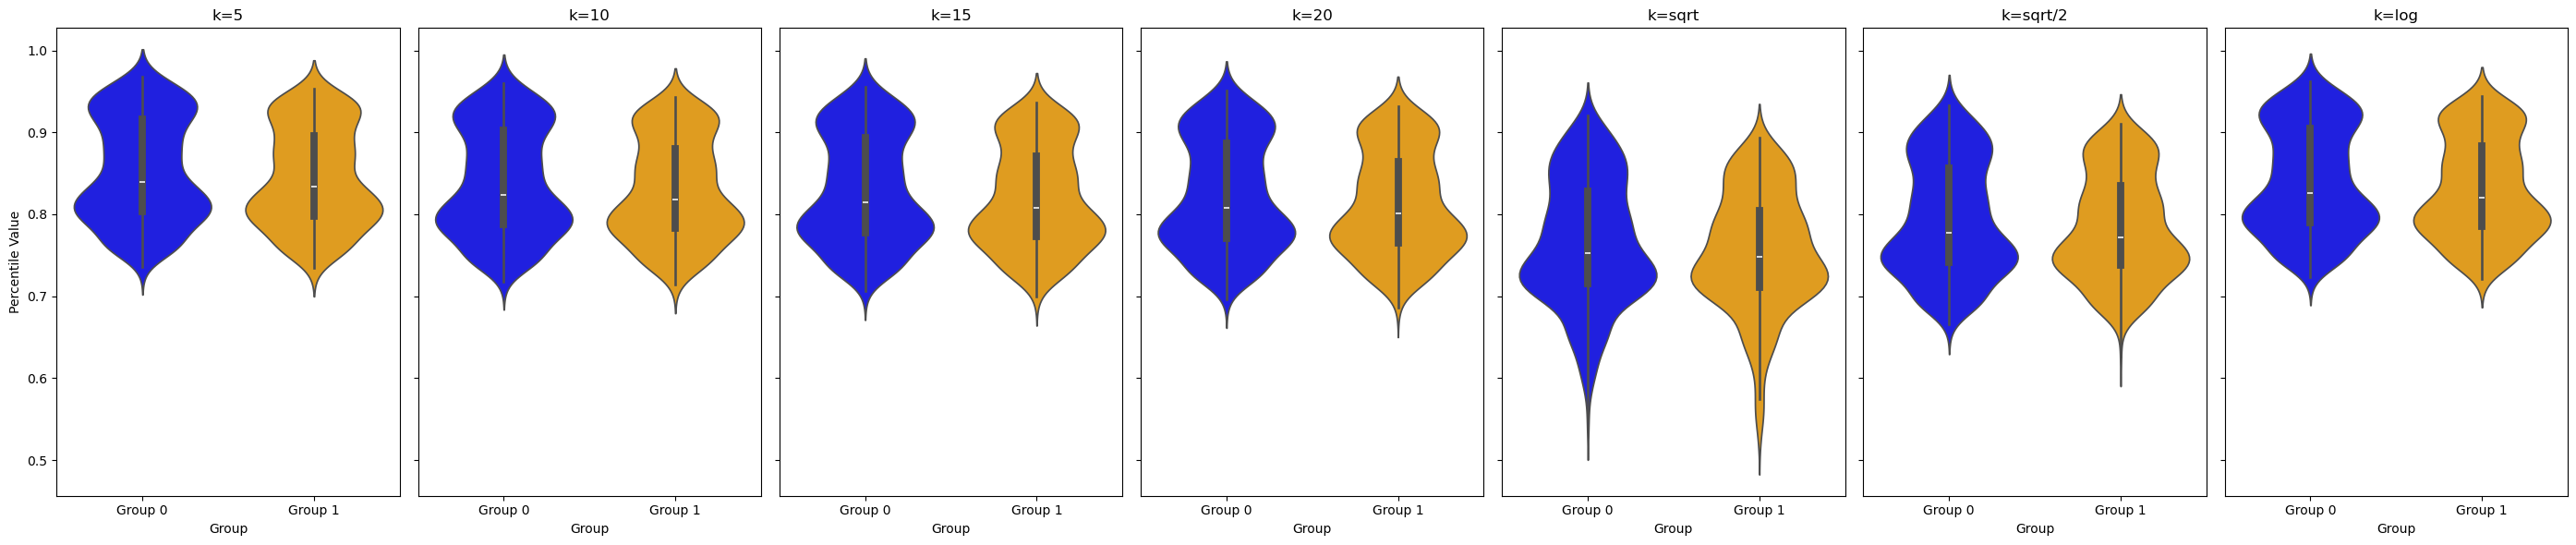

In [52]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
run_plots(group0, group1, k_values)

In [ ]:
group0,group1 = load_json_groups(colon_path)
run_plots(group0, group1, k_values)

In [ ]:
group0,group1 = load_json_groups(kidney_path)
run_plots(group0, group1, k_values)

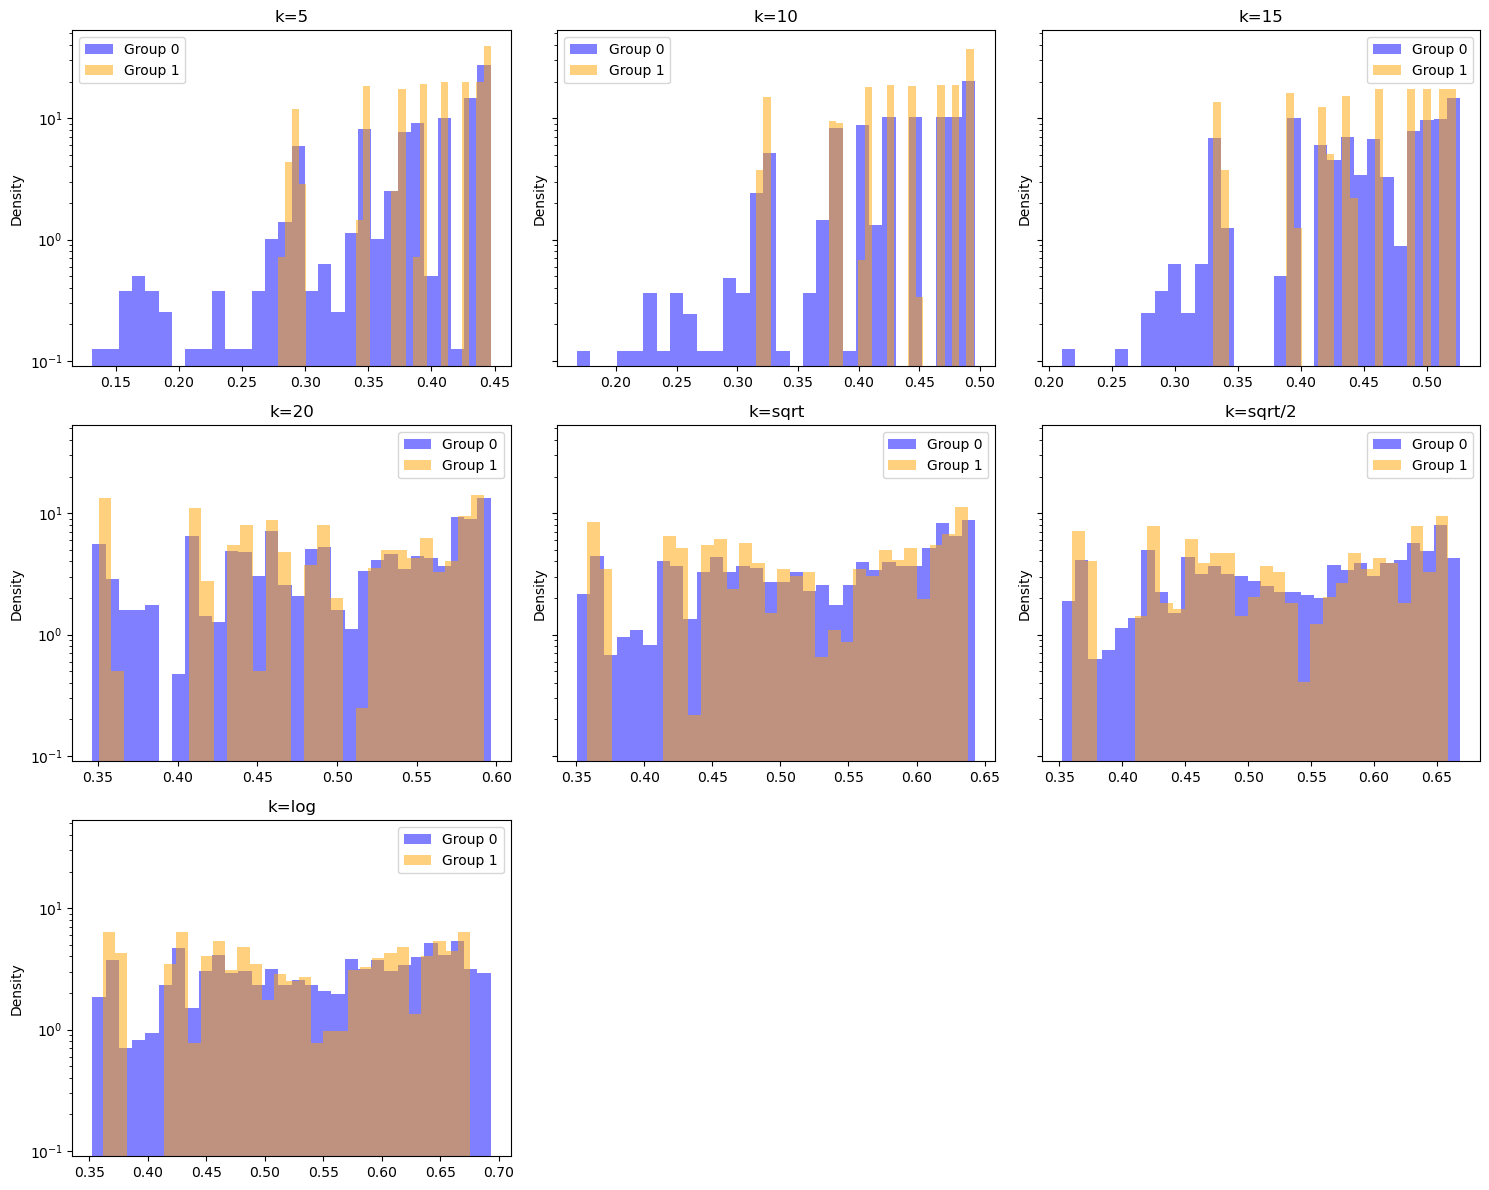

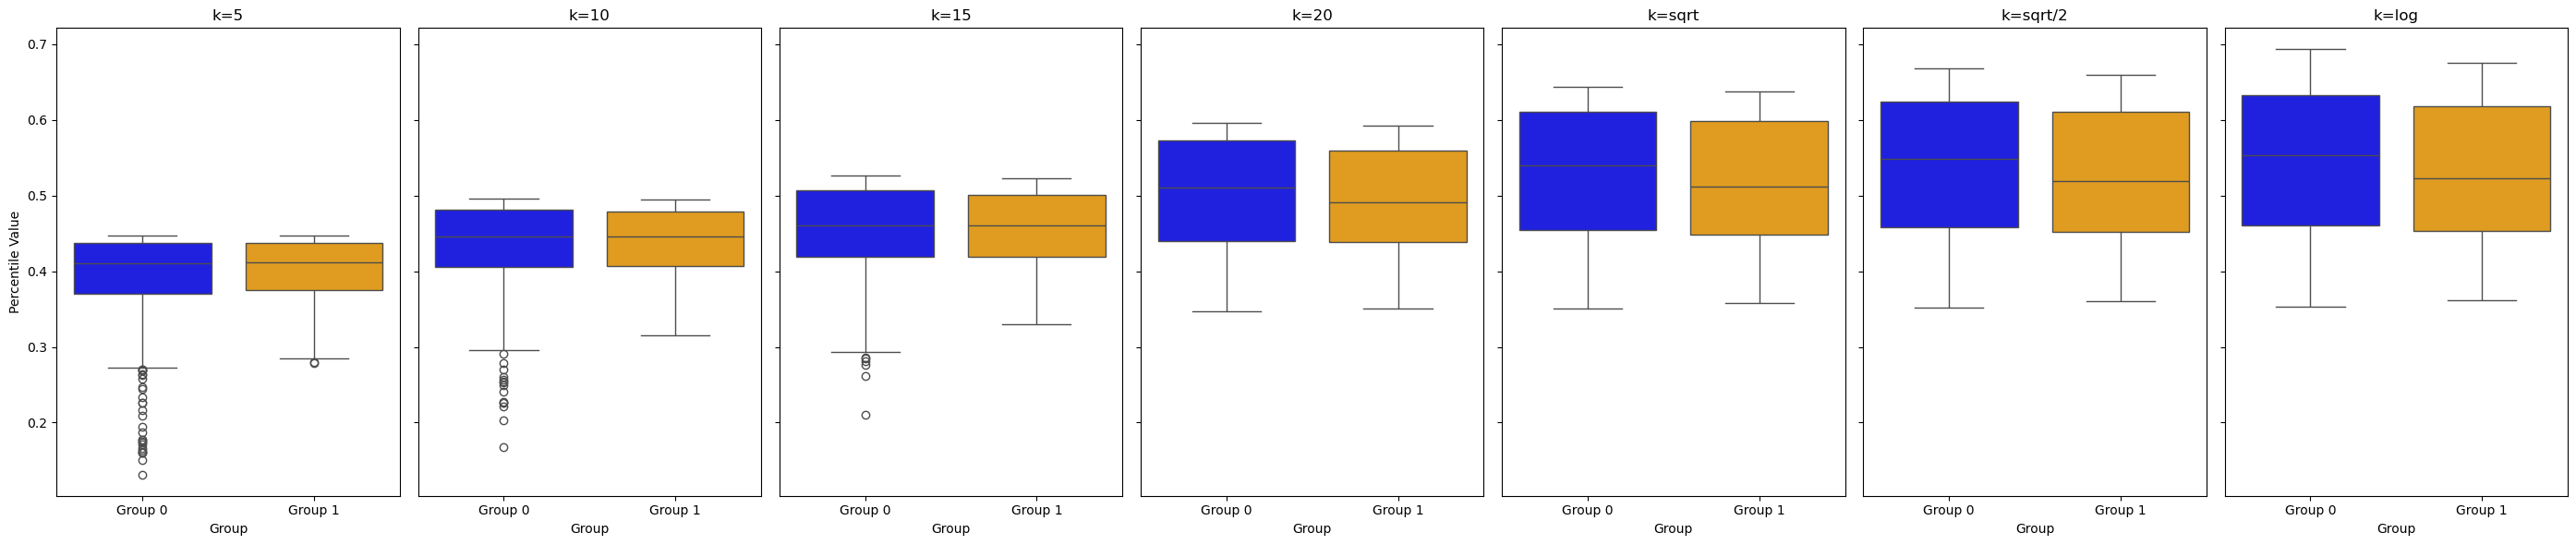

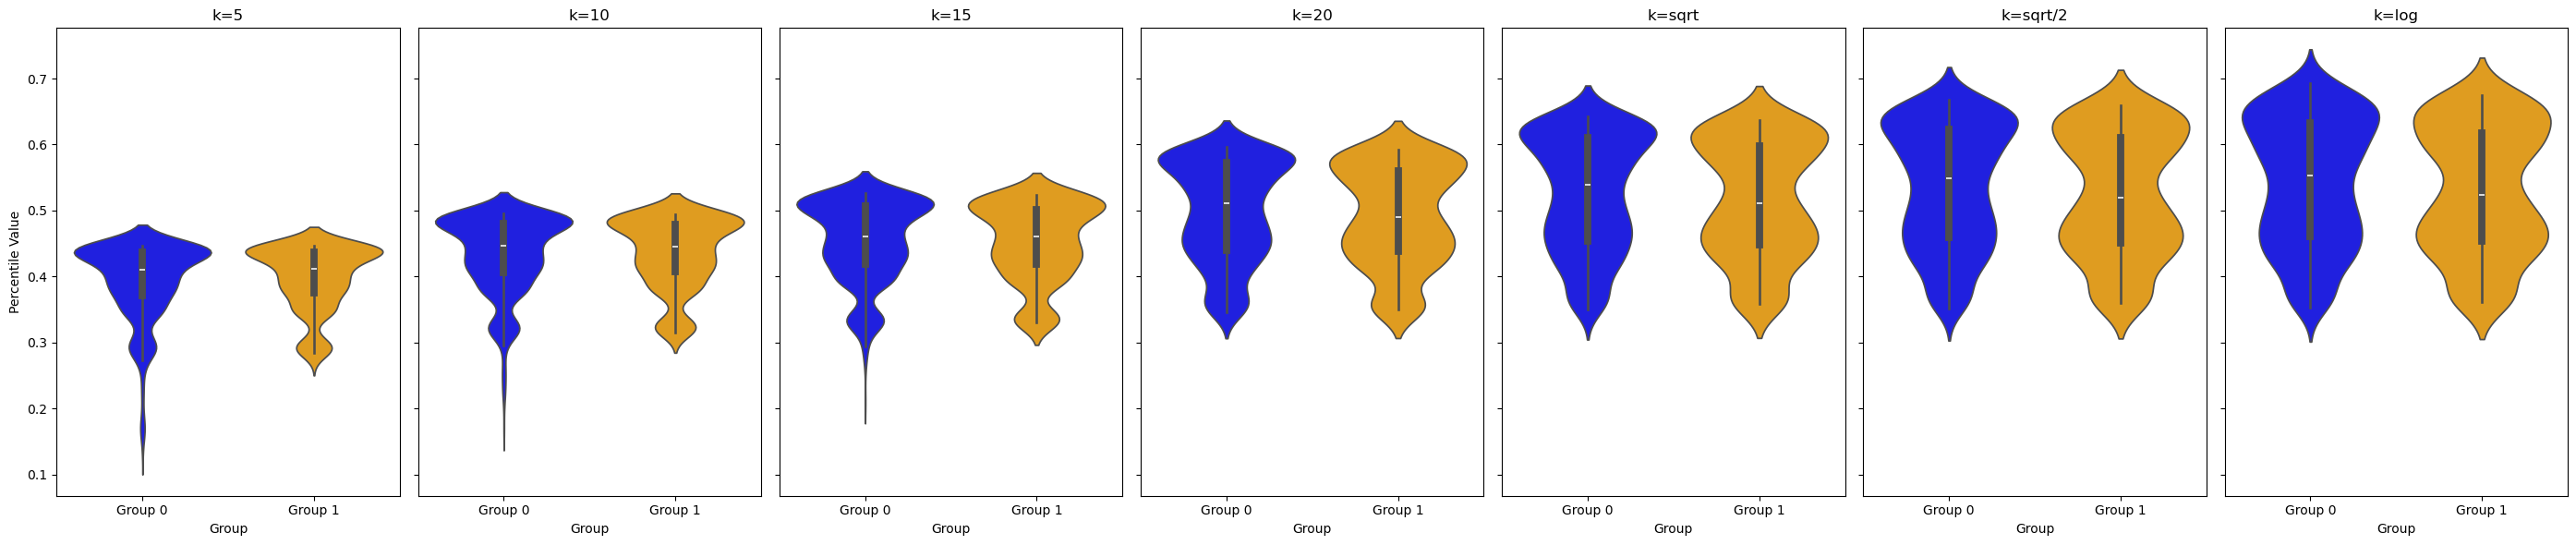

In [44]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json", perc_type='radius')
run_plots(group0, group1, k_values)

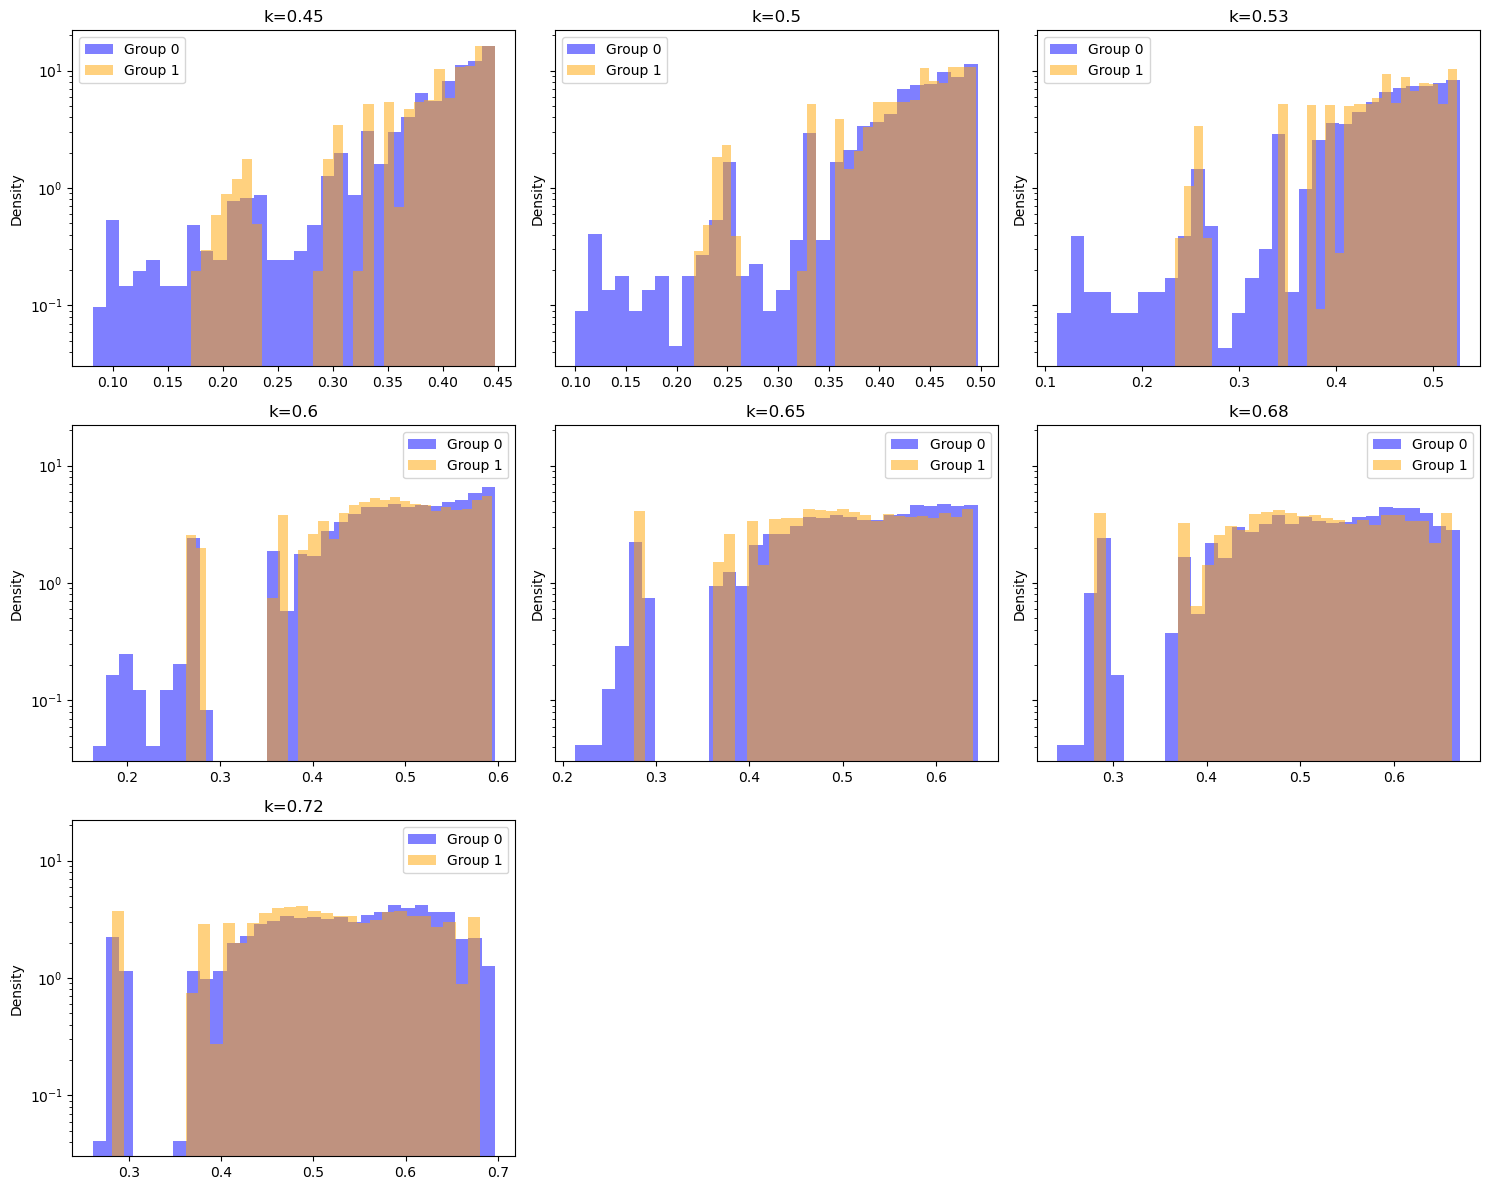

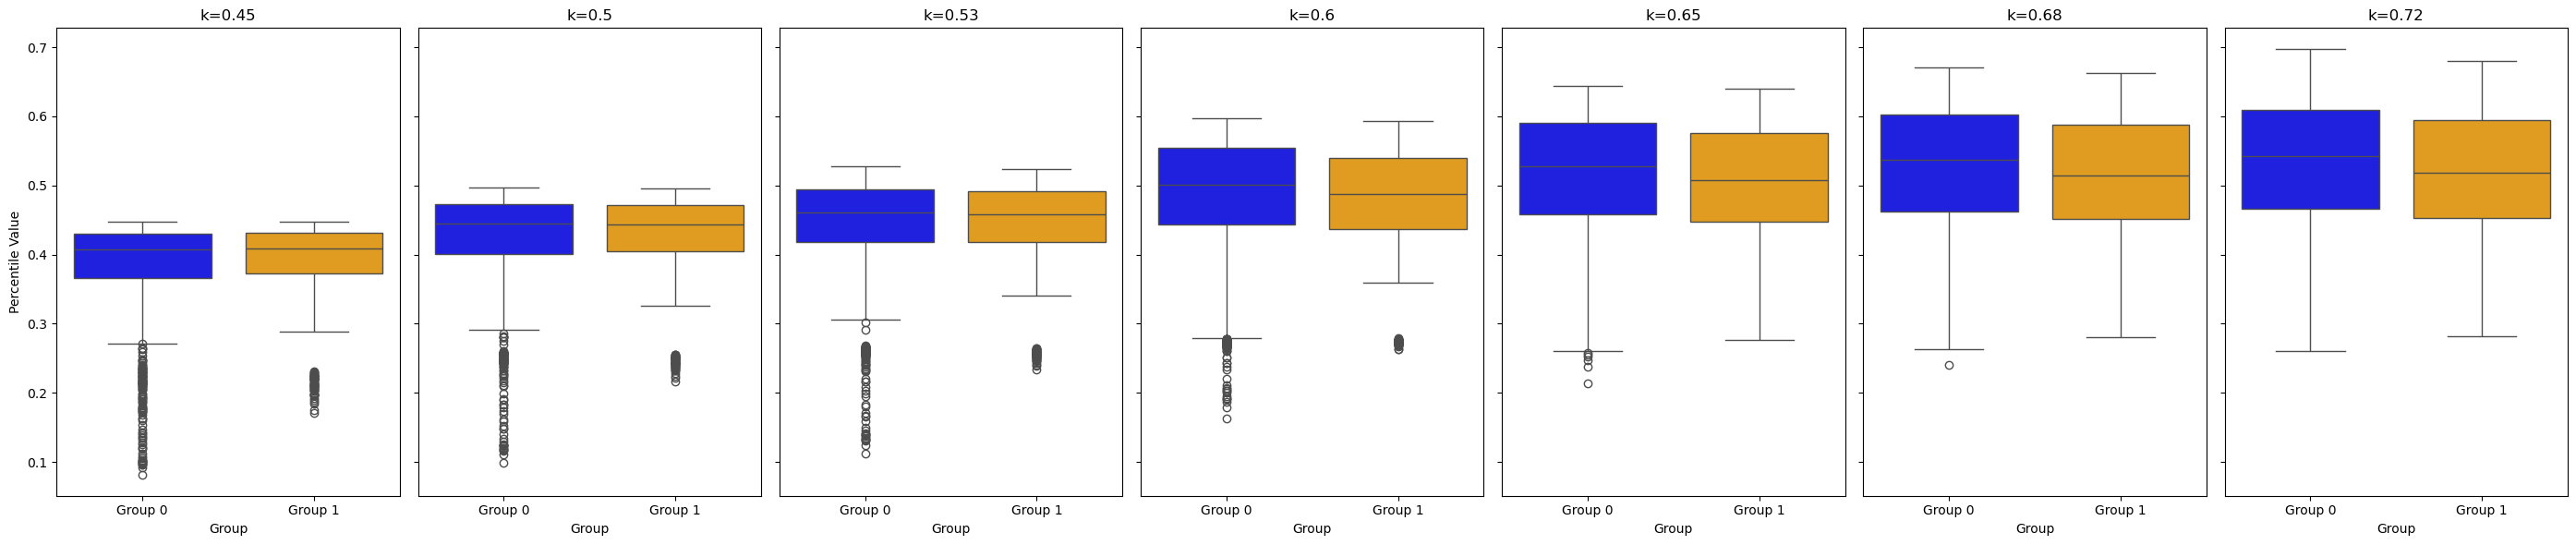

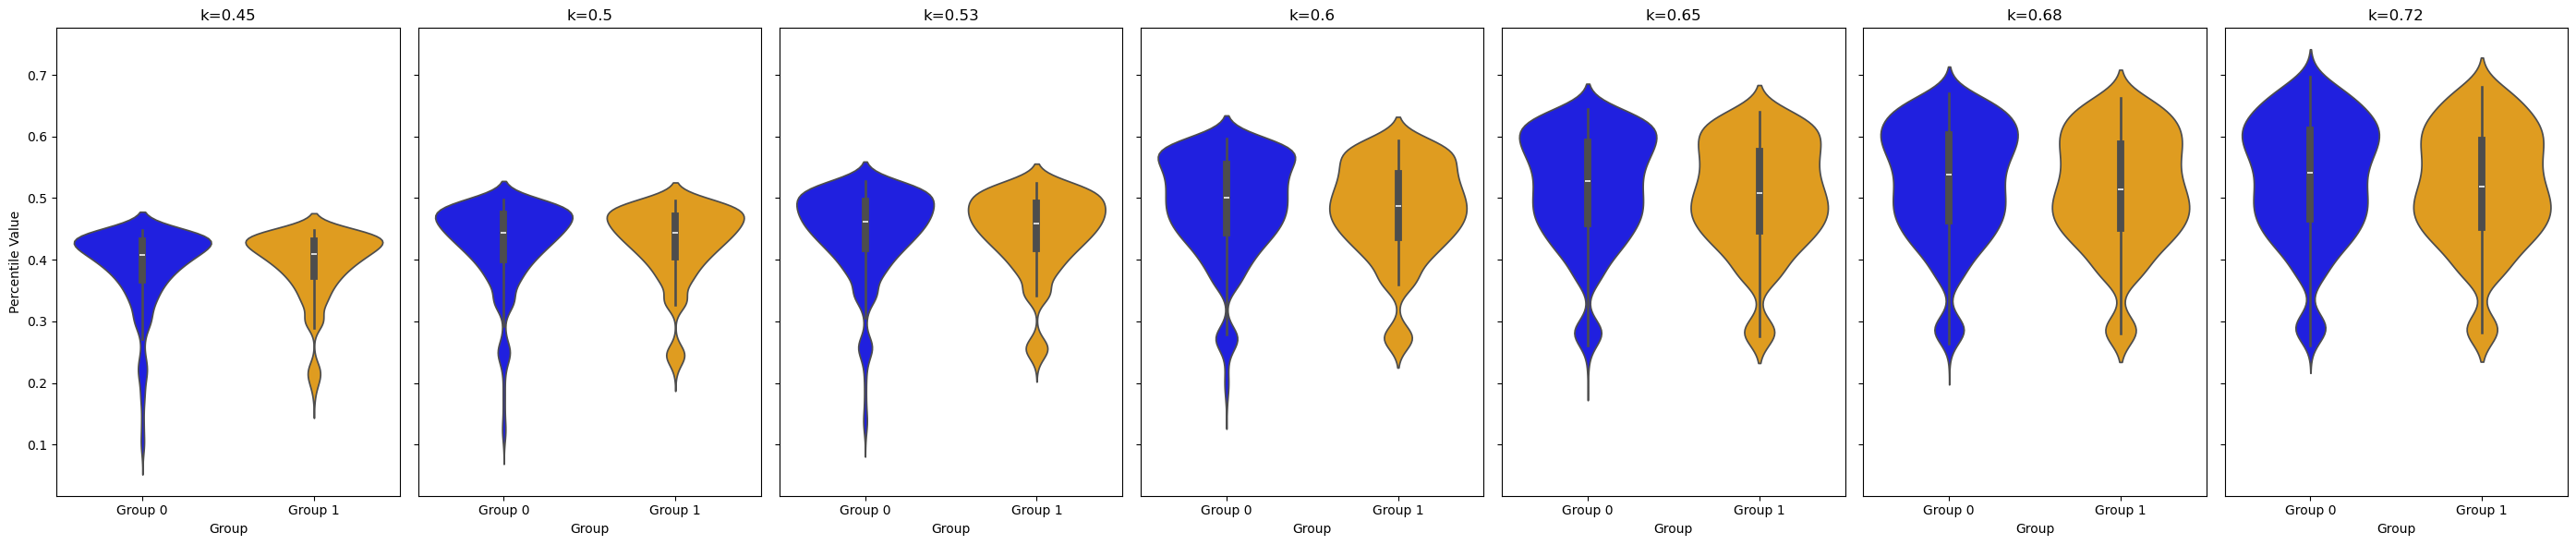

In [47]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_every_other_5.json", perc_type='radius')
run_plots(group0, group1, r_values)

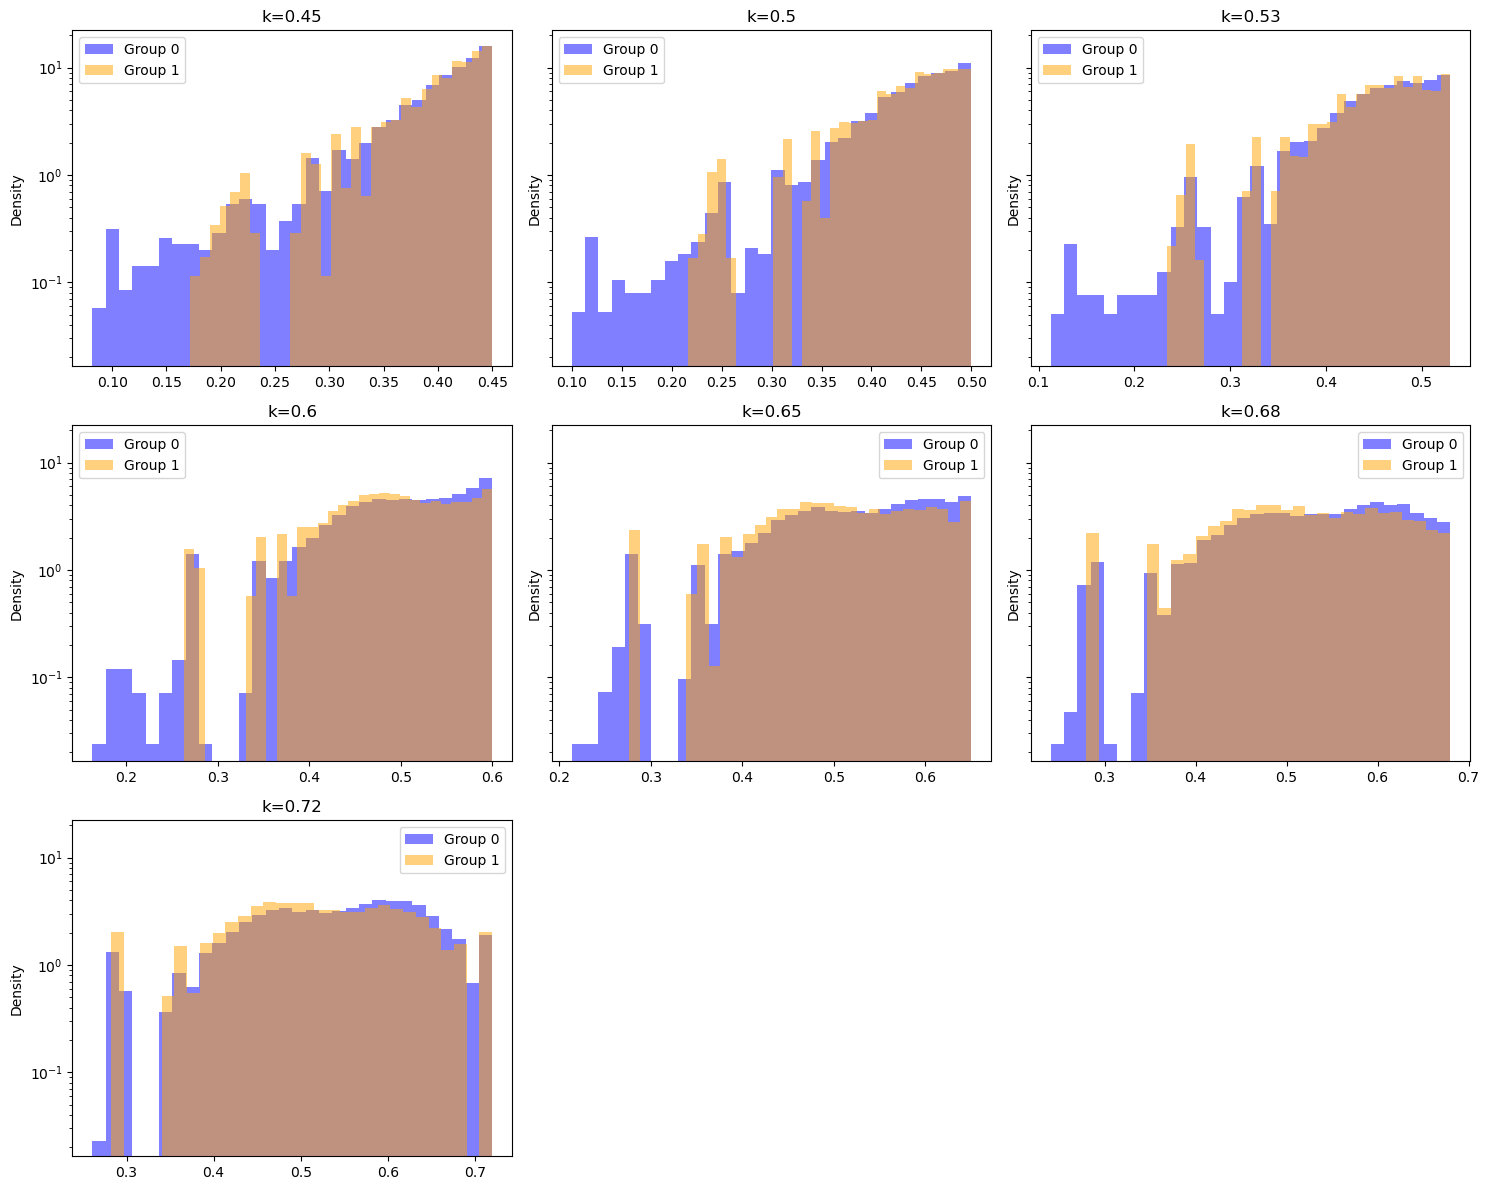

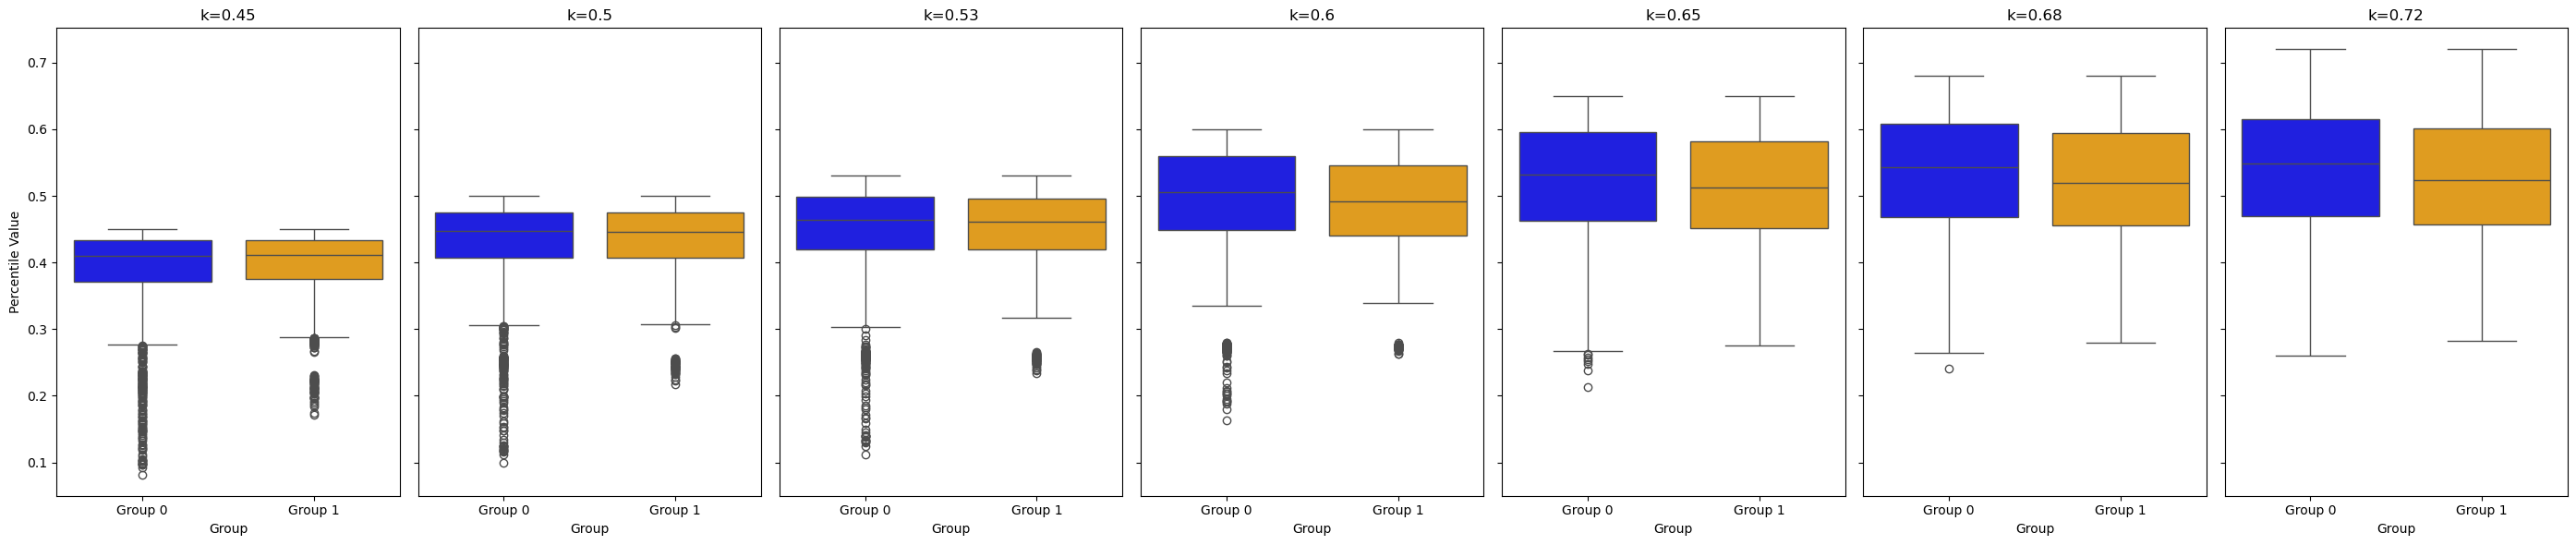

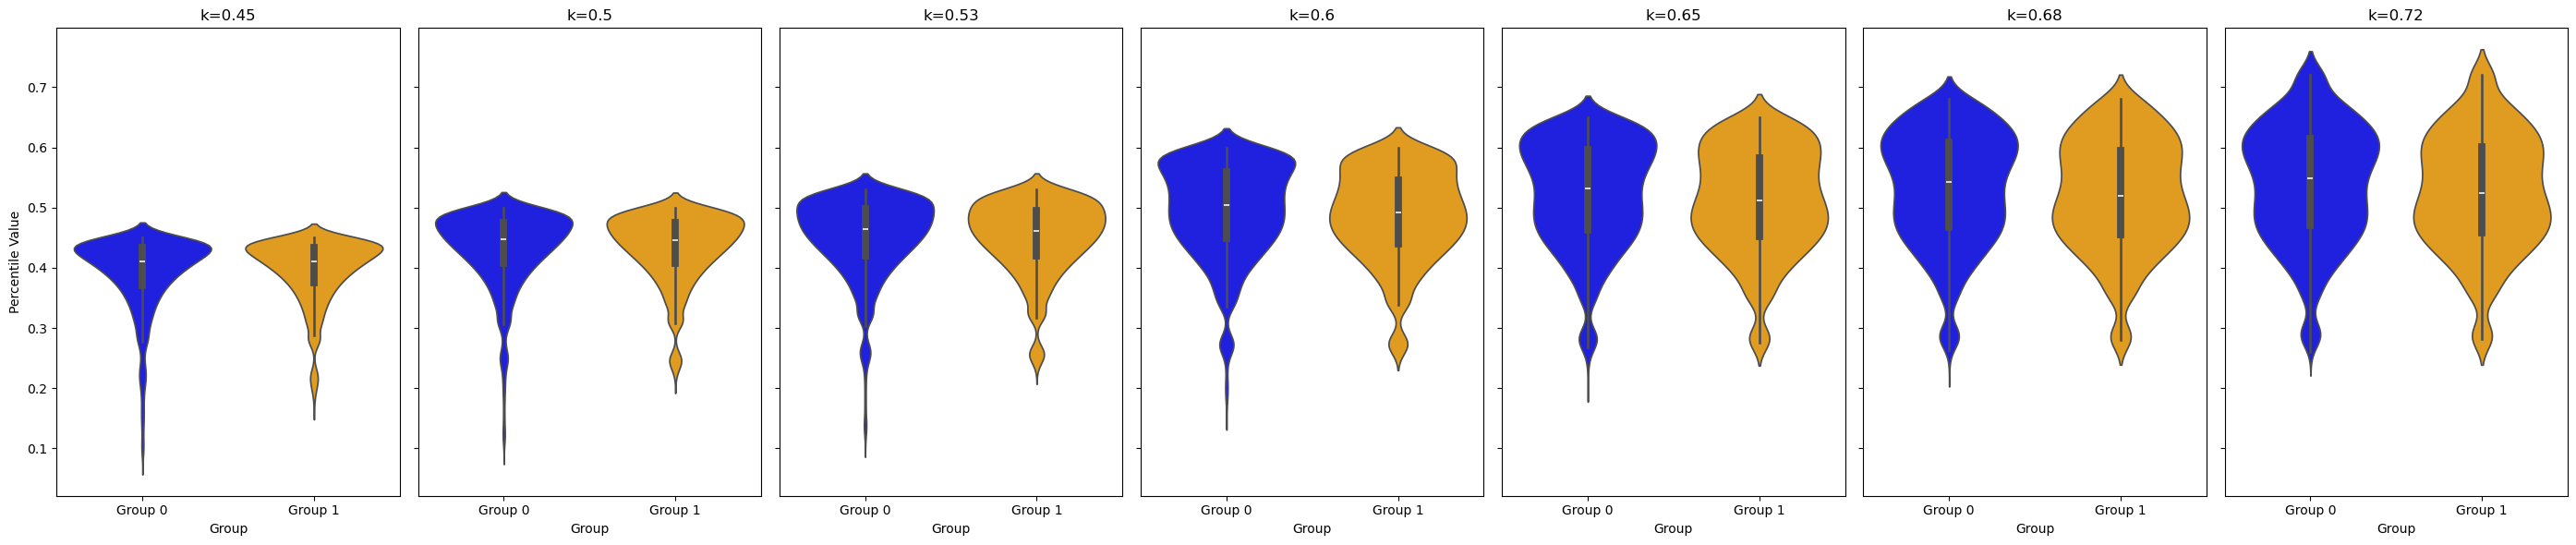

In [51]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_every_other_3.json", perc_type='radius')
run_plots(group0, group1, r_values)

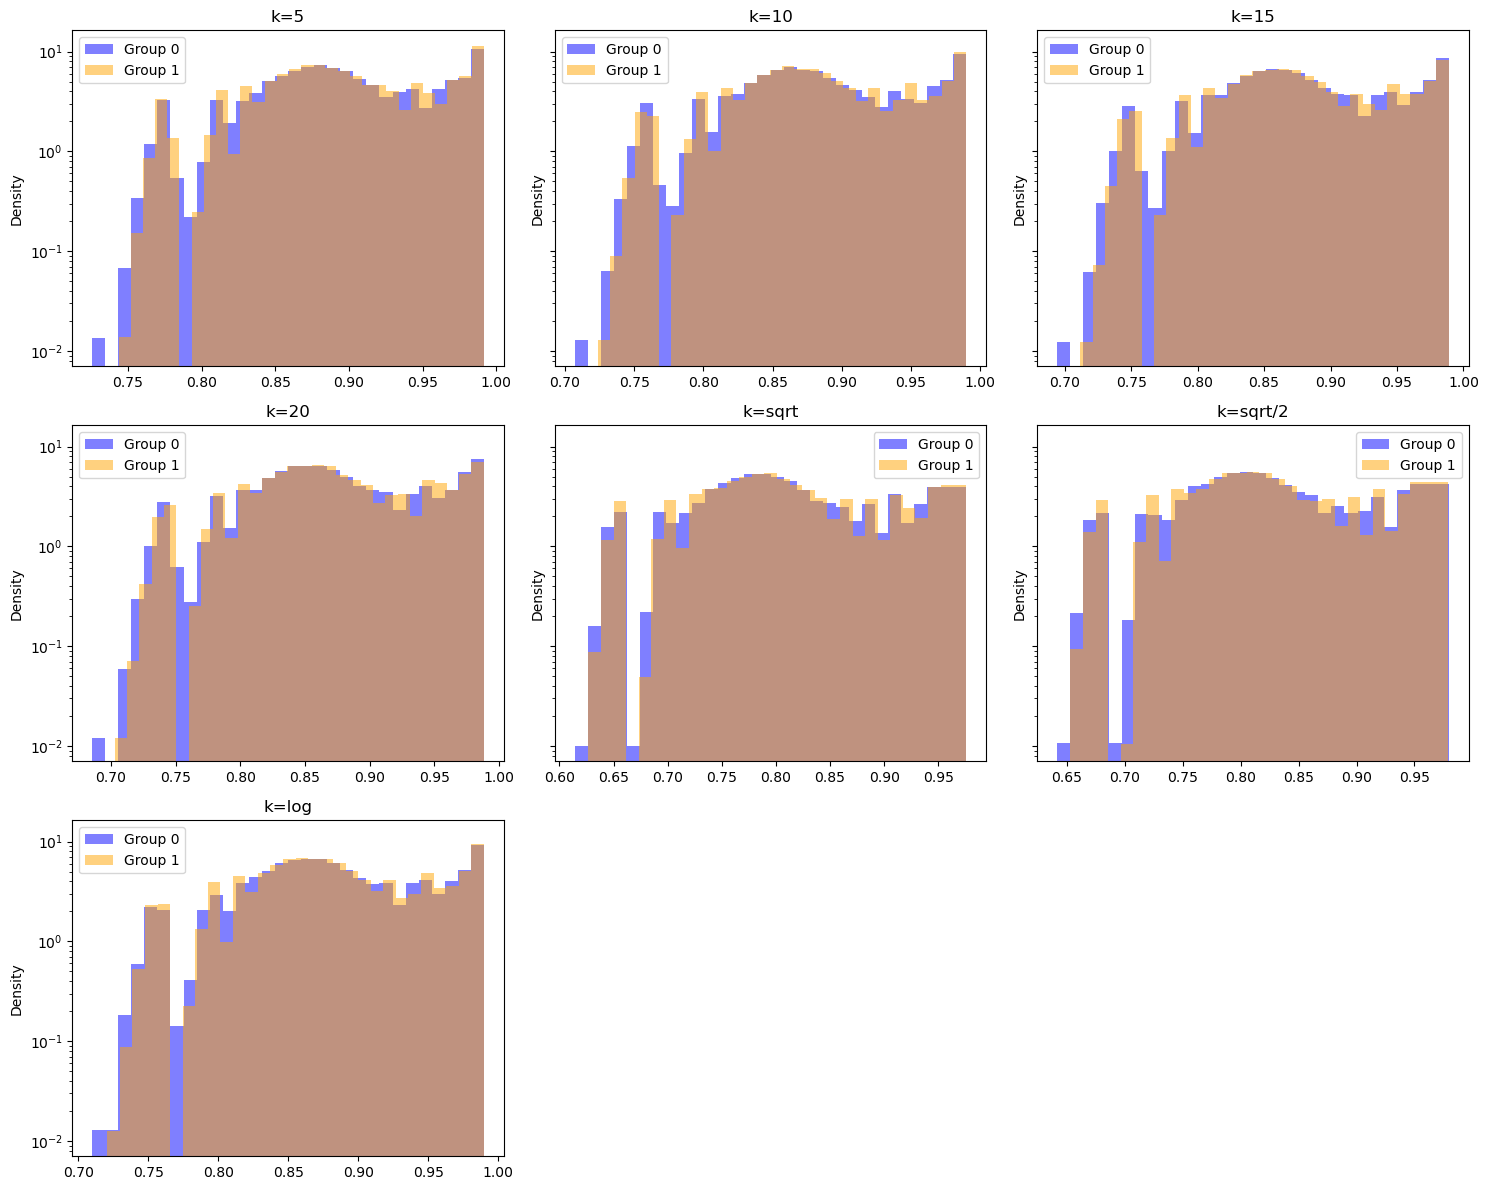

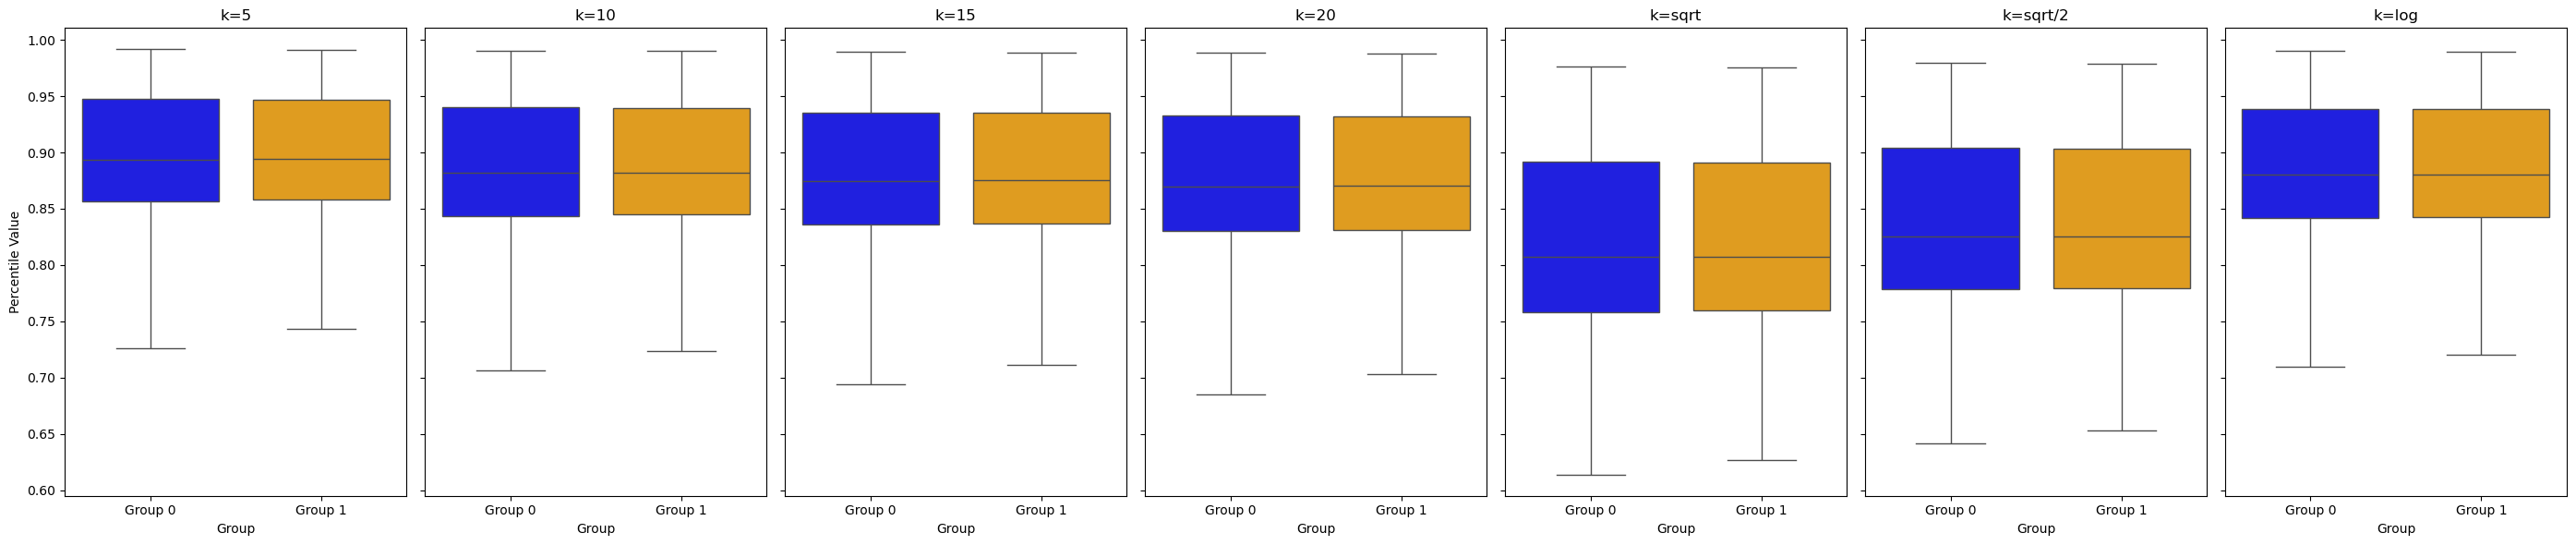

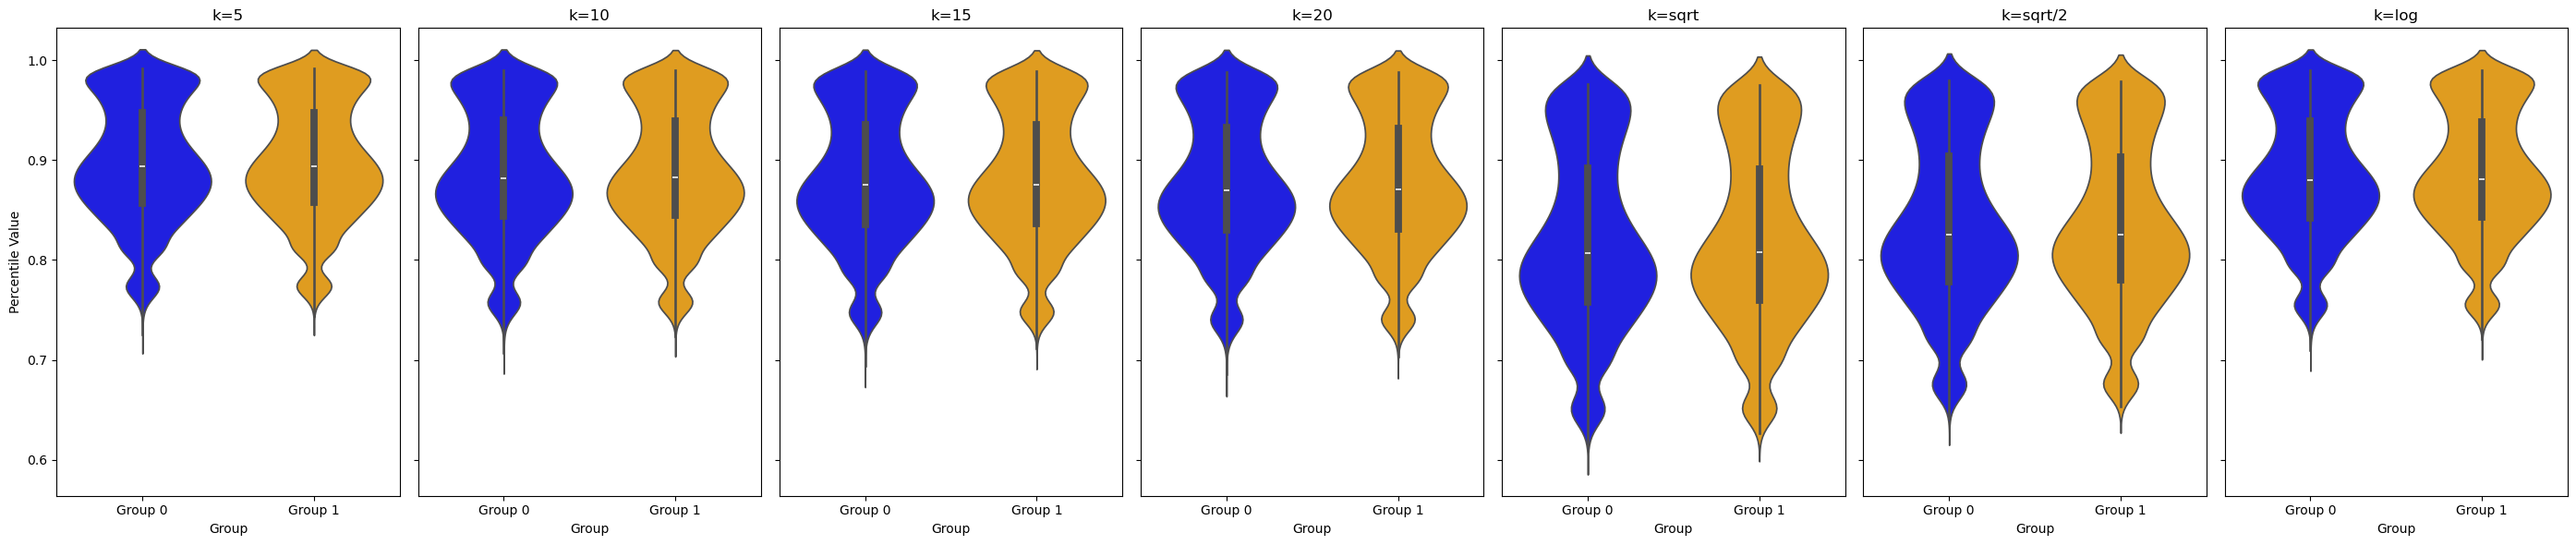

In [40]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/corona_percentiles/checkpoints/perc_faiss_cos_every5_1-816.json")
run_plots(group0, group1, k_values)

IndexError: list index out of range

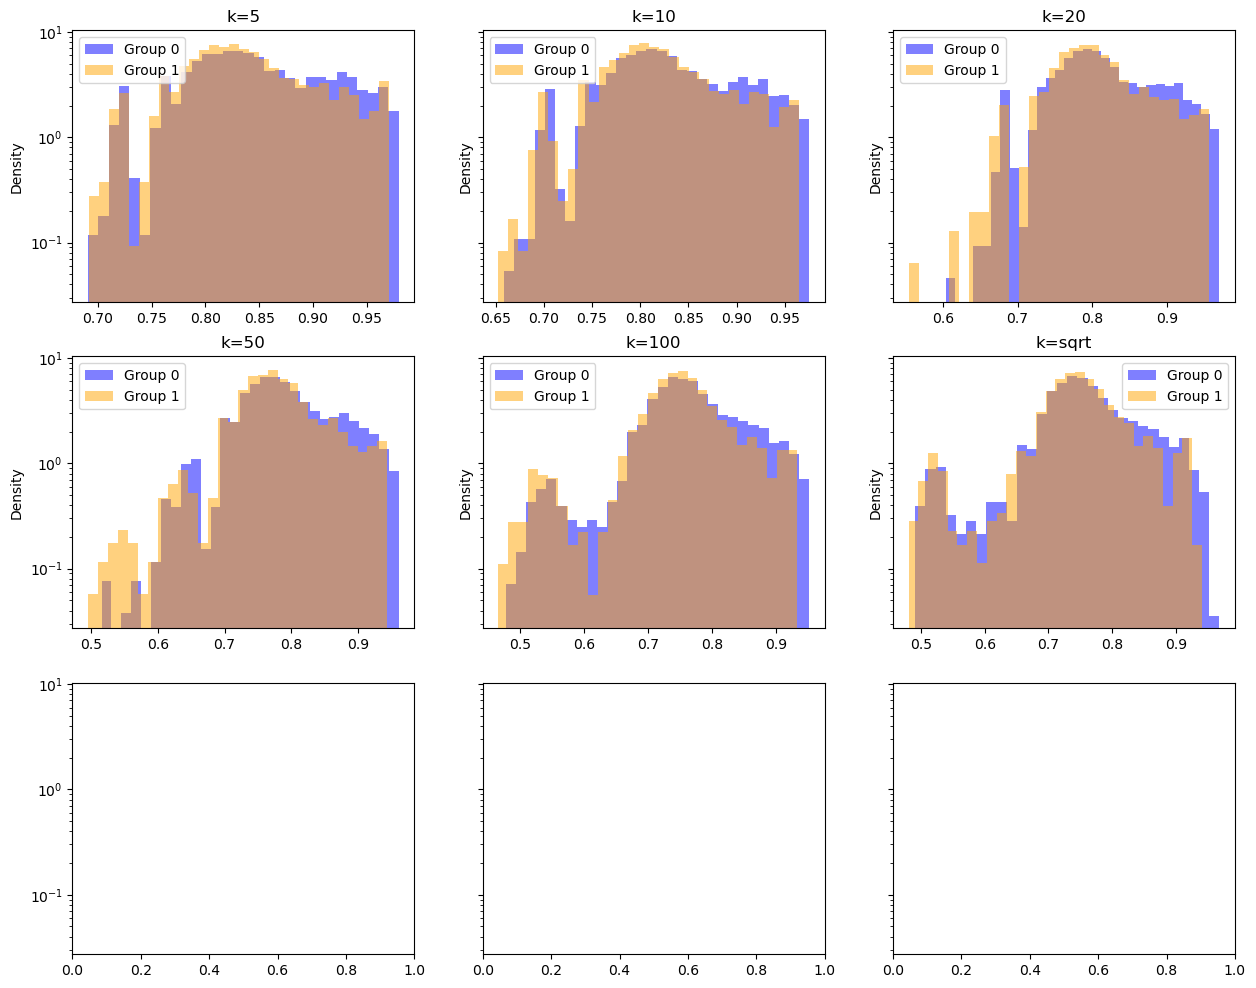

In [31]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_every5_newk.json")
run_plots(group0, group1, [5, 10, 20, 50, 100, 'sqrt', 'sqrt/2', 'log'])

## Analyzing Outlines

In [ ]:
def load_json_and_extract_features_as_lists(json_path, stack=False):
    """Load JSON file, extract statistical features, and return structured lists of lists for each group."""
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    group_0 = []
    group_1 = []
    
    for sample_name, percentiles_dict in data.items():
        # Convert the JSON data structure to a list of lists for each sample
        sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]  # Convert each k-value dictionary entry to a list

        # Extract statistical features for this sample
        features_df = extract_statistical_features_from_percentiles([sample_data], list(percentiles_dict.keys()), stack)

        # Initialize lists for each feature across all k values
        iqr_values = ['iqr']
        lower_tail_range_values = ['lower_tail_range']
        upper_tail_range_values = ['upper_tail_range']
        lower_tail_ratio_values = ['lower_tail_ratio']
        upper_tail_ratio_values = ['upper_tail_ratio']
        percentile_90_10_diff_values = ['percentile_90_10_diff']
        percentile_95_5_diff_values = ['percentile_95_5_diff']
        
        # Populate each feature list with values from all k's in the original JSON order
        for col in features_df.columns[1:]:  # Skip 'Sample' column
            if 'iqr' in col:
                iqr_values.append(features_df[col].iloc[0])
            elif 'lower_tail_range' in col:
                lower_tail_range_values.append(features_df[col].iloc[0])
            elif 'upper_tail_range' in col:
                upper_tail_range_values.append(features_df[col].iloc[0])
            elif 'lower_tail_ratio' in col:
                lower_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'upper_tail_ratio' in col:
                upper_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'percentile_90_10_diff' in col:
                percentile_90_10_diff_values.append(features_df[col].iloc[0])
            elif 'percentile_95_5_diff' in col:
                percentile_95_5_diff_values.append(features_df[col].iloc[0])

        # Combine all feature lists for this sample
        sample_features = [
            iqr_values,
            lower_tail_range_values,
            upper_tail_range_values,
            lower_tail_ratio_values,
            upper_tail_ratio_values,
            percentile_90_10_diff_values,
            percentile_95_5_diff_values,
        ]
        
        # Append to the appropriate group based on sample_name
        if any(tag in sample_name for tag in low_group_tags):
            group_0.append(sample_features)
        elif any(tag in sample_name for tag in high_group_tags):
            group_1.append(sample_features)
    
    return group_0, group_1

    
def extract_statistical_features_from_percentiles(samples, k_labels, stack=False):
    """Extract statistical metrics from specified percentiles for each k value in each sample.
    
    Parameters:
    - samples: List of samples, where each sample is a list of lists.
               Each inner list has the format [k_value, p5, p15, p25, p35, p50, p70, p80, p90, p95].
    - k_labels: List of labels for each k value (e.g., [5, 10, 15, 20, 'sqrt', 'sqrt/2', 'log']).
    - stack: if another percentile vector for the same k value was concatanated(for example: PCA values)
    Returns:
    - DataFrame of statistical features for each sample and k value.
    """
    feature_list = []

    for sample_idx, sample in enumerate(samples):
        sample_features = {}
        sample_features['Sample'] = sample_idx
        
        for k_index, k_label in enumerate(k_labels):
            # Extract the provided percentiles for this k value
            percentiles = sample[k_index][1:]  # Exclude the k_value itself, just get percentiles
            
            if stack:
                perc = []
                half_size = len(percentiles) // 2
                for i in range (half_size):
                    value = 0.7 * percentiles[i] + 0.3 * percentiles[half_size + i]
                    perc.append(value)
                p5, p15, p25, p35, p50, p70, p80, p90, p95 = perc
            else:
                # Map the percentiles to variables for clarity
                p5, p15, p25, p35, p50, p70, p80, p90, p95 = percentiles

            # Calculate key features
            iqr = p70 - p25  # Interquartile Range (estimated as 75-25 range)
            lower_tail_range = p25 - p5  # Approximate lower tail range as 25-5
            upper_tail_range = p95 - p70  # Approximate upper tail range as 95-75
            
            # Calculate ratios
            lower_tail_ratio = lower_tail_range / iqr if iqr != 0 else 0
            upper_tail_ratio = upper_tail_range / iqr if iqr != 0 else 0
            
            # Additional quantile differences
            percentile_90_10_diff = p90 - p15  # 90th - 10th percentile difference
            percentile_95_5_diff = p95 - p5    # 95th - 5th percentile difference

            # Store features in the dictionary with keys indicating k value and metric
            sample_features[f'k={k_label}_iqr'] = iqr
            sample_features[f'k={k_label}_lower_tail_range'] = lower_tail_range
            sample_features[f'k={k_label}_upper_tail_range'] = upper_tail_range
            sample_features[f'k={k_label}_lower_tail_ratio'] = lower_tail_ratio
            sample_features[f'k={k_label}_upper_tail_ratio'] = upper_tail_ratio
            sample_features[f'k={k_label}_percentile_90_10_diff'] = percentile_90_10_diff
            sample_features[f'k={k_label}_percentile_95_5_diff'] = percentile_95_5_diff
        
        # Add this sample's features to the list
        feature_list.append(sample_features)
    
    # Convert the list of feature dictionaries to a DataFrame
    feature_df = pd.DataFrame(feature_list)
    return feature_df

In [ ]:
feature_values = ["iqr", "lower_tail_range", "upper_tail_range", "lower_tail_ratio", "upper_tail_ratio", "percentile_90_10_diff", "percentile_95_5_diff"]


In [ ]:
samples_group_0_ovarian, samples_group_1_ovarian = load_json_and_extract_features_as_lists(ovarian_path_outlines)

In [ ]:
run_plots(samples_group_0_ovarian, samples_group_1_ovarian, feature_values)

In [ ]:
samples_group_0_colon, samples_group_1_colon = load_json_and_extract_features_as_lists(colon_path_outlines, stack=True)

In [ ]:
run_plots(samples_group_0_colon, samples_group_1_colon, feature_values)

In [ ]:
samples_group_0_kidney, samples_group_1_kidney = load_json_and_extract_features_as_lists(kidney_path_outlines, stack=False)

In [ ]:
run_plots(samples_group_0_kidney, samples_group_1_kidney, feature_values)

## ML

In [ ]:
def prepare_data_from_groups(group_0, group_1, average_vectors=False, vector_indices=None):
    """
    Prepare data for machine learning algorithms using extracted features from two groups.

    Parameters:
    - group_0: List of lists for Group 0, where each inner list represents a patient.
    - group_1: List of lists for Group 1, where each inner list represents a patient.
    - average_vectors: If True, averages the vectors across k values instead of concatenating.
    - vector_indices: Optional list of indices specifying which features to include.

    Returns:
    - X_train, X_test, y_train, y_test: Prepared training and testing data and labels.
    """
    data = []
    labels = []

    # Define the maximum length for padding
    max_length = 0

    # Combine groups and assign labels
    combined_data = group_0 + group_1
    combined_labels = [0] * len(group_0) + [1] * len(group_1)

    # Find the maximum length needed for padding based on selected indices
    if not average_vectors:
        if vector_indices is not None:
            # Calculate max length based only on selected features
            max_length = max(len(np.concatenate([patient_features[i][1:] for i in vector_indices if i < len(patient_features)]))
                            for patient_features in combined_data)
        else:
            # Calculate max length based on all features if no indices are specified
            max_length = max(len(np.concatenate([feature[1:] for feature in patient_features])) 
                            for patient_features in combined_data)

    for patient_features, label in zip(combined_data, combined_labels):
        # Extract values for each feature (ignore the feature names)
        vectors = [feature[1:] for feature in patient_features]
        
        if average_vectors:
            # Calculate the mean across all k values for each feature
            avg_vector = np.mean(np.array(vectors), axis=0)
            data.append(avg_vector)
        else:
            # Select specific feature indices if provided
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_features = np.concatenate(selected_vectors)
            else:
                flattened_features = np.concatenate(vectors)
            
            # Pad the concatenated features to match the max length of selected features
            padded_features = np.pad(flattened_features, (0, max_length - len(flattened_features)), 'constant')
            data.append(padded_features)

            # Append the label
            labels.append(label)

    # Convert data and labels to arrays
    data = np.array(data)
    labels = np.array(labels)

    # # Separate indices for each label
    # indices_label_0 = np.where(labels == 0)[0]
    # indices_label_1 = np.where(labels == 1)[0]

    # # Randomly select 49 samples from label 0
    # np.random.seed(42)  # Set seed for reproducibility
    # selected_indices_label_0 = np.random.choice(indices_label_0, 49, replace=False)

    # # Combine selected indices from both labels
    # balanced_indices = np.concatenate([selected_indices_label_0, indices_label_1])

    # # Create balanced data and labels based on the selected indices
    # data_balanced = data[balanced_indices]
    # labels_balanced = labels[balanced_indices]

    # # Split balanced data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(data_balanced, labels_balanced, test_size=0.2, stratify=labels_balanced, random_state=42)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

    # Standardize the feature values
    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # # Verify the balance in the training set - REMOVE LATER
    # print("Training set label distribution:", np.bincount(y_train))
    # print("Test set label distribution:", np.bincount(y_test))

    return X_train, X_test, y_train, y_test

In [ ]:
# Generate descriptive feature names
feature_names = [f"{feature}_{k}" for feature in feature_values for k in k_values]

In [ ]:
samples_group_0_ovarian, samples_group_1_ovarian = load_json_and_extract_features_as_lists(ovarian_path_outlines)
samples_group_0_colon, samples_group_1_colon = load_json_and_extract_features_as_lists(colon_path_outlines)
samples_group_0_kidney, samples_group_1_kidney = load_json_and_extract_features_as_lists(kidney_path_outlines)

In [ ]:
X_train_col, X_test_col, y_train_col, y_test_col = prepare_data_from_groups(samples_group_0_kidney, samples_group_1_kidney)

In [ ]:
print(y_train_col, len(y_train_col))
print(y_test_col, len(y_test_col))

In [ ]:
results_col = []
models_col = []

In [ ]:
run_evaluation(X_train_col, X_test_col, y_train_col, y_test_col, k_value="all_k", results=results_col, models=models_col)

In [ ]:
train_and_evaluate_nn(X_train_col, X_test_col, y_train_col, y_test_col)

### Specific algorithms

In [ ]:
train_grid_mlp(X_train_col, X_test_col, y_train_col, y_test_col)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test_random_forest(X_train, X_test, y_train, y_test):
    random_forest = RandomForestClassifier(class_weight='balanced')
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Random Forest Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print("ROC-AUC:", roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))

test_random_forest(X_train_col, X_test_col, y_train_col, y_test_col)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test_xgboost(X_train, X_test, y_train, y_test):
    # model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(90 / 49))
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)

    # accuracy = accuracy_score(y_test, y_pred)
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # class_report = classification_report(y_test, y_pred)

    # print("XGBoost Results:")
    # print(f"Accuracy: {accuracy}")
    # print("Confusion Matrix:")
    # print(conf_matrix)
    # print("Classification Report:")
    # print(class_report)
    # print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    # Train the XGBoost model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(90 / 49))
    model.fit(X_train, y_train)

    # Predict probabilities for the positive class (1)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Set a custom threshold
    threshold = 0.5 # Example: lower the threshold to 0.4
    y_pred_adjusted = (y_probs >= threshold).astype(int)

    # Evaluate the adjusted predictions
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    class_report = classification_report(y_test, y_pred_adjusted)

    # Print evaluation results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

test_xgboost(X_train_col, X_test_col, y_train_col, y_test_col)

In [ ]:
train_grid_xgboost(X_train_col, X_test_col, y_train_col, y_test_col)

In [ ]:
train_grid_rf(X_train_col, X_test_col, y_train_col, y_test_col)


In [ ]:
train_grid_svm(X_train_col, X_test_col, y_train_col, y_test_col)
train_grid_mlp(X_train_col, X_test_col, y_train_col, y_test_col)

### Feature selection

In [ ]:
# Map each feature name to its full feature type explicitly
def extract_feature_type(feature_name):
    for feature_type in ['iqr', 'lower_tail_range', 'upper_tail_range', 'lower_tail_ratio', 
                 'upper_tail_ratio', 'percentile_90_10_diff', 'percentile_95_5_diff']:
        if feature_name.startswith(feature_type):
            return feature_type
    return "Unknown"  # In case a feature doesn't match (for debugging)

def test_rf(X_train, X_test, y_train, y_test, feature_names):
    random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print("Random Forest Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Feature importance
    feature_importances = random_forest.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(importance_df)

    # Use the full feature type for aggregation
    importance_df['Feature_Type'] = importance_df['Feature'].apply(extract_feature_type)
    aggregated_importance = importance_df.groupby('Feature_Type')['Importance'].sum().sort_values(ascending=False)
    
    print("\nAggregated Feature Importances by Feature Type:")
    print(aggregated_importance)

    # return top N features
    N = 5
    top_features = aggregated_importance.head(N).index.tolist()
    return top_features


top_featurs_colon = test_rf(X_train_col, X_test_col, y_train_col, y_test_col, feature_names)

In [ ]:
top_feat_col_indices = [feature_values.index(feature) for feature in top_featurs_colon]


In [ ]:
X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3 = prepare_data_from_groups(samples_group_0_colon, samples_group_1_colon, vector_indices=top_feat_col_indices)

In [ ]:
print(y_train_col_3, len(y_train_col_3))
print(y_test_col_3, len(y_test_col_3))

In [ ]:
run_evaluation(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3, k_value="all_k", results=[], models=[])

In [ ]:
train_grid_xgboost(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

### GO

In [ ]:
train_grid_rf(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test(X_train, X_test, y_train, y_test):
    # Define the Random Forest model with the specified parameters
    rf_model = RandomForestClassifier(
        bootstrap=False,
        max_depth=15,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=200,
        class_weight='balanced'  # Optional: Add class weighting if you have class imbalance
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print evaluation metrics
    print("Random Forest Results with Specified Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc}")

test(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

OVARIAN

In [ ]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = prepare_data_from_groups(samples_group_0_ovarian, samples_group_1_ovarian)

In [ ]:
results_ov = []
models_ov = []

In [ ]:
run_evaluation(X_train_ov, X_test_ov, y_train_ov, y_test_ov, k_value="all_k", results=results_ov, models=models_ov)

## Printing Samples

In [ ]:
def prepare_data_with_samples(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []
    sample_names = []  # To store sample names

    if average_vectors:
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name
    else:
        # Determine max_length based on selected vector indices
        if vector_indices is None:
            # No filtering, consider all values
            max_length = max(
                sum(len(v) for v in percentiles_dict.values()) 
                for percentiles_dict in percentiles_data.values()
            )
        else:
            # Compute max_length only for selected indices
            max_length = max(
                sum(len(v) for i, v in enumerate(percentiles_dict.values()) if i in vector_indices)
                for percentiles_dict in percentiles_data.values()
            )

        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())

            if vector_indices is not None:
                # Select only the requested vectors
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
            else:
                selected_vectors = vectors

            # Flatten the selected vectors
            flattened_percentiles = np.concatenate([np.array(v) for v in selected_vectors])

            # Pad only up to max_length for selected indices
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')

            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name

    data = np.array(data)
    labels = np.array(labels)
    sample_names = np.array(sample_names)

    # Include sample_names in the train-test split
    X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(data, labels, sample_names, test_size=0.2, stratify=labels)

    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Return train-test data, labels, and sample names
    return X_train, X_test, y_train, y_test, train_names, test_names

In [ ]:
all_results_samples, labels_dict_samples = load_results(colon_path, data_type=data_type)

X_train_samples, X_test_samples, y_train_samples, y_test_samples, train_names, test_names = prepare_data_with_samples(all_results_samples, labels_dict_samples)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score


def train_grid_rf_samples(X_train, X_test, y_train, y_test, test_names):
    # Create a pipeline with scaling and Random Forest
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('rf', RandomForestClassifier(class_weight='balanced'))  # Random Forest classifier
    ])

    # Define the parameter grid
    param_grid = {
        'rf__n_estimators': [20, 50, 100, 200, 500],
        'rf__max_depth': [5, 10, 15, 20],
        'rf__min_samples_split': [2, 5, 10, 15],
        'rf__min_samples_leaf': [1, 2, 4, 8],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=0)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy method Score from Grid Search:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Identify false negatives (True label = 1, Predicted label = 0)
    false_negative_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == 1 and pred == 0]
    false_negative_names = [test_names[i] for i in false_negative_indices]

    print("\nRandom Forest Results with Best Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    # Print false negative names
    print("\nFalse Negative Samples:")
    for name in false_negative_names:
        print(name)

In [ ]:
train_grid_rf_samples(X_train_samples, X_test_samples, y_train_samples, y_test_samples, test_names)

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb

def train_grid_xgboost_samples(X_train, X_test, y_train, y_test, test_names):
    # Define the parameter grid, including scale_pos_weight
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'scale_pos_weight': [1.5, 1.7, 1.8, 2.0]  # Adjusted based on class imbalance for colon (90/49)
    }

    # Initialize the XGBClassifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Initialize GridSearchCV, focusing on recall for label 1
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='balanced_accuracy', cv=3, n_jobs=-1, verbose=0)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Recall Score from Grid Search:", grid_search.best_score_)

    # Use the best model to make predictions on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the best model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Identify false negatives (True label = 1, Predicted label = 0)
    false_negative_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == 1 and pred == 0]
    false_negative_names = [test_names[i] for i in false_negative_indices]

    print("\nXGBoost Results with Best Parameters for Label 1 Recall:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    # Print false negative names
    print("\nFalse Negative Samples:")
    for name in false_negative_names:
        print(name)

In [ ]:
train_grid_xgboost_samples(X_train_samples, X_test_samples, y_train_samples, y_test_samples, test_names)

In [ ]:
def test_2(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []
    sample_names = []  # To store sample names

    if average_vectors:
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name

    data = np.array(data)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    
    # Initialize a DataFrame to store stats
    stats_df = pd.DataFrame(columns=["sample_name", "false_negative_appearances", "total_test_appearances", "average_balanced_accuracy"])

    # Create dictionaries to track counts and scores
    false_negative_counts = {}
    test_group_counts = {}
    balanced_accuracy_scores = {}

    # Initialize a list to store stats
    stats_list = []

    for i in range(15):
        print(f"\n####### round {i + 1} #######")
        
        # Include sample_names in the train-test split
        X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(
            data, labels, sample_names, test_size=0.2, stratify=labels
        )

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train and evaluate the model
        def train_grid_rf_samples(X_train, X_test, y_train, y_test, test_names):
            # Create a pipeline with scaling and Random Forest
            pipe = Pipeline([
                ('scaler', StandardScaler()),  # Feature scaling
                ('rf', RandomForestClassifier(class_weight='balanced'))  # Random Forest classifier
            ])

            # Define the parameter grid
            param_grid = {
                'rf__n_estimators': [20, 50, 100, 200, 500],
                'rf__max_depth': [5, 10, 15, 20],
                'rf__min_samples_split': [2, 5, 10, 15],
                'rf__min_samples_leaf': [1, 2, 4, 8],
                'rf__max_features': ['sqrt', 'log2'],
                'rf__bootstrap': [True, False]
            }

            # Initialize GridSearchCV with the pipeline and parameter grid
            cv = StratifiedKFold(n_splits=5, shuffle=True)
            grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=0)

            # Fit the model
            grid_search.fit(X_train, y_train)

            # Get the best parameters and best score
            print("Best Parameters:", grid_search.best_params_)
            print("Best Accuracy method Score from Grid Search:", grid_search.best_score_)

            # Predict using the best model
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)

            # Evaluate the balanced accuracy
            balanced_acc = balanced_accuracy_score(y_test, y_pred)

            # Identify false negatives (True label = 1, Predicted label = 0)
            false_negative_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == 1 and pred == 0]
            false_negative_names = [test_names[i] for i in false_negative_indices]

            # Update the false negative counts
            for name in false_negative_names:
                false_negative_counts[name] = false_negative_counts.get(name, 0) + 1

            # Update the total test group counts
            for name in test_names:
                if "high" in name:
                    test_group_counts[name] = test_group_counts.get(name, 0) + 1
                    # Track the balanced accuracy for each sample
                    if name not in balanced_accuracy_scores:
                        balanced_accuracy_scores[name] = []
                    balanced_accuracy_scores[name].append(balanced_acc)

        train_grid_rf_samples(X_train, X_test, y_train, y_test, test_names)

    # Create a summary DataFrame
    for sample_name in test_group_counts.keys():
        stats_list.append({
            "sample_name": sample_name,
            "false_negative_appearances": false_negative_counts.get(sample_name, 0),
            "total_test_appearances": test_group_counts[sample_name],
            "average_balanced_accuracy": sum(balanced_accuracy_scores.get(sample_name, [])) / len(balanced_accuracy_scores.get(sample_name, []))
        })

    # Convert the list to a DataFrame
    stats_df = pd.DataFrame(stats_list)    
    
    return stats_df


stats_df = test_2(all_results_samples, labels_dict_samples)

# Radius & KNN

## Concatanating Vectors

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_results_both(file_path, data_type='ovarian'):
    # Load JSON file
    with open(file_path, 'r') as f:
        all_results = json.load(f)

    # Create labels dictionary
    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            if sample_name.endswith("_H"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_OC"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'colon':
            if sample_name.endswith("_low"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_high"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'kidney':
            if "STA" in sample_name:
                labels_dict[sample_name] = 0
            elif "AR" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'corona':
            if "TCRB_M" in sample_name:
                labels_dict[sample_name] = 0
            elif "TCRB_F" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
    return all_results, labels_dict

def concatenate_percentiles(faiss_data, torch_data):
    """ Combines FAISS KNN and Torch Radius percentile data for common samples. """
    common_samples = set(faiss_data.keys()) & set(torch_data.keys())
    
    combined_data = {}
    for sample in common_samples:
        faiss_vectors = np.concatenate([np.array(v) for v in faiss_data[sample].values()])
        torch_vectors = np.concatenate([np.array(v) for v in torch_data[sample].values()])
        combined_data[sample] = np.concatenate((faiss_vectors, torch_vectors))
    
    return combined_data

def prepare_data_both(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    """Prepares data for ML models by flattening and normalizing percentile vectors."""
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array([np.array(v) for v in percentiles_dict.values()])
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        # Determine max_length based on selected vector indices
        if vector_indices is None:
            # No filtering, consider all values
            max_length = max(
                sum(len(v) for v in percentiles_dict.values()) 
                for percentiles_dict in percentiles_data.values()
            )
        else:
            # Compute max_length only for selected indices
            max_length = max(
                sum(len(v) for i, v in enumerate(percentiles_dict.values()) if i in vector_indices)
                for percentiles_dict in percentiles_data.values()
            )

        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())

            if vector_indices is not None:
                # Select only the requested vectors
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
            else:
                selected_vectors = vectors

            # Flatten the selected vectors
            flattened_percentiles = np.concatenate([np.array(v) for v in selected_vectors])

            # Pad only up to max_length for selected indices
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')

            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test



In [37]:

faiss_percentiles, labels_both = load_results_both("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_percentiles, _ = load_results_both("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")
combined_percentiles = concatenate_percentiles(faiss_percentiles, torch_percentiles)


In [38]:
X_train_both, X_test_both, y_train_both, y_test_both = prepare_data_both(combined_percentiles, labels_both)

In [39]:
run_evaluation(X_train_both, X_test_both, y_train_both, y_test_both, k_value='all_k', results=[], models=[])

KNN Results
Accuracy: 0.75
Balanced Accuracy: 0.7299465240641712
Confusion Matrix:
[[14  3]
 [ 4  7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.70      0.64      0.67        11

    accuracy                           0.75        28
   macro avg       0.74      0.73      0.73        28
weighted avg       0.75      0.75      0.75        28

ROC-AUC: 0.7459893048128342
Precision-Recall AUC: 0.5863636363636363

Logistic Regression Results
Accuracy: 0.7142857142857143
Balanced Accuracy: 0.6844919786096256
Confusion Matrix:
[[14  3]
 [ 5  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        17
           1       0.67      0.55      0.60        11

    accuracy                           0.71        28
   macro avg       0.70      0.68      0.69        28
weighted avg       0.71      0.71      0.71        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Neural Network Results:
Accuracy: 0.6785714285714286
Balanced Accuracy: 0.6390374331550802
Confusion Matrix:
[[14  3]
 [ 6  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76        17
           1       0.62      0.45      0.53        11

    accuracy                           0.68        28
   macro avg       0.66      0.64      0.64        28
weighted avg       0.67      0.68      0.67        28

ROC-AUC: 0.7112299465240641
Precision-Recall AUC: 0.6027625770318719



## Weightd Preditction

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score

def load_results(file_path, data_type='ovarian'):
    """Loads JSON file and extracts percentile data with labels."""
    with open(file_path, 'r') as f:
        all_results = json.load(f)

    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            labels_dict[sample_name] = 0 if sample_name.endswith("_H") else 1
        elif data_type == 'colon':
            labels_dict[sample_name] = 0 if sample_name.endswith("_low") else 1
        elif data_type == 'kidney':
            labels_dict[sample_name] = 0 if "STA" in sample_name else 1
        elif data_type == 'corona':
            labels_dict[sample_name] = 0 if "TCRB_M" in sample_name else 1
        else:
            raise Exception("Error - invalid sample type")
    
    return all_results, labels_dict

def extract_percentiles(data, common_samples):
    """Extracts and flattens percentiles into a single feature vector for each common sample."""
    processed_data = {}
    for sample in common_samples:
        processed_data[sample] = np.concatenate([np.array(v) for v in data[sample].values()])
    return processed_data

def prepare_data(faiss_data, torch_data, labels_dict):
    """Prepares train-test data while ensuring the same samples are used in both feature sets."""
    common_samples = set(faiss_data.keys()) & set(torch_data.keys()) & set(labels_dict.keys())

    faiss_features = np.array([faiss_data[sample] for sample in common_samples])
    torch_features = np.array([torch_data[sample] for sample in common_samples])
    labels = np.array([labels_dict[sample] for sample in common_samples])

    # Split using the same indices for both feature sets
    X_train_faiss, X_test_faiss, y_train, y_test = train_test_split(faiss_features, labels, test_size=0.2, stratify=labels)
    X_train_torch, X_test_torch, _, _ = train_test_split(torch_features, labels, test_size=0.2, stratify=labels)

    # Normalize both feature sets independently
    scaler_faiss = StandardScaler()
    X_train_faiss = scaler_faiss.fit_transform(X_train_faiss)
    X_test_faiss = scaler_faiss.transform(X_test_faiss)

    scaler_torch = StandardScaler()
    X_train_torch = scaler_torch.fit_transform(X_train_torch)
    X_test_torch = scaler_torch.transform(X_test_torch)

    return X_train_faiss, X_test_faiss, X_train_torch, X_test_torch, y_train, y_test

def train_and_predict(X_train, X_test, y_train):
    """Trains an SVM classifier and returns probability predictions."""
    model = SVC(probability=True)  # Enable probability estimates
    # model = RandomForestClassifier(class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability for label 1
    return model, y_pred_proba

def weighted_average_prediction(y_pred_faiss, y_pred_torch, weight_faiss=0.7):
    """Combines FAISS and Torch predictions using a weighted average."""
    weight_torch = 1 - weight_faiss
    return (weight_faiss * y_pred_faiss) + (weight_torch * y_pred_torch)

# Load FAISS and Torch data
faiss_data_raw, labels = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_data_raw, _ = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")

# Ensure we use only common samples
common_samples = set(faiss_data_raw.keys()) & set(torch_data_raw.keys())

# Extract percentile vectors for only common samples
faiss_data = extract_percentiles(faiss_data_raw, common_samples)
torch_data = extract_percentiles(torch_data_raw, common_samples)

# Prepare train/test sets
X_train_faiss, X_test_faiss, X_train_torch, X_test_torch, y_train, y_test = prepare_data(faiss_data, torch_data, labels)

# Train classifiers separately
# Train SVM classifiers separately for FAISS and Torch
model_faiss, y_pred_faiss = train_and_predict(X_train_faiss, X_test_faiss, y_train)
model_torch, y_pred_torch = train_and_predict(X_train_torch, X_test_torch, y_train)

# Compute weighted predictions
y_pred_weighted = weighted_average_prediction(y_pred_faiss, y_pred_torch, weight_faiss=0.6)

# Convert probabilities to binary labels
y_pred_binary = (y_pred_weighted >= 0.5).astype(int)

# Evaluate performance
accuracy = balanced_accuracy_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_weighted)

print(f"Weighted Balanced Accuracy: {accuracy:.4f}")
print(f"Weighted AUC: {auc:.4f}")


Weighted Balanced Accuracy: 0.7727
Weighted AUC: 0.7861


## Stacking Ensemble (Meta Learner)

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_results(file_path, data_type='ovarian'):
    """Loads JSON file and extracts percentile data with labels."""
    with open(file_path, 'r') as f:
        all_results = json.load(f)

    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            labels_dict[sample_name] = 0 if sample_name.endswith("_H") else 1
        elif data_type == 'colon':
            labels_dict[sample_name] = 0 if sample_name.endswith("_low") else 1
        elif data_type == 'kidney':
            labels_dict[sample_name] = 0 if "STA" in sample_name else 1
        elif data_type == 'corona':
            labels_dict[sample_name] = 0 if "TCRB_M" in sample_name else 1
        else:
            raise Exception("Error - invalid sample type")
    
    return all_results, labels_dict

def extract_percentiles(data, common_samples):
    """Extracts and flattens percentiles into a single feature vector for each common sample."""
    return {sample: np.concatenate([np.array(v) for v in data[sample].values()]) for sample in common_samples}

def prepare_data(faiss_data, torch_data, labels_dict):
    """Prepares train-test data while ensuring the same samples are used in both feature sets."""
    common_samples = list(set(faiss_data.keys()) & set(torch_data.keys()) & set(labels_dict.keys()))

    faiss_features = np.array([faiss_data[sample] for sample in common_samples])
    torch_features = np.array([torch_data[sample] for sample in common_samples])
    labels = np.array([labels_dict[sample] for sample in common_samples])

    # Generate train-test split indices
    train_idx, test_idx = train_test_split(
        np.arange(len(common_samples)), test_size=0.2, stratify=labels)

    # Apply the same split to FAISS and Torch features
    X_train_faiss, X_test_faiss = faiss_features[train_idx], faiss_features[test_idx]
    X_train_torch, X_test_torch = torch_features[train_idx], torch_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Normalize both feature sets independently
    scaler_faiss = StandardScaler()
    X_train_faiss = scaler_faiss.fit_transform(X_train_faiss)
    X_test_faiss = scaler_faiss.transform(X_test_faiss)

    scaler_torch = StandardScaler()
    X_train_torch = scaler_torch.fit_transform(X_train_torch)
    X_test_torch = scaler_torch.transform(X_test_torch)

    return X_train_faiss, X_test_faiss, X_train_torch, X_test_torch, y_train, y_test

In [42]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, confusion_matrix

def train_and_predict(X_train, X_test, y_train):
    """Trains an SVM classifier and returns probability predictions."""
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability for label 1
    return model, y_pred_proba

# Load FAISS and Torch data
faiss_data_raw, labels = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_data_raw, _ = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")

# Ensure we use only common samples
common_samples = set(faiss_data_raw.keys()) & set(torch_data_raw.keys())

# Extract percentile vectors for only common samples
faiss_data = extract_percentiles(faiss_data_raw, common_samples)
torch_data = extract_percentiles(torch_data_raw, common_samples)

# Prepare train/test sets with a **single train-test split**
X_train_faiss, X_test_faiss, X_train_torch, X_test_torch, y_train, y_test = prepare_data(faiss_data, torch_data, labels)

# Train base models
model_faiss, y_train_pred_faiss = train_and_predict(X_train_faiss, X_train_faiss, y_train)
model_torch, y_train_pred_torch = train_and_predict(X_train_torch, X_train_torch, y_train)

# Generate test predictions
_, y_test_pred_faiss = train_and_predict(X_train_faiss, X_test_faiss, y_train)
_, y_test_pred_torch = train_and_predict(X_train_torch, X_test_torch, y_train)

# **Stacked Features for Meta-Learner**
X_meta_train = np.column_stack((y_train_pred_faiss, y_train_pred_torch))
X_meta_test = np.column_stack((y_test_pred_faiss, y_test_pred_torch))

# Train Meta-Classifier
meta_classifier = SVC(probability=True)
meta_classifier.fit(X_meta_train, y_train)  
y_pred_meta = meta_classifier.predict(X_meta_test)

accuracy = accuracy_score(y_test, y_pred_meta)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_meta)
auc = roc_auc_score(y_test, meta_classifier.predict_proba(X_meta_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred_meta)

print(f"Stacking Ensemble Accuracy: {accuracy:.4f}")
print(f"Stacking Ensemble Balanced Accuracy: {accuracy:.4f}")
print(f"Stacking Ensemble AUC: {auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Stacking Ensemble Accuracy: 0.5714
Stacking Ensemble Balanced Accuracy: 0.5714
Stacking Ensemble AUC: 0.5294
Confusion Matrix:
[[8 9]
 [3 8]]


## Adaptive Selection per Sample


In [76]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.svm import SVC

def train_and_predict(X_train, X_test, y_train):
    """Trains an SVM classifier and returns probability predictions."""
    # model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    # model = LogisticRegression()
    # model = RandomForestClassifier(class_weight="balanced")
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)  # Get probability for both classes
    return model, y_pred_proba

def adaptive_selection(y_pred_proba_faiss, y_pred_proba_torch, threshold=0.1):
    """
    Dynamically selects which model's prediction to trust.
    - If one model is more confident (difference > threshold), use its prediction.
    - Otherwise, take an average.
    """
    # Get confidence scores (probability of predicted class)
    conf_faiss = np.max(y_pred_proba_faiss, axis=1)
    conf_torch = np.max(y_pred_proba_torch, axis=1)

    # Get class predictions (0 or 1)
    pred_faiss = np.argmax(y_pred_proba_faiss, axis=1)
    pred_torch = np.argmax(y_pred_proba_torch, axis=1)

    # Compute absolute confidence difference
    confidence_diff = np.abs(conf_faiss - conf_torch)

    # Selection criteria
    final_preds = np.where(
        confidence_diff > threshold,  # If confidence difference is large
        np.where(conf_faiss > conf_torch, pred_faiss, pred_torch),  # Use the more confident model
        np.round((pred_faiss + pred_torch) / 2)  # Otherwise, average predictions
    )

    return final_preds.astype(int)

# Load FAISS and Torch data
faiss_data_raw, labels = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_data_raw, _ = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")

# Ensure we use only common samples
common_samples = list(set(faiss_data_raw.keys()) & set(torch_data_raw.keys()))

# Extract percentile vectors for only common samples
faiss_data = extract_percentiles(faiss_data_raw, common_samples)
torch_data = extract_percentiles(torch_data_raw, common_samples)

# Convert to NumPy arrays
faiss_features = np.array([faiss_data[sample] for sample in common_samples])
torch_features = np.array([torch_data[sample] for sample in common_samples])
labels = np.array([labels[sample] for sample in common_samples])

# Initialize Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True)

all_accuracies = []
all_aucs = []
all_conf_matrices = []

for train_idx, test_idx in kf.split(faiss_features, labels):
    # Train-test split for current fold
    X_train_faiss, X_test_faiss = faiss_features[train_idx], faiss_features[test_idx]
    X_train_torch, X_test_torch = torch_features[train_idx], torch_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Normalize feature sets independently
    scaler_faiss = StandardScaler()
    X_train_faiss = scaler_faiss.fit_transform(X_train_faiss)
    X_test_faiss = scaler_faiss.transform(X_test_faiss)

    scaler_torch = StandardScaler()
    X_train_torch = scaler_torch.fit_transform(X_train_torch)
    X_test_torch = scaler_torch.transform(X_test_torch)

    # Train base models
    _, y_pred_proba_faiss = train_and_predict(X_train_faiss, X_test_faiss, y_train)
    _, y_pred_proba_torch = train_and_predict(X_train_torch, X_test_torch, y_train)

    # Apply Adaptive Selection
    y_pred_adaptive = adaptive_selection(y_pred_proba_faiss, y_pred_proba_torch, threshold=0.5)

    # Evaluate Performance
    accuracy = balanced_accuracy_score(y_test, y_pred_adaptive)
    auc = roc_auc_score(y_test, (y_pred_proba_faiss[:, 1] + y_pred_proba_torch[:, 1]) / 2)
    conf_matrix = confusion_matrix(y_test, y_pred_adaptive)

    # Store results
    all_accuracies.append(accuracy)
    all_aucs.append(auc)
    all_conf_matrices.append(conf_matrix)

# Compute Average Performance
mean_accuracy = np.mean(all_accuracies)
mean_auc = np.mean(all_aucs)
mean_conf_matrix = np.sum(all_conf_matrices, axis=0)  # Sum confusion matrices across folds

print(f"Cross-Validated Adaptive Selection Balanced Accuracy: {mean_accuracy:.4f}")
print(f"Cross-Validated Adaptive Selection AUC: {mean_auc:.4f}")
print("Average Confusion Matrix (Summed Across Folds):")
print(mean_conf_matrix)

Cross-Validated Adaptive Selection Balanced Accuracy: 0.6535
Cross-Validated Adaptive Selection AUC: 0.8211
Average Confusion Matrix (Summed Across Folds):
[[73 11]
 [31 24]]


### Hard precitions (Faiss -> label 0, torch -> label 1)

In [44]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def train_and_predict(X_train, X_test, y_train):
    """Trains an SVM classifier and returns probability predictions."""
    model = SVC(probability=True, random_state=10)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)  # Get probability for both classes
    return model, y_pred_proba

def faiss_for_0_torch_for_1(y_pred_proba_faiss, y_pred_proba_torch):
    """
    Always trust FAISS for predicting label 0, Torch for predicting label 1.
    If neither applies, use the more confident model.
    """
    pred_faiss = np.argmax(y_pred_proba_faiss, axis=1)  # FAISS predictions
    pred_torch = np.argmax(y_pred_proba_torch, axis=1)  # Torch predictions

    conf_faiss = np.max(y_pred_proba_faiss, axis=1)  # FAISS confidence
    conf_torch = np.max(y_pred_proba_torch, axis=1)  # Torch confidence

    # Trust FAISS for label 0, Torch for label 1
    final_preds = np.where(
        pred_faiss == 0, pred_faiss,  # FAISS predicts 0 → Trust FAISS
        np.where(pred_torch == 1, pred_torch,  # Torch predicts 1 → Trust Torch
                 np.where(conf_faiss > conf_torch, pred_faiss, pred_torch))  # Otherwise, take the more confident model
    )

    return final_preds.astype(int)

# Load FAISS and Torch data
faiss_data_raw, labels = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_data_raw, _ = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")

# Ensure we use only common samples
common_samples = list(set(faiss_data_raw.keys()) & set(torch_data_raw.keys()))

# Extract percentile vectors for only common samples
faiss_data = extract_percentiles(faiss_data_raw, common_samples)
torch_data = extract_percentiles(torch_data_raw, common_samples)

# Convert to NumPy arrays
faiss_features = np.array([faiss_data[sample] for sample in common_samples])
torch_features = np.array([torch_data[sample] for sample in common_samples])
labels = np.array([labels[sample] for sample in common_samples])

# Initialize Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True)

all_accuracies = []
all_aucs = []
all_conf_matrices = []

for train_idx, test_idx in kf.split(faiss_features, labels):
    # Train-test split for current fold
    X_train_faiss, X_test_faiss = faiss_features[train_idx], faiss_features[test_idx]
    X_train_torch, X_test_torch = torch_features[train_idx], torch_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Normalize feature sets independently
    scaler_faiss = StandardScaler()
    X_train_faiss = scaler_faiss.fit_transform(X_train_faiss)
    X_test_faiss = scaler_faiss.transform(X_test_faiss)

    scaler_torch = StandardScaler()
    X_train_torch = scaler_torch.fit_transform(X_train_torch)
    X_test_torch = scaler_torch.transform(X_test_torch)

    # Train base models
    _, y_pred_proba_faiss = train_and_predict(X_train_faiss, X_test_faiss, y_train)
    _, y_pred_proba_torch = train_and_predict(X_train_torch, X_test_torch, y_train)

    # Apply FAISS-for-0, Torch-for-1 Selection Strategy
    y_pred_final = faiss_for_0_torch_for_1(y_pred_proba_faiss, y_pred_proba_torch)

    # Evaluate Performance
    accuracy = accuracy_score(y_test, y_pred_final)
    auc = roc_auc_score(y_test, (y_pred_proba_faiss[:, 1] + y_pred_proba_torch[:, 1]) / 2)
    conf_matrix = confusion_matrix(y_test, y_pred_final)

    # Store results
    all_accuracies.append(accuracy)
    all_aucs.append(auc)
    all_conf_matrices.append(conf_matrix)

# Compute Average Performance
mean_accuracy = np.mean(all_accuracies)
mean_auc = np.mean(all_aucs)
mean_conf_matrix = np.sum(all_conf_matrices, axis=0)  # Sum confusion matrices across folds

print(f"Cross-Validated FAISS-for-0, Torch-for-1 Accuracy: {mean_accuracy:.4f}")
print(f"Cross-Validated FAISS-for-0, Torch-for-1 AUC: {mean_auc:.4f}")
print("Average Confusion Matrix (Summed Across Folds):")
print(mean_conf_matrix)


Cross-Validated FAISS-for-0, Torch-for-1 Accuracy: 0.7410
Cross-Validated FAISS-for-0, Torch-for-1 AUC: 0.8375
Average Confusion Matrix (Summed Across Folds):
[[74 10]
 [26 29]]


In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

faiss_data_raw, labels = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_data_raw, _ = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")

# Prepare train-test split (instead of KFold)
common_samples = list(set(faiss_data.keys()) & set(torch_data.keys()))

# Convert to NumPy arrays
faiss_features = np.array([faiss_data[sample] for sample in common_samples])
torch_features = np.array([torch_data[sample] for sample in common_samples])
labels = np.array([labels[sample] for sample in common_samples])

# Perform a **single** train-test split
X_train_faiss, X_test_faiss, X_train_torch, X_test_torch, y_train, y_test = train_test_split(
    faiss_features, torch_features, labels, test_size=0.2, stratify=labels, random_state=42
)

# Normalize feature sets independently
scaler_faiss = StandardScaler()
X_train_faiss = scaler_faiss.fit_transform(X_train_faiss)
X_test_faiss = scaler_faiss.transform(X_test_faiss)

scaler_torch = StandardScaler()
X_train_torch = scaler_torch.fit_transform(X_train_torch)
X_test_torch = scaler_torch.transform(X_test_torch)

# Train base models
def train_and_predict(X_train, X_test, y_train):
    """Trains an SVM classifier and returns probability predictions."""
    model = SVC(probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)  # Get probability for both classes
    return model, y_pred_proba

# Train FAISS and Torch models separately
_, y_pred_proba_faiss = train_and_predict(X_train_faiss, X_test_faiss, y_train)
_, y_pred_proba_torch = train_and_predict(X_train_torch, X_test_torch, y_train)

# Debugging: Print FAISS and Torch Predictions Before Selection
print("\n**DEBUG: Raw Model Predictions**")
print("FAISS Predictions:", np.argmax(y_pred_proba_faiss, axis=1))
print("Torch Predictions:", np.argmax(y_pred_proba_torch, axis=1))
print("FAISS Confidences:", np.max(y_pred_proba_faiss, axis=1))
print("Torch Confidences:", np.max(y_pred_proba_torch, axis=1))

# Apply FAISS-for-0, Torch-for-1 Selection Strategy
def faiss_for_0_torch_for_1(y_pred_proba_faiss, y_pred_proba_torch):
    """
    Always trust FAISS for predicting label 0, Torch for predicting label 1.
    If neither applies, use the more confident model.
    """
    pred_faiss = np.argmax(y_pred_proba_faiss, axis=1)  # FAISS predictions
    pred_torch = np.argmax(y_pred_proba_torch, axis=1)  # Torch predictions

    conf_faiss = np.max(y_pred_proba_faiss, axis=1)  # FAISS confidence
    conf_torch = np.max(y_pred_proba_torch, axis=1)  # Torch confidence

    # Trust FAISS for label 0, Torch for label 1
    final_preds = np.where(
        pred_faiss == 0, pred_faiss,  # FAISS predicts 0 → Trust FAISS
        np.where(pred_torch == 1, pred_torch,  # Torch predicts 1 → Trust Torch
                 np.where(conf_faiss > conf_torch, pred_faiss, pred_torch))  # Otherwise, use the more confident model
    )

    # Debugging: Print selection decision
    print("\n**DEBUG: Final Selected Predictions**")
    print("Final Predictions:", final_preds)

    return final_preds.astype(int)

y_pred_final = faiss_for_0_torch_for_1(y_pred_proba_faiss, y_pred_proba_torch)

# Debugging: Check what happens if we force only Torch predictions
forced_torch_preds = np.argmax(y_pred_proba_torch, axis=1)
print("\n**DEBUG: If we only used Torch Predictions**")
print(forced_torch_preds)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred_final)
auc = roc_auc_score(y_test, (y_pred_proba_faiss[:, 1] + y_pred_proba_torch[:, 1]) / 2)
conf_matrix = confusion_matrix(y_test, y_pred_final)

print(f"\nFinal FAISS-for-0, Torch-for-1 Accuracy: {accuracy:.4f}")
print(f"Final FAISS-for-0, Torch-for-1 AUC: {auc:.4f}")
print("Final Confusion Matrix:")
print(conf_matrix)



**DEBUG: Raw Model Predictions**
FAISS Predictions: [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0]
Torch Predictions: [0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0]
FAISS Confidences: [0.77220032 0.60740223 0.5        0.73948499 0.51300637 0.72720608
 0.78922932 0.836362   0.7008009  0.85575159 0.68506178 0.82504481
 0.82188703 0.52243324 0.63467412 0.78663458 0.79087224 0.73399273
 0.73508342 0.714975   0.52319993 0.70247077 0.77867428 0.73758053
 0.71016765 0.63446408 0.73346217 0.81178434]
Torch Confidences: [0.84599466 0.5        0.64087741 0.78317404 0.62975166 0.56055733
 0.82448841 0.60699771 0.61598157 0.8588651  0.51977044 0.78905499
 0.82286885 0.62604259 0.60544111 0.79173903 0.56385359 0.62873002
 0.78005138 0.61077137 0.6601499  0.59825572 0.55439541 0.56161258
 0.58626023 0.53293706 0.58505157 0.79346835]

**DEBUG: Final Selected Predictions**
Final Predictions: [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0]

**DEBUG: If we only used Torc

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

faiss_data_raw, labels = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_data_raw, _ = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")

# Prepare train-test split (instead of KFold)
common_samples = list(set(faiss_data.keys()) & set(torch_data.keys()))

# Convert to NumPy arrays
faiss_features = np.array([faiss_data[sample] for sample in common_samples])
torch_features = np.array([torch_data[sample] for sample in common_samples])
labels = np.array([labels[sample] for sample in common_samples])

# Ensure the same train-test split for FAISS and Torch
train_idx, test_idx = train_test_split(
    np.arange(len(labels)), test_size=0.2, stratify=labels
)

# Apply the same indices to FAISS and Torch
X_train_faiss, X_test_faiss = faiss_features[train_idx], faiss_features[test_idx]
X_train_torch, X_test_torch = torch_features[train_idx], torch_features[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

# Normalize both feature sets independently
scaler_faiss = StandardScaler()
X_train_faiss = scaler_faiss.fit_transform(X_train_faiss)
X_test_faiss = scaler_faiss.transform(X_test_faiss)

scaler_torch = StandardScaler()
X_train_torch = scaler_torch.fit_transform(X_train_torch)
X_test_torch = scaler_torch.transform(X_test_torch)

# Train base models
def train_and_predict(X_train, X_test, y_train):
    """Trains an SVM classifier and returns probability predictions."""
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)  # Get probability for both classes
    return model, y_pred_proba

# Train base models
_, y_pred_proba_faiss = train_and_predict(X_train_faiss, X_test_faiss, y_train)
_, y_pred_proba_torch = train_and_predict(X_train_torch, X_test_torch, y_train)

########################## analyzing different confidence levels for preditions
# import pandas as pd

# # Extract FAISS & Torch confidence when predicting label 0
# conf_faiss_0 = y_pred_proba_faiss[:, 0]  # Confidence for label 0 from FAISS
# conf_torch_0 = y_pred_proba_torch[:, 0]  # Confidence for label 0 from Torch

# # Get predictions
# pred_faiss = np.argmax(y_pred_proba_faiss, axis=1)
# pred_torch = np.argmax(y_pred_proba_torch, axis=1)

# # Create DataFrame for analysis (only for label 0 predictions)
# df_conf_label_0 = pd.DataFrame({
#     "True Label": y_test,
#     "FAISS Prediction": pred_faiss,
#     "FAISS Confidence (Label 0)": conf_faiss_0,
#     "Torch Prediction": pred_torch,
#     "Torch Confidence (Label 0)": conf_torch_0
# })

# # Filter only the cases where at least one model predicts label 0
# df_conf_filtered_0 = df_conf_label_0[(df_conf_label_0["FAISS Prediction"] == 0) | (df_conf_label_0["Torch Prediction"] == 0)]

# # Display the DataFrame
# print(df_conf_filtered_0)


# ========= Insert Evaluation Code Here =========
from sklearn.metrics import classification_report

# Evaluate FAISS Model Separately
y_pred_faiss = np.argmax(y_pred_proba_faiss, axis=1)
faiss_accuracy = accuracy_score(y_test, y_pred_faiss)
faiss_conf_matrix = confusion_matrix(y_test, y_pred_faiss)

print("\n====== FAISS Model Evaluation ======")
print(f"FAISS Accuracy: {faiss_accuracy:.4f}")
print("FAISS Confusion Matrix:")
print(faiss_conf_matrix)
print(classification_report(y_test, y_pred_faiss))

# Evaluate Torch Model Separately
y_pred_torch = np.argmax(y_pred_proba_torch, axis=1)
torch_accuracy = accuracy_score(y_test, y_pred_torch)
torch_conf_matrix = confusion_matrix(y_test, y_pred_torch)

print("\n====== Torch Model Evaluation ======")
print(f"Torch Accuracy: {torch_accuracy:.4f}")
print("Torch Confusion Matrix:")
print(torch_conf_matrix)
print(classification_report(y_test, y_pred_torch))

def faiss_for_0_torch_for_1(y_pred_faiss, y_pred_torch):
    """
    Always trust FAISS for predicting label 0, Torch for predicting label 1.
    """
    final_preds = np.where(y_pred_torch == 1, y_pred_torch, y_pred_faiss)

    # Debugging: Find cases where Torch predicted 1 but final model predicted 0
    errors = np.where((y_pred_torch == 1) & (final_preds == 0))[0]

    print("\n**DEBUG: Torch Label 1 Predictions That Got Changed to 0**")
    for idx in errors:
        print(f"Sample {idx}: Torch predicted 1 but final model predicted 0")

    print("\n**DEBUG: Final Selected Predictions**")
    print("Final Predictions:", final_preds)
    print("Original Torch Predictions:", y_pred_torch)
    print("Original FAISS Predictions:", y_pred_faiss)

    return final_preds.astype(int)


def improved_faiss_torch_selection(y_pred_proba_faiss, y_pred_proba_torch, faiss_threshold_0=0.85, torch_threshold_1=0.6):
    """
    - Trust FAISS for 0 if its confidence >0.7.
    - Trust Torch for 1 if its confidence >0.7.
    - If FAISS is uncertain (<0.6) and Torch is more confident, trust Torch.
    - Otherwise, rely on the more confident model.
    """
    pred_faiss = np.argmax(y_pred_proba_faiss, axis=1)
    pred_torch = np.argmax(y_pred_proba_torch, axis=1)

    conf_faiss_0 = y_pred_proba_faiss[:, 0]  # FAISS confidence for label 0
    conf_torch_1 = y_pred_proba_torch[:, 1]  # Torch confidence for label 1

    # **Selection Logic**
    final_preds = np.where(
        (pred_faiss == 0) & (conf_faiss_0 > faiss_threshold_0), 0,  # Trust FAISS for 0 if highly confident
        np.where(
            (pred_torch == 1) & (conf_torch_1 > torch_threshold_1), 1,  # Trust Torch for 1 if highly confident
            np.where(conf_faiss_0 < 0.5, pred_torch, pred_faiss)  # If FAISS is uncertain, use Torch
        )
    )

    print("\n**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**")
    print("Final Predictions:", final_preds)

    return final_preds.astype(int)

y_pred_final = improved_faiss_torch_selection(y_pred_proba_faiss, y_pred_proba_torch)
# Compute final combined predictions
# y_pred_final = faiss_for_0_torch_for_1(y_pred_faiss, y_pred_torch)

# Evaluate Combined Model
final_accuracy = accuracy_score(y_test, y_pred_final)
final_conf_matrix = confusion_matrix(y_test, y_pred_final)

print("\n====== Final Combined Model Evaluation ======")
print(f"Final FAISS-for-0, Torch-for-1 Accuracy: {final_accuracy:.4f}")
print("Final Confusion Matrix:")
print(final_conf_matrix)
print(classification_report(y_test, y_pred_final))



====== FAISS Model Evaluation ======
FAISS Accuracy: 0.6429
FAISS Confusion Matrix:
[[13  4]
 [ 6  5]]
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        17
           1       0.56      0.45      0.50        11

    accuracy                           0.64        28
   macro avg       0.62      0.61      0.61        28
weighted avg       0.63      0.64      0.63        28


====== Torch Model Evaluation ======
Torch Accuracy: 0.7143
Torch Confusion Matrix:
[[10  7]
 [ 1 10]]
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.59      0.91      0.71        11

    accuracy                           0.71        28
   macro avg       0.75      0.75      0.71        28
weighted avg       0.78      0.71      0.71        28


**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1

### Grid Search

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.svm import SVC

# Train base models
def train_and_predict(X_train, X_test, y_train):
    """Trains an SVM classifier and returns probability predictions."""
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)  # Get probability for both classes
    return model, y_pred_proba

def improved_faiss_torch_selection(y_pred_proba_faiss, y_pred_proba_torch, faiss_threshold_0=0.85, torch_threshold_1=0.6):
    """
    - Trust FAISS for 0 if its confidence >0.7.
    - Trust Torch for 1 if its confidence >0.7.
    - If FAISS is uncertain (<0.6) and Torch is more confident, trust Torch.
    - Otherwise, rely on the more confident model.
    """
    pred_faiss = np.argmax(y_pred_proba_faiss, axis=1)
    pred_torch = np.argmax(y_pred_proba_torch, axis=1)

    conf_faiss_0 = y_pred_proba_faiss[:, 0]  # FAISS confidence for label 0
    conf_torch_1 = y_pred_proba_torch[:, 1]  # Torch confidence for label 1

    # **Selection Logic**
    final_preds = np.where(
        (pred_faiss == 0) & (conf_faiss_0 > faiss_threshold_0), 0,  # Trust FAISS for 0 if highly confident
        np.where(
            (pred_torch == 1) & (conf_torch_1 > torch_threshold_1), 1,  # Trust Torch for 1 if highly confident
            np.where(conf_faiss_0 < 0.5, pred_torch, pred_faiss)  # If FAISS is uncertain, use Torch
        )
    )

    print("\n**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**")
    print("Final Predictions:", final_preds)

    return final_preds.astype(int)

# Load FAISS and Torch data
faiss_data_raw, labels = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
torch_data_raw, _ = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/perc_ball_cos_3.json")

# Ensure we use only common samples
common_samples = list(set(faiss_data_raw.keys()) & set(torch_data_raw.keys()))

# Extract percentile vectors for only common samples
faiss_data = extract_percentiles(faiss_data_raw, common_samples)
torch_data = extract_percentiles(torch_data_raw, common_samples)

# Convert to NumPy arrays
faiss_features = np.array([faiss_data[sample] for sample in common_samples])
torch_features = np.array([torch_data[sample] for sample in common_samples])
labels = np.array([labels[sample] for sample in common_samples])

# Define the range of thresholds to test
faiss_thresholds = np.linspace(0.5, 0.8, 15)  # Try values from 0.5 to 0.8
torch_thresholds = np.linspace(0.5, 0.8, 15)  # Try values from 0.5 to 0.8

# Set up K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True)

best_score = 0
best_faiss_thresh = 0
best_torch_thresh = 0

# Perform Grid Search Over Thresholds
for faiss_thresh in faiss_thresholds:
    for torch_thresh in torch_thresholds:
        fold_accuracies = []

        for train_idx, test_idx in kf.split(faiss_features, labels):
            # Split Data
            X_train_faiss, X_test_faiss = faiss_features[train_idx], faiss_features[test_idx]
            X_train_torch, X_test_torch = torch_features[train_idx], torch_features[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]

            # Scale Features
            scaler_faiss = StandardScaler()
            X_train_faiss = scaler_faiss.fit_transform(X_train_faiss)
            X_test_faiss = scaler_faiss.transform(X_test_faiss)

            scaler_torch = StandardScaler()
            X_train_torch = scaler_torch.fit_transform(X_train_torch)
            X_test_torch = scaler_torch.transform(X_test_torch)

            # Train FAISS & Torch Models
            _, y_pred_proba_faiss = train_and_predict(X_train_faiss, X_test_faiss, y_train)
            _, y_pred_proba_torch = train_and_predict(X_train_torch, X_test_torch, y_train)

            # Apply the selection function with current thresholds
            y_pred_final = improved_faiss_torch_selection(y_pred_proba_faiss, y_pred_proba_torch, 
                                                          faiss_threshold_0=faiss_thresh, 
                                                          torch_threshold_1=torch_thresh)
            # Evaluate Performance
            acc = accuracy_score(y_test, y_pred_final)
            fold_accuracies.append(acc)

        # Compute mean accuracy for this threshold pair
        mean_acc = np.mean(fold_accuracies)

        # Store best performing thresholds
        if mean_acc > best_score:
            best_score = mean_acc
            best_faiss_thresh = faiss_thresh
            best_torch_thresh = torch_thresh

# Print Best Found Thresholds
print(f"Best FAISS Threshold for Label 0: {best_faiss_thresh}")
print(f"Best Torch Threshold for Label 1: {best_torch_thresh}")
print(f"Best Accuracy: {best_score:.4f}")


**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [0 0 0 0 0 1 1 0 0 0 0 0 1 0]

**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [0 0 0 0 0 0 1 0 0 1 0 0 1 0]

**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [1 0 1 1 1 0 0 0 1 1 1 0 0 0]

**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [1 0 0 1 0 0 0 0 0 0 0 0 0 0]

**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]

**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [0 0 0 0 1 0 1 0 0 0 1 1 0 1]

**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [0 0 0 1 0 0 0 0 0 1 0 0 1 0]

**DEBUG: Final Selected Predictions (With FAISS 0 Confidence Filtering)**
Final Predictions: [0 1 0 0 1 0 0 0 1 0 0 0 1 1]

**DEBUG

# Instance Hardness

## Ovarian

In [2]:
import pandas as pd
import numpy as np
import json

In [1]:
input_json = "/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json"
data_type = "ovarian"

In [ ]:
def load_results(file_path, data_type='ovarian'):
    # load json file
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    # create labels dictionary
    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            if sample_name.endswith("_H"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_OC"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'colon':
            if sample_name.endswith("_low"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_high"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'kidney':
            if "STA" in sample_name:
                labels_dict[sample_name] = 0
            elif "AR" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'corona':
            labels_dict[sample_name] = 0 if "TCRB_M" in sample_name else 1
    return all_results, labels_dict


def prepare_data(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            ## TODO: find a way to padd all data types, not only "all_k". code was tab to the left
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant') 
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
import xgboost as xgb


def calculate_instance_hardness(X, y, models=None, cv=5):
    """
    Calculate instance hardness based on multiple classifiers' misclassification rates.
    
    Parameters:
    - X: Feature matrix
    - y: Target labels
    - models: List of classifiers to use for instance hardness calculation
    - cv: Number of cross-validation folds
    
    Returns:
    - hardness_scores: Dictionary with sample indices and their instance hardness scores
    """
    if models is None:
        models = [
            RandomForestClassifier(n_estimators=250, random_state=42),
            xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            SVC(probability=True, random_state=42)
        ]
    
    # Store misclassifications for each model
    misclassifications = np.zeros(len(y))
    
    for model in models:
        y_pred = cross_val_predict(model, X, y, cv=cv)
        misclassifications += (y_pred != y)
    
    # Calculate the instance hardness score as the proportion of misclassifications
    hardness_scores = misclassifications / len(models)
    
    return dict(enumerate(hardness_scores))

def undersample_using_ih(X, y, sample_names, ih_scores, threshold=0.5):
    """
    Undersample the majority class using an instance hardness threshold.
    
    Parameters:
    - X: Feature matrix
    - y: Target labels
    - sample_names: Names of the samples (for tracking)
    - ih_scores: Dictionary of instance hardness scores
    - threshold: IH threshold for undersampling
    
    Returns:
    - X_resampled, y_resampled, resampled_sample_names: The undersampled feature matrix, labels, and sample names
    """
    minority_class = 1 if np.sum(y == 1) < np.sum(y == 0) else 0
    majority_class = 1 - minority_class
    
    # Split indices by class
    minority_indices = [i for i, label in enumerate(y) if label == minority_class]
    majority_indices = [i for i, label in enumerate(y) if label == majority_class]
    
    # Apply the IH threshold to filter majority class samples
    filtered_majority_indices = [i for i in majority_indices if ih_scores[i] < threshold]
    
    # Combine all minority samples with selected majority samples
    selected_indices = minority_indices + filtered_majority_indices
    
    X_resampled = X[selected_indices]
    y_resampled = y[selected_indices]
    resampled_sample_names = [sample_names[i] for i in selected_indices]
    
    return X_resampled, y_resampled, resampled_sample_names


In [5]:
all_results, labels_dict = load_results(input_json, data_type=data_type)
X, y = prepare_data(all_results, labels_dict)

In [6]:
# Calculate instance hardness scores
ih_scores = calculate_instance_hardness(X, y)

# Apply IH threshold undersampling
X_resampled, y_resampled, resampled_sample_names = undersample_using_ih(X, y, list(all_results.keys()), ih_scores, threshold=0.3)

# Output the resampled dataset size
print(f"Original dataset size: {len(y)}")
print(f"Resampled dataset size: {len(y_resampled)}")

Original dataset size: 139
Resampled dataset size: 119


In [7]:
# Calculate the downsampled sample names
original_names = set(list(all_results.keys()))  # Original sample names from the JSON input
downsampled_names = original_names.difference(set(resampled_sample_names))

# Print the downsampled sample names
print("\n### Downsampled Sample Names ###")
for name in downsampled_names:
    print(name)

print(f"\nTotal downsampled samples: {len(downsampled_names)}")



### Downsampled Sample Names ###
15_nd_A_B_H
15_A_B_H
14_A_B_H
17_nd_A_B_H
13_A_B_H
22_nd_A_B_H
16_A_B_H
25_nd_A_B_H
16_nd_A_B_H
9_nd_A_B_H
7_A_B_H
4_nd_A_B_H
1_A_B_H
4_A_B_H
14_nd_A_B_H
24_nd_A_B_H
2_A_B_H
12_nd_A_B_H
18_A_B_H
23_nd_A_B_H

Total downsampled samples: 20


PCA Component 1 explains 84.99% of the variance.
PCA Component 2 explains 9.08% of the variance.
Total explained variance by the first 2 components: 94.06%


/tmp/ipykernel_1387962/1650002538.py:41: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


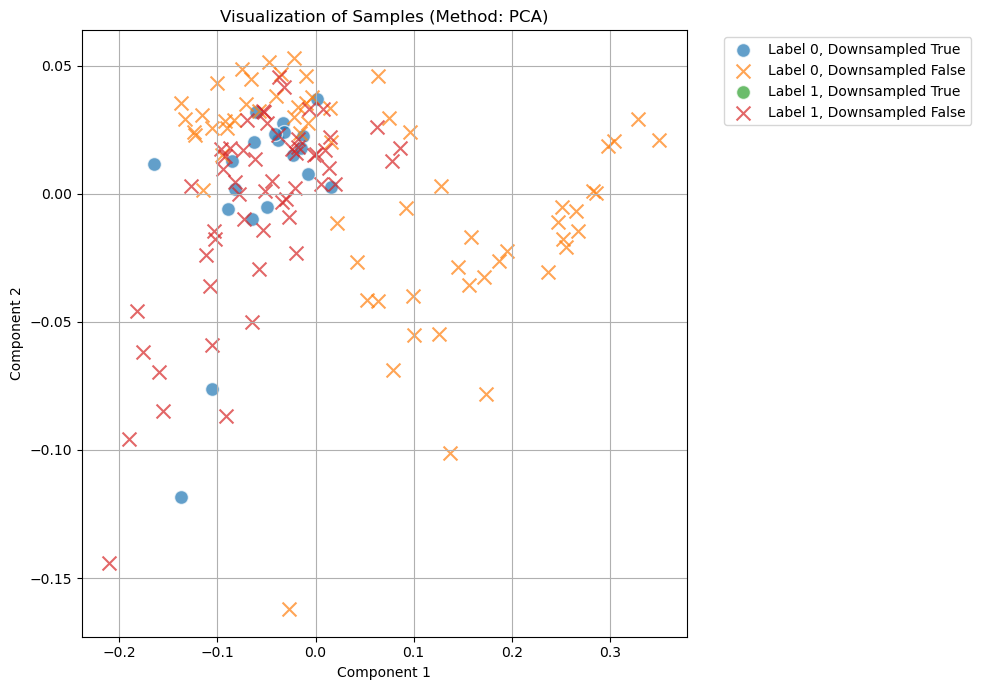

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_downsampled_samples(X, y, sample_names, downsampled_names, method='tsne', n_components=2):
    """
    Visualize samples using dimensionality reduction (t-SNE or PCA).
    
    Parameters:
    - X: Feature matrix
    - y: Labels (0 or 1)
    - sample_names: Names of the samples
    - downsampled_names: Set of names that were downsampled
    - method: Dimensionality reduction method ('tsne' or 'pca')
    """
    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        X_embedded = reducer.fit_transform(X)
    else:
        reducer = PCA(n_components=n_components)
        X_embedded = reducer.fit_transform(X)
        
        # Print explained variance for PCA
        explained_variance = reducer.explained_variance_ratio_ * 100
        for i, var in enumerate(explained_variance, start=1):
            print(f"PCA Component {i} explains {var:.2f}% of the variance.")
        print(f"Total explained variance by the first {n_components} components: {sum(explained_variance):.2f}%")

    
    # Determine downsampled status
    downsampled_status = [name in downsampled_names for name in sample_names]

    # Visualization
    plt.figure(figsize=(10, 7))
    
    for label in np.unique(y):
        for status in [True, False]:
            indices = np.where((y == label) & (np.array(downsampled_status) == status))
            plt.scatter(
                X_embedded[indices, 0], X_embedded[indices, 1], 
                label=f"Label {label}, Downsampled {status}",
                alpha=0.7,
                edgecolors='w',
                s=100,
                marker='o' if status else 'x'
            )
    
    plt.title(f"Visualization of Samples (Method: {method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_downsampled_samples(X, y, list(all_results.keys()), downsampled_names, method='pca')


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [51]:
run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=[], models=[])

KNN Results
Accuracy: 0.875
Balanced Accuracy: 0.8776223776223776
Confusion Matrix:
[[11  2]
 [ 1 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.83      0.91      0.87        11

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24

ROC-AUC: 0.9720279720279721
Precision-Recall AUC: 0.9679144385026738

Logistic Regression Results
Accuracy: 0.875
Balanced Accuracy: 0.8846153846153846
Confusion Matrix:
[[10  3]
 [ 0 11]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.79      1.00      0.88        11

    accuracy                           0.88        24
   macro avg       0.89      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24

ROC-AUC:

MLP Results
Accuracy: 0.9166666666666666
Balanced Accuracy: 0.916083916083916
Confusion Matrix:
[[12  1]
 [ 1 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.91      0.91      0.91        11

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24

ROC-AUC: 0.979020979020979
Precision-Recall AUC: 0.9777495232040687

XGBoost Results:
Accuracy: 0.875
Balanced Accuracy: 0.8776223776223776
Confusion Matrix:
[[11  2]
 [ 1 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.83      0.91      0.87        11

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24

ROC-AUC:

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Neural Network Results:
Accuracy: 0.875
Balanced Accuracy: 0.8846153846153846
Confusion Matrix:
[[10  3]
 [ 0 11]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.79      1.00      0.88        11

    accuracy                           0.88        24
   macro avg       0.89      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24

ROC-AUC: 0.965034965034965
Precision-Recall AUC: 0.9653679653679654



In [ ]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef

# Define the models to evaluate
MODEL_FUNCTIONS = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'MLP': MLPClassifier(max_iter=1000),
    'XGBoost': XGBClassifier(),
}

# Define evaluation metrics
EVALUATION_METRICS = {
    'accuracy': accuracy_score,
    'balanced_accuracy': balanced_accuracy_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
    'mcc': matthews_corrcoef
}


def run_evaluation_func(X_train, X_test, y_train, y_test, k_value, results, save_results=True):
    """
    Train and evaluate a list of models on the provided train/test split.
    Accumulate accuracy scores for each model and store in results.
    """
    for model_name, model in MODEL_FUNCTIONS.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        result = {'k_value': k_value, 'model_name': model_name}
        for metric_name, metric_func in EVALUATION_METRICS.items():
            if metric_name == 'roc_auc' and y_pred_proba is not None:
                result[metric_name] = metric_func(y_test, y_pred_proba)
            else:
                result[metric_name] = metric_func(y_test, y_pred)

        if save_results:
            results.append(result)

    return results


def accumulate_model_performance(X, y, num_runs, k_value, run_evaluation_func, evaluation_metrics=None):
    """
    Run repeated evaluations of models on random train/test splits and accumulate performance metrics.
    
    Parameters:
    - X, y: Feature matrix and labels
    - num_runs: Number of random train/test splits to evaluate
    - k_value: The k value associated with this evaluation (for tracking purposes)
    - run_evaluation_func: The evaluation function to run models and gather results
    - evaluation_metrics: Optional list of metric names to accumulate (e.g., ['accuracy', 'f1_score'])
    
    Returns:
    - aggregated_results: Dictionary with average performance metrics for each model
    """
    if evaluation_metrics is None:
        evaluation_metrics = ['accuracy', 'balanced_accuracy', 'f1_score', 'roc_auc', 'mcc']
    
    # Accumulate results for each model
    score_accumulator = defaultdict(lambda: defaultdict(list))
    all_results = []
    all_models = []

    for run in range(num_runs):
        print(f"### Run {run + 1}/{num_runs} ###")
        
        # Split the data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=run)
        
        # Evaluate models
        results = []
        models = []
        run_evaluation_func(X_train, X_test, y_train, y_test, k_value, results, save_results=True)
        
        # Accumulate scores
        for result in results:
            model_name = result['model_name']
            for metric in evaluation_metrics:
                if metric in result:
                    score_accumulator[model_name][metric].append(result[metric])
        
        all_results.extend(results)
        all_models.extend(models)

    # Calculate average and standard deviation of scores
    aggregated_results = {}
    for model_name, metrics in score_accumulator.items():
        aggregated_results[model_name] = {}
        for metric, scores in metrics.items():
            aggregated_results[model_name][f'avg_{metric}'] = np.mean(scores)
            aggregated_results[model_name][f'std_{metric}'] = np.std(scores)
    
    # Display the results
    print("\n### Aggregated Model Performance ###")
    for model_name, metrics in aggregated_results.items():
        print(f"\nModel: {model_name}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return aggregated_results, all_results, all_models


In [52]:
# Example usage with your dataset
num_runs = 10
k_value = 'all_k'  # Example k value, modify as needed

aggregated_results, all_results, all_models = accumulate_model_performance(
    X_resampled, y_resampled, 
    num_runs=num_runs, 
    k_value=k_value, 
    run_evaluation_func=run_evaluation_func
)


### Run 1/10 ###
### Run 2/10 ###
### Run 3/10 ###
### Run 4/10 ###
### Run 5/10 ###
### Run 6/10 ###
### Run 7/10 ###
### Run 8/10 ###
### Run 9/10 ###
### Run 10/10 ###

### Aggregated Model Performance ###

Model: KNN
avg_accuracy: 0.7750
std_accuracy: 0.0464
avg_balanced_accuracy: 0.7769
std_balanced_accuracy: 0.0459
avg_f1_score: 0.7644
std_f1_score: 0.0489
avg_roc_auc: 0.9028
std_roc_auc: 0.0433
avg_mcc: 0.5588
std_mcc: 0.0932

Model: Logistic Regression
avg_accuracy: 0.6250
std_accuracy: 0.0672
avg_balanced_accuracy: 0.6112
std_balanced_accuracy: 0.0729
avg_f1_score: 0.5036
std_f1_score: 0.1504
avg_roc_auc: 0.7874
std_roc_auc: 0.0850
avg_mcc: 0.2362
std_mcc: 0.1640

Model: SVM
avg_accuracy: 0.7333
std_accuracy: 0.0750
avg_balanced_accuracy: 0.7517
std_balanced_accuracy: 0.0708
avg_f1_score: 0.7723
std_f1_score: 0.0544
avg_roc_auc: 0.8091
std_roc_auc: 0.0767
avg_mcc: 0.5482
std_mcc: 0.1307

Model: Decision Tree
avg_accuracy: 0.8667
std_accuracy: 0.0583
avg_balanced_accuracy: 0.86

## Kidney

In [75]:
import pandas as pd
import numpy as np
import json

def load_results(file_path, data_type='ovarian'):
    # load json file
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    # create labels dictionary
    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            if sample_name.endswith("_H"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_OC"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'colon':
            if sample_name.endswith("_low"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_high"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'kidney':
            if "STA" in sample_name:
                labels_dict[sample_name] = 0
            elif "AR" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
    return all_results, labels_dict


def prepare_data(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            ## TODO: find a way to padd all data types, not only "all_k". code was tab to the left
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant') 
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)
    return data, labels
	

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
import xgboost as xgb


def calculate_instance_hardness(X, y, models=None, cv=5):
    """
    Calculate instance hardness based on multiple classifiers' misclassification rates.
    
    Parameters:
    - X: Feature matrix
    - y: Target labels
    - models: List of classifiers to use for instance hardness calculation
    - cv: Number of cross-validation folds
    
    Returns:
    - hardness_scores: Dictionary with sample indices and their instance hardness scores
    """
    if models is None:
        models = [
            RandomForestClassifier(n_estimators=250, random_state=42),
            xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            SVC(probability=True, random_state=42)
        ]
    
    # Store misclassifications for each model
    misclassifications = np.zeros(len(y))
    
    for model in models:
        y_pred = cross_val_predict(model, X, y, cv=cv)
        misclassifications += (y_pred != y)
    
    # Calculate the instance hardness score as the proportion of misclassifications
    hardness_scores = misclassifications / len(models)
    
    return dict(enumerate(hardness_scores))

def undersample_using_ih(X, y, sample_names, ih_scores, threshold=0.5):
    """
    Undersample the majority class using an instance hardness threshold.
    
    Parameters:
    - X: Feature matrix
    - y: Target labels
    - sample_names: Names of the samples (for tracking)
    - ih_scores: Dictionary of instance hardness scores
    - threshold: IH threshold for undersampling
    
    Returns:
    - X_resampled, y_resampled, resampled_sample_names: The undersampled feature matrix, labels, and sample names
    """
    minority_class = 1 if np.sum(y == 1) < np.sum(y == 0) else 0
    majority_class = 1 - minority_class
    
    # Split indices by class
    minority_indices = [i for i, label in enumerate(y) if label == minority_class]
    majority_indices = [i for i, label in enumerate(y) if label == majority_class]
    
    # Apply the IH threshold to filter majority class samples
    filtered_majority_indices = [i for i in majority_indices if ih_scores[i] < threshold]
    
    # Combine all minority samples with selected majority samples
    selected_indices = minority_indices + filtered_majority_indices
    
    X_resampled = X[selected_indices]
    y_resampled = y[selected_indices]
    resampled_sample_names = [sample_names[i] for i in selected_indices]
    
    return X_resampled, y_resampled, resampled_sample_names


In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_downsampled_samples(X, y, sample_names, downsampled_names, method='tsne'):
    """
    Visualize samples using dimensionality reduction (t-SNE or PCA).
    
    Parameters:
    - X: Feature matrix
    - y: Labels (0 or 1)
    - sample_names: Names of the samples
    - downsampled_names: Set of names that were downsampled
    - method: Dimensionality reduction method ('tsne' or 'pca')
    """
    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        reducer = PCA(n_components=2)
        
    X_embedded = reducer.fit_transform(X)
    
    # Determine downsampled status
    downsampled_status = [name in downsampled_names for name in sample_names]

    # Visualization
    plt.figure(figsize=(10, 7))
    
    for label in np.unique(y):
        for status in [True, False]:
            indices = np.where((y == label) & (np.array(downsampled_status) == status))
            plt.scatter(
                X_embedded[indices, 0], X_embedded[indices, 1], 
                label=f"Label {label}, Downsampled {status}",
                alpha=0.7,
                edgecolors='w',
                s=100,
                marker='o' if status else 'x'
            )
    
    plt.title(f"Visualization of Samples (Method: {method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [78]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef

# Define the models to evaluate
MODEL_FUNCTIONS = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'MLP': MLPClassifier(max_iter=1000),
    'XGBoost': XGBClassifier(),
}

# Define evaluation metrics
EVALUATION_METRICS = {
    'accuracy': accuracy_score,
    'balanced_accuracy': balanced_accuracy_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
    'mcc': matthews_corrcoef
}


def run_evaluation_func(X_train, X_test, y_train, y_test, k_value, results, save_results=True):
    """
    Train and evaluate a list of models on the provided train/test split.
    Accumulate accuracy scores for each model and store in results.
    """
    for model_name, model in MODEL_FUNCTIONS.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        result = {'k_value': k_value, 'model_name': model_name}
        for metric_name, metric_func in EVALUATION_METRICS.items():
            if metric_name == 'roc_auc' and y_pred_proba is not None:
                result[metric_name] = metric_func(y_test, y_pred_proba)
            else:
                result[metric_name] = metric_func(y_test, y_pred)

        if save_results:
            results.append(result)

    return results


def accumulate_model_performance(X, y, num_runs, k_value, run_evaluation_func, evaluation_metrics=None):
    """
    Run repeated evaluations of models on random train/test splits and accumulate performance metrics.
    
    Parameters:
    - X, y: Feature matrix and labels
    - num_runs: Number of random train/test splits to evaluate
    - k_value: The k value associated with this evaluation (for tracking purposes)
    - run_evaluation_func: The evaluation function to run models and gather results
    - evaluation_metrics: Optional list of metric names to accumulate (e.g., ['accuracy', 'f1_score'])
    
    Returns:
    - aggregated_results: Dictionary with average performance metrics for each model
    """
    if evaluation_metrics is None:
        evaluation_metrics = ['accuracy', 'balanced_accuracy', 'f1_score', 'roc_auc', 'mcc']
    
    # Accumulate results for each model
    score_accumulator = defaultdict(lambda: defaultdict(list))
    all_results = []
    all_models = []

    for run in range(num_runs):
        print(f"### Run {run + 1}/{num_runs} ###")
        
        # Split the data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=run)
        
        # Evaluate models
        results = []
        models = []
        run_evaluation_func(X_train, X_test, y_train, y_test, k_value, results, save_results=True)
        
        # Accumulate scores
        for result in results:
            model_name = result['model_name']
            for metric in evaluation_metrics:
                if metric in result:
                    score_accumulator[model_name][metric].append(result[metric])
        
        all_results.extend(results)
        all_models.extend(models)

    # Calculate average and standard deviation of scores
    aggregated_results = {}
    for model_name, metrics in score_accumulator.items():
        aggregated_results[model_name] = {}
        for metric, scores in metrics.items():
            aggregated_results[model_name][f'avg_{metric}'] = np.mean(scores)
            aggregated_results[model_name][f'std_{metric}'] = np.std(scores)
    
    # Display the results
    print("\n### Aggregated Model Performance ###")
    for model_name, metrics in aggregated_results.items():
        print(f"\nModel: {model_name}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return aggregated_results, all_results, all_models


In [79]:
input_json = "/home/dsi/orrbavly/GNN_project/embeddings/kidney_percentiles/perc_results_cos_3_19k.json"
data_type = "kidney"

In [80]:
all_results, labels_dict = load_results(input_json, data_type=data_type)

X, y = prepare_data(all_results, labels_dict)

# Calculate instance hardness scores
ih_scores = calculate_instance_hardness(X, y)

# Apply IH threshold undersampling
X_resampled, y_resampled, resampled_sample_names = undersample_using_ih(X, y, list(all_results.keys()), ih_scores, threshold=0.3)

# Output the resampled dataset size
print(f"Original dataset size: {len(y)}")
print(f"Resampled dataset size: {len(y_resampled)}")

Original dataset size: 156
Resampled dataset size: 117


In [81]:
# Calculate the downsampled sample names
original_names = set(list(all_results.keys()))  # Original sample names from the JSON input
downsampled_names = original_names.difference(set(resampled_sample_names))

# Print the downsampled sample names
print("\n### Downsampled Sample Names ###")
for name in downsampled_names:
    print(name)

print(f"\nTotal downsampled samples: {len(downsampled_names)}")


### Downsampled Sample Names ###
STA_092
STA_017
STA_016
STA_024
STA_045
STA_044
STA_009
STA_001
STA_064
STA_043
STA_054
STA_083
STA_084
STA_030
STA_029
STA_027
STA_087
STA_099
STA_076
STA_036
STA_055
STA_061
STA_008
STA_041
STA_094
STA_086
STA_058
STA_080
STA_060
STA_028
STA_091
STA_057
STA_089
STA_081
STA_038
STA_010
STA_048
STA_011
STA_050

Total downsampled samples: 39


/tmp/ipykernel_1838970/841247515.py:34: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


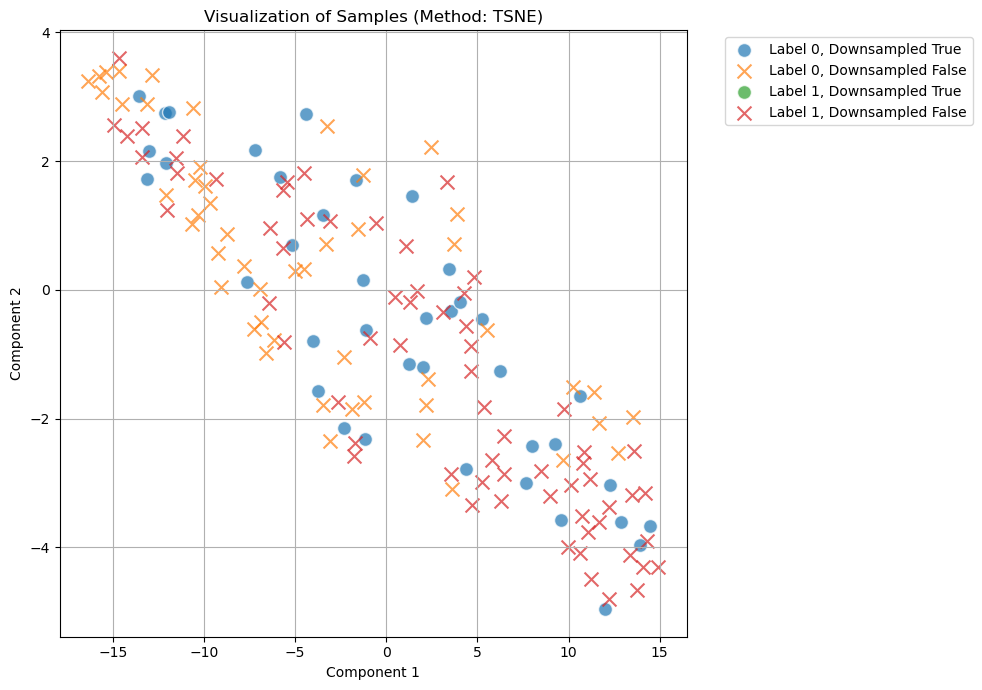

In [82]:
# visualize downsamples samples
visualize_downsampled_samples(X, y, list(all_results.keys()), downsampled_names, method='tsne')


Run evaluation on downsamples dataset.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=[], models=[])

KNN Results
Accuracy: 0.625
Balanced Accuracy: 0.5785714285714285
Confusion Matrix:
[[ 3  7]
 [ 2 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.63      0.86      0.73        14

    accuracy                           0.62        24
   macro avg       0.62      0.58      0.56        24
weighted avg       0.62      0.62      0.59        24

ROC-AUC: 0.6857142857142856
Precision-Recall AUC: 0.7674076495586792

Logistic Regression Results
Accuracy: 0.75
Balanced Accuracy: 0.7142857142857143
Confusion Matrix:
[[ 5  5]
 [ 1 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.72      0.93      0.81        14

    accuracy                           0.75        24
   macro avg       0.78      0.71      0.72        24
weighted avg       0.77      0.75      0.73        24

ROC-AUC: 

ROC-AUC: 0.7785714285714286
Precision-Recall AUC: 0.7690476190476191

Random Forest Results
Accuracy: 0.7083333333333334
Balanced Accuracy: 0.6928571428571428
Confusion Matrix:
[[ 6  4]
 [ 3 11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.73      0.79      0.76        14

    accuracy                           0.71        24
   macro avg       0.70      0.69      0.70        24
weighted avg       0.71      0.71      0.71        24

ROC-AUC: 0.8142857142857143
Precision-Recall AUC: 0.877422400072776

MLP Results
Accuracy: 0.625
Balanced Accuracy: 0.5928571428571429
Confusion Matrix:
[[ 4  6]
 [ 3 11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.65      0.79      0.71        14

    accuracy                           0.62        24
   macro avg       0.61      0.59      0.

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Neural Network Results:
Accuracy: 0.625
Balanced Accuracy: 0.5928571428571429
Confusion Matrix:
[[ 4  6]
 [ 3 11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.65      0.79      0.71        14

    accuracy                           0.62        24
   macro avg       0.61      0.59      0.59        24
weighted avg       0.62      0.62      0.61        24

ROC-AUC: 0.6785714285714286
Precision-Recall AUC: 0.7617717182566806



In [84]:
# Example usage with your dataset
num_runs = 10
k_value = 'all_k'  # Example k value, modify as needed

aggregated_results, all_results, all_models = accumulate_model_performance(
    X_resampled, y_resampled, 
    num_runs=num_runs, 
    k_value=k_value, 
    run_evaluation_func=run_evaluation_func
)

### Run 1/10 ###
### Run 2/10 ###
### Run 3/10 ###
### Run 4/10 ###
### Run 5/10 ###
### Run 6/10 ###
### Run 7/10 ###
### Run 8/10 ###
### Run 9/10 ###
### Run 10/10 ###

### Aggregated Model Performance ###

Model: KNN
avg_accuracy: 0.6333
std_accuracy: 0.1017
avg_balanced_accuracy: 0.6129
std_balanced_accuracy: 0.1021
avg_f1_score: 0.6980
std_f1_score: 0.0960
avg_roc_auc: 0.6929
std_roc_auc: 0.0697
avg_mcc: 0.2341
std_mcc: 0.2074

Model: Logistic Regression
avg_accuracy: 0.5833
std_accuracy: 0.0000
avg_balanced_accuracy: 0.5000
std_balanced_accuracy: 0.0000
avg_f1_score: 0.7368
std_f1_score: 0.0000
avg_roc_auc: 0.7014
std_roc_auc: 0.0371
avg_mcc: 0.0000
std_mcc: 0.0000

Model: SVM
avg_accuracy: 0.6333
std_accuracy: 0.0408
avg_balanced_accuracy: 0.5671
std_balanced_accuracy: 0.0409
avg_f1_score: 0.7538
std_f1_score: 0.0308
avg_roc_auc: 0.6521
std_roc_auc: 0.1362
avg_mcc: 0.2460
std_mcc: 0.1317

Model: Decision Tree
avg_accuracy: 0.6667
std_accuracy: 0.0968
avg_balanced_accuracy: 0.66

## Colon

In [85]:
input_json = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_1_all.json"
data_type = "colon"

In [86]:
all_results, labels_dict = load_results(input_json, data_type=data_type)

X, y = prepare_data(all_results, labels_dict)

# Calculate instance hardness scores
ih_scores = calculate_instance_hardness(X, y)

# Apply IH threshold undersampling
X_resampled, y_resampled, resampled_sample_names = undersample_using_ih(X, y, list(all_results.keys()), ih_scores, threshold=0.3)

# Output the resampled dataset size
print(f"Original dataset size: {len(y)}")
print(f"Resampled dataset size: {len(y_resampled)}")

Original dataset size: 139
Resampled dataset size: 113


In [87]:
# Calculate the downsampled sample names
original_names = set(list(all_results.keys()))  # Original sample names from the JSON input
downsampled_names = original_names.difference(set(resampled_sample_names))

# Print the downsampled sample names
print("\n### Downsampled Sample Names ###")
for name in downsampled_names:
    print(name)

print(f"\nTotal downsampled samples: {len(downsampled_names)}")


### Downsampled Sample Names ###
pool8_S22_low
pool2_S2_low
pool7_S4_low
pool3_S18_low
pool8_S15_low
pool6_S23_low
pool3_S6_low
pool2_S5_low
pool6_S24_low
pool2_S13_low
pool7_S18_low
pool2_S24_low
pool4_S13_low
pool3_S15_low
pool1_S5_low
pool9_S23_low
pool9_S13_low
pool7_S23_low
pool3_S14_low
pool7_S24_low
pool7_S19_low
pool3_S5_low
pool3_S10_low
pool6_S19_low
pool4_S12_low
pool9_S7_low

Total downsampled samples: 26


/tmp/ipykernel_1838970/841247515.py:34: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


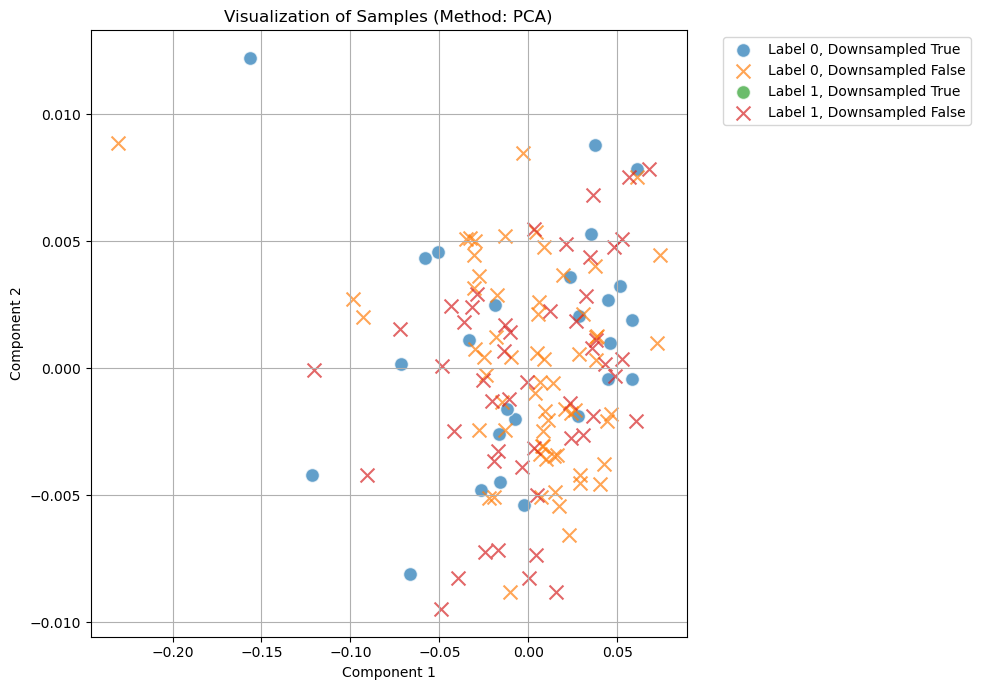

In [90]:
# visualize downsamples samples
visualize_downsampled_samples(X, y, list(all_results.keys()), downsampled_names, method='pca')

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=[], models=[])


KNN Results
Accuracy: 0.6956521739130435
Balanced Accuracy: 0.6961538461538461
Confusion Matrix:
[[9 4]
 [3 7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.64      0.70      0.67        10

    accuracy                           0.70        23
   macro avg       0.69      0.70      0.69        23
weighted avg       0.70      0.70      0.70        23

ROC-AUC: 0.7076923076923077
Precision-Recall AUC: 0.6230237154150198

Logistic Regression Results
Accuracy: 0.6956521739130435
Balanced Accuracy: 0.65
Confusion Matrix:
[[13  0]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        13
           1       1.00      0.30      0.46        10

    accuracy                           0.70        23
   macro avg       0.82      0.65      0.62        23
weighted avg       0.80      0.70      0.65        23



/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Neural Network Results:
Accuracy: 0.6521739130434783
Balanced Accuracy: 0.6461538461538461
Confusion Matrix:
[[9 4]
 [4 6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.60      0.60      0.60        10

    accuracy                           0.65        23
   macro avg       0.65      0.65      0.65        23
weighted avg       0.65      0.65      0.65        23

ROC-AUC: 0.6384615384615385
Precision-Recall AUC: 0.5885792709705753



In [92]:
# Example usage with your dataset
num_runs = 10
k_value = 'all_k'  # Example k value, modify as needed

aggregated_results, all_results, all_models = accumulate_model_performance(
    X_resampled, y_resampled, 
    num_runs=num_runs, 
    k_value=k_value, 
    run_evaluation_func=run_evaluation_func
)

### Run 1/10 ###
### Run 2/10 ###
### Run 3/10 ###
### Run 4/10 ###
### Run 5/10 ###
### Run 6/10 ###
### Run 7/10 ###
### Run 8/10 ###
### Run 9/10 ###
### Run 10/10 ###

### Aggregated Model Performance ###

Model: KNN
avg_accuracy: 0.5783
std_accuracy: 0.0478
avg_balanced_accuracy: 0.5715
std_balanced_accuracy: 0.0475
avg_f1_score: 0.5162
std_f1_score: 0.0569
avg_roc_auc: 0.6027
std_roc_auc: 0.0450
avg_mcc: 0.1440
std_mcc: 0.0952

Model: Logistic Regression
avg_accuracy: 0.5652
std_accuracy: 0.0000
avg_balanced_accuracy: 0.5000
std_balanced_accuracy: 0.0000
avg_f1_score: 0.0000
std_f1_score: 0.0000
avg_roc_auc: 0.4731
std_roc_auc: 0.0685
avg_mcc: 0.0000
std_mcc: 0.0000

Model: SVM
avg_accuracy: 0.5652
std_accuracy: 0.0000
avg_balanced_accuracy: 0.5000
std_balanced_accuracy: 0.0000
avg_f1_score: 0.0000
std_f1_score: 0.0000
avg_roc_auc: 0.5323
std_roc_auc: 0.0850
avg_mcc: 0.0000
std_mcc: 0.0000

Model: Decision Tree
avg_accuracy: 0.5739
std_accuracy: 0.0696
avg_balanced_accuracy: 0.57

# Feature selection

In [42]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.preprocessing

def load_results(file_path, data_type='ovarian'):
    # load json file
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    # create labels dictionary
    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            if sample_name.endswith("_H"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_OC"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'colon':
            if sample_name.endswith("_low"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_high"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'kidney':
            if "STA" in sample_name:
                labels_dict[sample_name] = 0
            elif "AR" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'corona':
            if "TCRB_M" in sample_name:
                labels_dict[sample_name] = 0
            elif "TCRB_F" in sample_name:
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
    return all_results, labels_dict

def prepare_data(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        # Calculate average vector from all k values
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array([np.array(v) for v in percentiles_dict.values()])
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        if vector_indices is None:
            # No filtering, consider all values
            max_length = max(
                sum(len(v) for v in percentiles_dict.values()) 
                for percentiles_dict in percentiles_data.values()
            )
        else:
            # Compute max_length only for selected indices
            max_length = max(
                sum(len(v) for i, v in enumerate(percentiles_dict.values()) if i in vector_indices)
                for percentiles_dict in percentiles_data.values()
            )

        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())

            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
            else:
                selected_vectors = vectors
            flattened_percentiles = np.concatenate([np.array(v) for v in selected_vectors])
            # Pad only up to max_length for selected indices
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')

            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [43]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

def feature_selection(data, labels, k_values, percentiles, method="random_forest", top_n=None):
    """
    Perform feature selection and print the most dominant percentiles across all k values.

    Parameters:
    - data (numpy array): Feature matrix (samples x features)
    - labels (numpy array): Target labels
    - k_values (list): List of K values used in the knn graphs
    - percentiles (list): List of percentiles calculated for each k value
    - method (str): Feature selection method, choose from ["random_forest", "mutual_info", "lasso", "rfe"]
    - top_n (int, optional): Number of top **percentiles** to use for feature selection.

    Returns:
    - selected_data (numpy array): Data with selected features
    - selected_features (list): Indices of selected features
    - percentile_importance (dict): Aggregated importance scores for each percentile
    """

    num_k = len(k_values)
    num_p = len(percentiles)

    if data.shape[1] != num_k * num_p:
        raise ValueError("Mismatch between feature dimensions and expected (K x percentiles) structure.")

    feature_importances = {}

    # Feature Selection Step (Select All Important Features First)
    if method == "random_forest":
        model = RandomForestClassifier(n_estimators=100)
        model.fit(data, labels)
        importances = model.feature_importances_
        selected_features = np.where(importances > np.mean(importances))[0]  # Select all above mean

    elif method == "mutual_info":
        scores = mutual_info_classif(data, labels)
        selected_features = np.where(scores > np.mean(scores))[0]
        importances = scores

    elif method == "lasso":
        model = LogisticRegression(penalty="l1", solver="liblinear")
        model.fit(data, labels)
        selected_features = np.where(model.coef_[0] != 0)[0]
        importances = model.coef_[0]

    elif method == "rfe":
        model = LogisticRegression(solver="liblinear")
        rfe = RFE(model, n_features_to_select=data.shape[1] // 2, step=1)  # Select 50% of features
        rfe.fit(data, labels)
        selected_features = np.where(rfe.support_)[0]
        importances = rfe.ranking_

    else:
        raise ValueError("Invalid method. Choose from ['random_forest', 'mutual_info', 'lasso', 'rfe'].")

    # Store feature importances for selected features
    feature_importances = {idx: importances[idx] for idx in selected_features}

    selected_data = data[:, selected_features]

    # Aggregate importance scores per percentile
    percentile_importance = defaultdict(float)
    for idx, importance in feature_importances.items():
        k_idx = idx // num_p  # Find K value index
        p_idx = idx % num_p   # Find percentile index
        percentile = percentiles[p_idx]
        percentile_importance[percentile] += importance  # Sum importance scores across all K values

    # Convert to sorted list (descending order)
    sorted_percentiles = sorted(percentile_importance.items(), key=lambda x: x[1], reverse=True)

    # Print all percentile importance scores
    print("\nRanked Percentile Importance Across All K Values:")
    for percentile, score in sorted_percentiles:
        print(f"Percentile {percentile}: Accumulated Importance Score {score:.6f}")

    # Select the most dominant percentiles based on `top_n`
    top_percentiles = {percentile for percentile, _ in sorted_percentiles[:top_n]} if top_n else set(percentiles)

    # Get indices of features corresponding to selected percentiles across all K values
    selected_feature_indices = [
        idx for idx in range(data.shape[1])
        if percentiles[idx % num_p] in top_percentiles
    ]

    # Subset data to keep only selected features
    selected_data = data[:, selected_feature_indices]

    return selected_data, selected_feature_indices, percentile_importance, labels


In [44]:
all_results, labels_dict = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_every5_newk.json", data_type="ovarian")
data, labels = prepare_data(all_results, labels_dict)
k_values = [5, 10, 20, 50, 100, 'sqrt', 'sqrt/2', 'log']
percentiles = [1] + list(range(5, 100, 5)) + [99]

In [45]:
data_selected, selected_indices, percentile_importance, selected_labels = feature_selection(
    data, labels, k_values, percentiles, method="random_forest", top_n=7
)


Ranked Percentile Importance Across All K Values:
Percentile 1: Accumulated Importance Score 0.068647
Percentile 35: Accumulated Importance Score 0.066516
Percentile 30: Accumulated Importance Score 0.058844
Percentile 25: Accumulated Importance Score 0.055096
Percentile 40: Accumulated Importance Score 0.050374
Percentile 20: Accumulated Importance Score 0.049998
Percentile 15: Accumulated Importance Score 0.040358
Percentile 65: Accumulated Importance Score 0.033413
Percentile 45: Accumulated Importance Score 0.029265
Percentile 5: Accumulated Importance Score 0.026811
Percentile 10: Accumulated Importance Score 0.019419
Percentile 85: Accumulated Importance Score 0.019221
Percentile 60: Accumulated Importance Score 0.018810
Percentile 70: Accumulated Importance Score 0.016418
Percentile 50: Accumulated Importance Score 0.015953
Percentile 55: Accumulated Importance Score 0.014623
Percentile 80: Accumulated Importance Score 0.014612
Percentile 90: Accumulated Importance Score 0.0064

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data_selected, selected_labels, test_size=0.2, stratify=labels)

scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [49]:
run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=results, models=models)

KNN Results
Accuracy: 0.7857142857142857
Balanced Accuracy: 0.8074866310160428
Confusion Matrix:
[[12  5]
 [ 1 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.67      0.91      0.77        11

    accuracy                           0.79        28
   macro avg       0.79      0.81      0.78        28
weighted avg       0.82      0.79      0.79        28

ROC-AUC: 0.8502673796791445
Precision-Recall AUC: 0.7525252525252525

Logistic Regression Results
Accuracy: 0.8214285714285714
Balanced Accuracy: 0.8048128342245989
Confusion Matrix:
[[15  2]
 [ 3  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.80      0.73      0.76        11

    accuracy                           0.82        28
   macro avg       0.82      0.80      0.81        28
weighted avg       0.82      0.82    

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Neural Network Results:
Accuracy: 0.8214285714285714
Balanced Accuracy: 0.820855614973262
Confusion Matrix:
[[14  3]
 [ 2  9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.75      0.82      0.78        11

    accuracy                           0.82        28
   macro avg       0.81      0.82      0.82        28
weighted avg       0.83      0.82      0.82        28

ROC-AUC: 0.8502673796791445
Precision-Recall AUC: 0.8329131652661064



In [50]:
all_results, labels_dict = load_results("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json", data_type="ovarian")
data, labels = prepare_data(all_results, labels_dict)
k_values = [5, 10, 15, 20, 'sqrt', 'sqrt/2', 'log']
percentiles = [5, 15, 25, 35, 50, 70, 80, 90, 95]

In [52]:
data_selected, selected_indices, percentile_importance, selected_labels = feature_selection(
    data, labels, k_values, percentiles, method="random_forest", top_n=5
)


Ranked Percentile Importance Across All K Values:
Percentile 35: Accumulated Importance Score 0.137706
Percentile 15: Accumulated Importance Score 0.115635
Percentile 25: Accumulated Importance Score 0.095306
Percentile 70: Accumulated Importance Score 0.087868
Percentile 50: Accumulated Importance Score 0.044435
Percentile 80: Accumulated Importance Score 0.038652
Percentile 5: Accumulated Importance Score 0.033468
Percentile 95: Accumulated Importance Score 0.019550
Percentile 90: Accumulated Importance Score 0.016696


In [57]:
X_train, X_test, y_train, y_test = train_test_split(data_selected, selected_labels, test_size=0.2, stratify=labels)

scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=[], models=[])

KNN Results
Accuracy: 0.6428571428571429
Balanced Accuracy: 0.5935828877005347
Confusion Matrix:
[[14  3]
 [ 7  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.57      0.36      0.44        11

    accuracy                           0.64        28
   macro avg       0.62      0.59      0.59        28
weighted avg       0.63      0.64      0.62        28

ROC-AUC: 0.6417112299465241
Precision-Recall AUC: 0.4725108225108225

Logistic Regression Results
Accuracy: 0.6071428571428571
Balanced Accuracy: 0.5481283422459893
Confusion Matrix:
[[14  3]
 [ 8  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        17
           1       0.50      0.27      0.35        11

    accuracy                           0.61        28
   macro avg       0.57      0.55      0.54        28
weighted avg       0.58      0.61    

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Neural Network Results:
Accuracy: 0.6071428571428571
Balanced Accuracy: 0.5481283422459893
Confusion Matrix:
[[14  3]
 [ 8  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        17
           1       0.50      0.27      0.35        11

    accuracy                           0.61        28
   macro avg       0.57      0.55      0.54        28
weighted avg       0.58      0.61      0.57        28

ROC-AUC: 0.7593582887700534
Precision-Recall AUC: 0.5945789059425423



# Corona Regression

In [5]:
def prepare_corona_regression_nosplit(percentiles_data, corona_meta, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    # Create a lookup dictionary: base_sample_name (without .tsv) → Age
    corona_meta['base_name'] = corona_meta['longer_sample_name'].str.replace('.tsv', '', regex=False)
    age_lookup = dict(zip(corona_meta['base_name'], corona_meta['Age']))

    if average_vectors:
        for sample_name, percentiles_dict in percentiles_data.items():
            # Extract base name from sample_name
            base_name = "_".join(sample_name.split("_")[:2])  # Keep only 03855000012354_TCRB
            if base_name not in age_lookup:
                raise ValueError(f"Sample {base_name} not found in corona_meta!")
            age = age_lookup[base_name]

            vectors = np.array([np.array(v) for v in percentiles_dict.values()])
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(age)

    else:
        if vector_indices is None:
            max_length = max(
                sum(len(v) for v in percentiles_dict.values()) 
                for percentiles_dict in percentiles_data.values()
            )
        else:
            max_length = max(
                sum(len(v) for i, v in enumerate(percentiles_dict.values()) if i in vector_indices)
                for percentiles_dict in percentiles_data.values()
            )

        for sample_name, percentiles_dict in percentiles_data.items():
            base_name = "_".join(sample_name.split("_")[:2])
            if base_name not in age_lookup:
                raise ValueError(f"Sample {base_name} not found in corona_meta!")
            age = age_lookup[base_name]

            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
            else:
                selected_vectors = vectors

            flattened_percentiles = np.concatenate([np.array(v) for v in selected_vectors])
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')

            data.append(padded_percentiles)
            labels.append(age)

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [8]:
# Load data
INPUT_JSON = "/home/dsi/orrbavly/GNN_project/embeddings/corona_percentiles/subsets/perc_faiss_cos_every5_1-867.json"
data_type = 'corona'
all_results, labels_dict = load_results(INPUT_JSON, data_type=data_type)
corona_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/corona_metadata.csv")

In [10]:
data, labels = prepare_corona_regression_nosplit(all_results, corona_meta)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Split your data
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

# 2. Initialize a regression model
model = Ridge(alpha=1.0)  # Ridge regression is simple and robust

# 3. Train the model
model.fit(X_train, y_train)

# 4. Predict on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📈 Regression Results:")
print(f"R² Score: {r2:.3f}")
print(f"MAE (Mean Absolute Error): {mae:.2f} years")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} years")



📈 Regression Results:
R² Score: 0.186
MAE (Mean Absolute Error): 16.43 years
RMSE (Root Mean Squared Error): 19.69 years


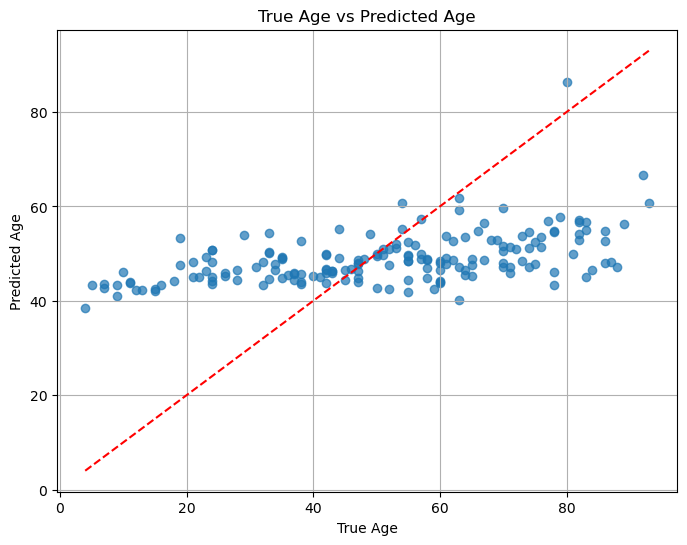

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True Age vs Predicted Age")
plt.grid(True)
plt.show()


R² Score: 0.381
MAE: 13.54
RMSE: 17.18


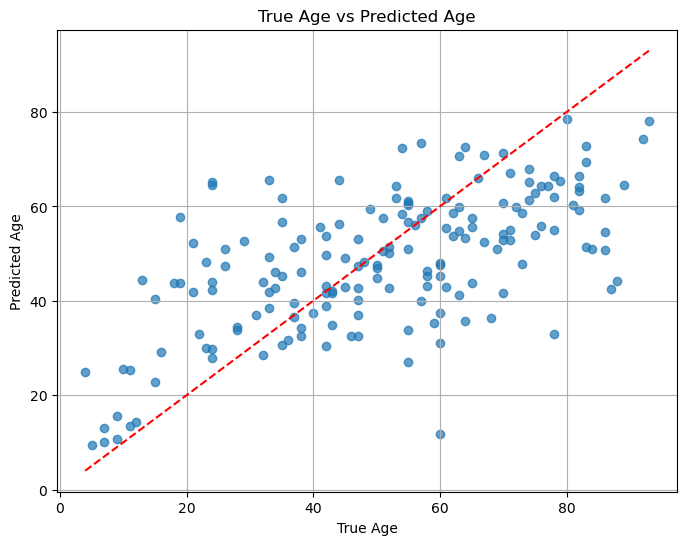

In [17]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True Age vs Predicted Age")
plt.grid(True)
plt.show()


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    verbose=2,
    n_jobs=-1  # Use all CPUs
)

# Run Grid Search
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)

# Evaluate on test set
y_pred = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📈 Evaluation on Test Set:")
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END max_depth=10, min_

In [14]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=10,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


R² Score: 0.315
MAE: 14.32
RMSE: 18.07


In [15]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1.0, epsilon=0.2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


R² Score: 0.043
MAE: 17.82
RMSE: 21.36


In [16]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=(100,50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


R² Score: -0.013
MAE: 18.41
RMSE: 21.97


# Colon extraction time

In [4]:
def load_results_colon_extraction(file_path, meta_file, data_type='colon', time_threshold=750):
    # Load JSON file
    with open(file_path, 'r') as f:
        all_results = json.load(f)

    labels_dict = {}

    if data_type == 'colon' and meta_file is not None and time_threshold is not None:
        # Load metadata
        meta_df = pd.read_csv(meta_file)

        # Clean up Sample_IDs and prepare lookup
        sample_time_map = dict(zip(meta_df['Sample_ID'], meta_df['extraction_time']))

        for sample_name in all_results:
            # Extract base sample ID (e.g., P5-S24)
            parts = sample_name.split('_')
            base_id = next((part for part in parts if part.startswith('P') and '-S' in part), None)

            if base_id is None:
                raise ValueError(f"Could not extract base sample ID from '{sample_name}'.")

            if base_id not in sample_time_map:
                raise ValueError(f"Sample ID '{base_id}' not found in meta file.")

            time_val = sample_time_map[base_id]

            if time_val <= time_threshold:
                labels_dict[sample_name] = 0
            else:
                labels_dict[sample_name] = 1
    return all_results, labels_dict


In [5]:
# Load data
colon_json = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_every5_new_mixcr.json"
data_type = 'colon'
colon_meta ="/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

all_results, labels_dict = load_results_colon_extraction(colon_json, meta_file=colon_meta, data_type=data_type, time_threshold=750)


In [23]:
X_train, X_test, y_train, y_test = prepare_data(all_results, labels_dict)

In [24]:
run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=results, models=models)

KNN Results
Accuracy: 0.7666666666666667
Balanced Accuracy: 0.6428571428571428
Confusion Matrix:
[[20  1]
 [ 6  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        21
           1       0.75      0.33      0.46         9

    accuracy                           0.77        30
   macro avg       0.76      0.64      0.66        30
weighted avg       0.76      0.77      0.73        30

ROC-AUC: 0.7301587301587302
Precision-Recall AUC: 0.6222468687683449

Logistic Regression Results
Accuracy: 0.8
Balanced Accuracy: 0.6666666666666666
Confusion Matrix:
[[21  0]
 [ 6  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       1.00      0.33      0.50         9

    accuracy                           0.80        30
   macro avg       0.89      0.67      0.69        30
weighted avg       0.84      0.80      0.76        3

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-06 11:56:23.307437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76373 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:65:00.0, compute capability: 8.0
2025-05-06 11:56:23.311194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
I0000 00:00:1746521795.809299  698827 service.cc:146] XLA service 0x7fba9c005c50 initialized for platform CUDA (this does

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Neural Network Results:
Accuracy: 0.8
Balanced Accuracy: 0.6984126984126984
Confusion Matrix:
[[20  1]
 [ 5  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        21
           1       0.80      0.44      0.57         9

    accuracy                           0.80        30
   macro avg       0.80      0.70      0.72        30
weighted avg       0.80      0.80      0.78        30

ROC-AUC: 0.8148148148148149
Precision-Recall AUC: 0.7360015328046019



# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Assume X_train, X_test, y_train, y_test are provided by `prepare_data`
# X_train_col, X_test_col, y_train_col, y_test_col
# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_col)
X_test_scaled = scaler.transform(X_test_col)

# Step 2: Apply PCA to the training data
pca = PCA(n_components=2)  # Use 2 components for visualization
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Cumulative explained variance:", explained_variance.cumsum())

# Visualize PCA results (Training Data)
plt.figure(figsize=(8, 6))
for label in np.unique(y_train_col):
    plt.scatter(X_train_pca[y_train_col == label, 0], X_train_pca[y_train_col == label, 1], label=f"Class {label}", alpha=0.7)
plt.title("PCA Visualization (Training Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [ ]:
# Step 3: Apply Spectral Embedding to the training data
spectral = SpectralEmbedding(n_components=3, affinity='nearest_neighbors', n_neighbors=50)
X_train_spectral = spectral.fit_transform(X_train_scaled)

# Visualize Spectral Embedding results (Training Data)
plt.figure(figsize=(8, 6))
for label in np.unique(y_train_col):
    plt.scatter(X_train_spectral[y_train_col == label, 0], X_train_spectral[y_train_col == label, 1], label=f"Class {label}", alpha=0.7)
plt.title("Spectral Embedding Visualization (Training Data)")
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.legend()
plt.show()